# NATURAL LANGUAGE PROCESSING
## Assignment Notebook

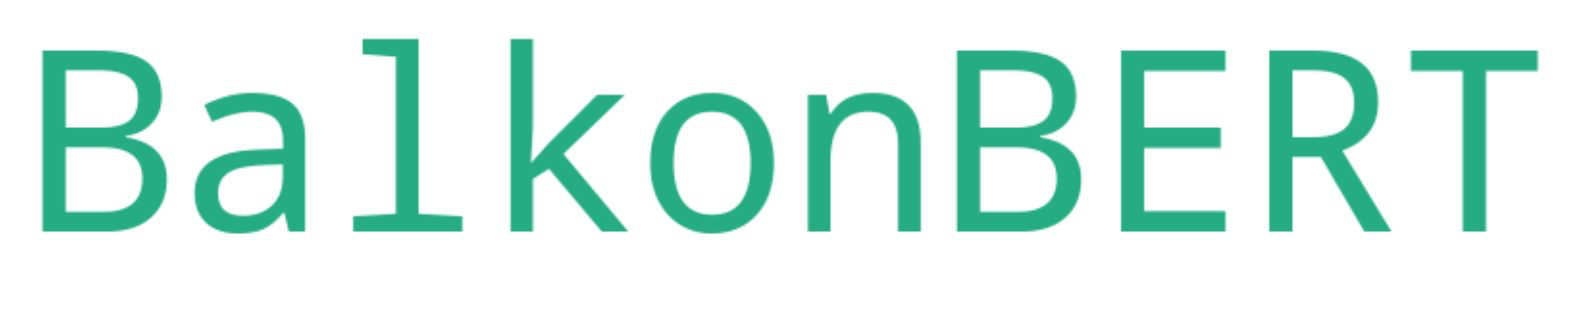

### Authors
- Eren Şenoğlu
- Mehmet Emre Akbulut
- Yavuz Samet Topçuoğlu

##### You can find all the scripts and detailed experiments on the [Github Page](https://github.com/mehmetemreakbulut/YELP-Rating).

##### This notebook is the merged version of the 3 notebooks that explains the different parts of the NLP Project. The project is about Start Rating Prediction Task on YELP Review Dataset. 
##### Please use Kaggle notebook editor if you are unable to see some of the images.

### Dataset Explanation

- The dataset used in this project is the Yelp Review Full dataset, which is a large collection of product reviews along with their star ratings. The dataset is publicly available on the Hugging Face datasets repository and can be accessed [here](https://huggingface.co/datasets/yelp_review_full).

- The dataset was introduced in the paper ["Character-level Convolutional Networks for Text Classification"](https://arxiv.org/abs/1509.01626) by Xiang Zhang, Junbo Zhao, and Yann LeCun. The paper explores the use of character-level convolutional networks for text classification tasks.

- The Yelp Review Full dataset is particularly suited for tasks such as star rating prediction and sentiment analysis. Each review in the dataset is associated with a star rating, which can be used as a proxy for the sentiment expressed in the review. The goal of the project is to build a model that can accurately predict the star rating of a review based on its text content.

### Preliminary Analysis 

- Load the dataset.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

- Inspect the dataset.

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})


In [ ]:
# Print the first example in the dataset
print(dataset["train"][0])

{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}


Notice that the dataset consists of 700000 rows in total, 650000 for train and 50000 for test.\
Each sample has :
 - - a 'label', ```int``` type.
 - - a 'text', ```string``` type.

- Convert sets to dataframes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Convert the train dataset to a pandas DataFrame
train_df = pd.DataFrame(dataset["train"])

# Convert the test dataset to a pandas DataFrame
test_df = pd.DataFrame(dataset["test"])

* Visualise collection statistics.

- 1. - Label Distributions

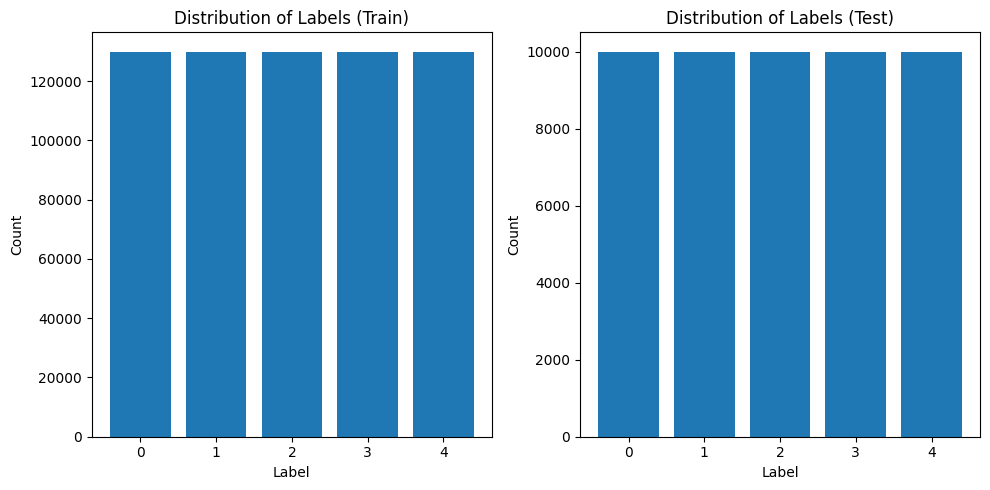

In [ ]:
# Count the occurrences of each label in the train dataset
train_label_counts = train_df["label"].value_counts()

# Count the occurrences of each label in the test dataset
test_label_counts = test_df["label"].value_counts()

# Create subplots for train and test datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution of labels for train dataset
ax1.bar(train_label_counts.index, train_label_counts.values)
ax1.set_xlabel("Label")
ax1.set_ylabel("Count")
ax1.set_title("Distribution of Labels (Train)")

# Plot the distribution of labels for test dataset
ax2.bar(test_label_counts.index, test_label_counts.values)
ax2.set_xlabel("Label")
ax2.set_ylabel("Count")
ax2.set_title("Distribution of Labels (Test)")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

Both in train and test sets, each label has the same amount of data showing that the dataset is <b>evenly distributed</b> across different labels.

- 2. - Document Length and Vocab Size

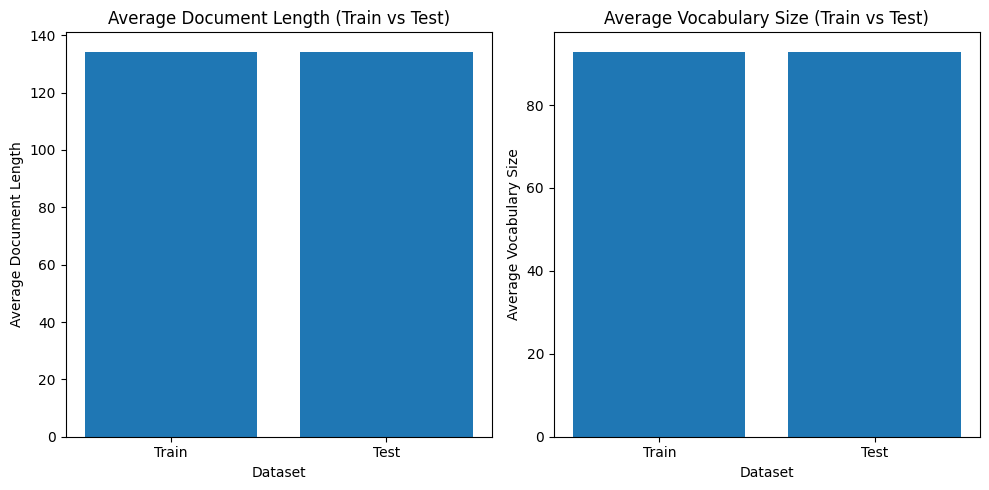

In [ ]:
# Calculate the document length for each document
train_df['doc_length'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['doc_length'] = test_df['text'].apply(lambda x: len(x.split()))

# Calculate the average document length
avg_doc_length_train = train_df['doc_length'].mean()
avg_doc_length_test = test_df['doc_length'].mean()

# Calculate the vocabulary size for each document
train_df['vocab_size'] = train_df['text'].apply(lambda x: len(set(x.split())))
test_df['vocab_size'] = test_df['text'].apply(lambda x: len(set(x.split())))

# Calculate the average vocabulary size
avg_vocab_size_train = train_df['vocab_size'].mean()
avg_vocab_size_test = test_df['vocab_size'].mean()

# Create subplots for average document length and average vocabulary size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the average document length
ax1.bar(['Train', 'Test'], [avg_doc_length_train, avg_doc_length_test])
ax1.set_xlabel("Dataset")
ax1.set_ylabel("Average Document Length")
ax1.set_title("Average Document Length (Train vs Test)")

# Plot the average vocabulary size
ax2.bar(['Train', 'Test'], [avg_vocab_size_train, avg_vocab_size_test])
ax2.set_xlabel("Dataset")
ax2.set_ylabel("Average Vocabulary Size")
ax2.set_title("Average Vocabulary Size (Train vs Test)")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
print(train_df.describe())
print(test_df.describe())

               label     doc_length     vocab_size
count  650000.000000  650000.000000  650000.000000
mean        2.000000     134.098089      92.712128
std         1.414215     121.396115      67.647099
min         0.000000       1.000000       1.000000
25%         1.000000      52.000000      44.000000
50%         2.000000      99.000000      76.000000
75%         3.000000     175.000000     123.000000
max         4.000000    1052.000000     564.000000
              label    doc_length    vocab_size
count  50000.000000  50000.000000  50000.000000
mean       2.000000    134.290980     92.885480
std        1.414228    121.246345     67.659939
min        0.000000      1.000000      1.000000
25%        1.000000     53.000000     45.000000
50%        2.000000     99.000000     77.000000
75%        3.000000    176.000000    123.000000
max        4.000000   1009.000000    512.000000


As we can see from the dataframe descriptions and the plots above, both in train and test sets, the characteristics of the samples are similar to each other. Average document length in train and test sets are less than a word, whereas average vocab size is similarly has a difference of less than one word in two sets.

- Subsample the data for further analysis.

In [ ]:
# Reduce the size of the train and test datasets
train_df_sample = train_df.sample(n=65000, random_state=1)
test_df_sample = test_df.sample(n=5000, random_state=1)

We will try to explore if a simple clustering will be beneficial for the dataset in the following cells.

- Utilise TF-IDF Vectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt

# Convert the text into numerical data using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_df_sample['text'])

- Cluster documents using K-Means.
- Attach assigned labels to the data.

In [ ]:
# Use K-means to cluster the documents
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

# Add the cluster labels to the dataframe
train_df_sample['cluster'] = kmeans.labels_

- Reduce dimensionality of the data using TruncatedSVM.

In [ ]:
# Use TruncatedSVD to reduce the dimensionality of the data to 2D
svd = TruncatedSVD(n_components=2, random_state=0)
principalComponents = svd.fit_transform(X)

# Create a DataFrame with the two principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

- Visualise the lower dimension data both with assigned labels and true labels.

- 1. - K-Means Assigned Labels

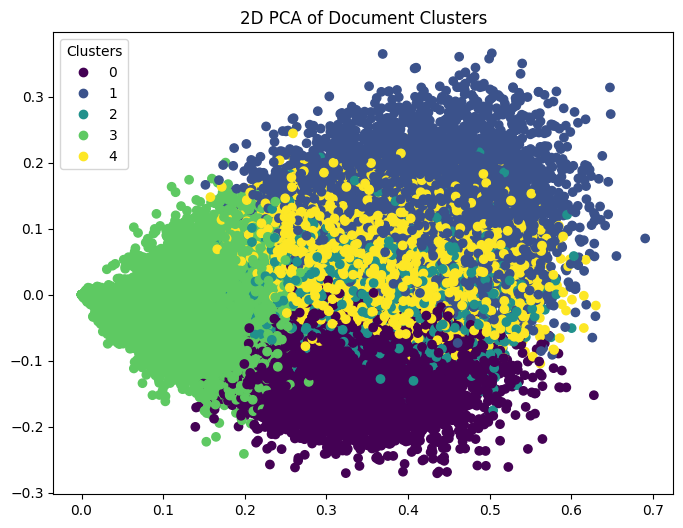

done


In [ ]:
# Visualize the clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=train_df_sample['cluster'])
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D PCA of Document Clusters')
plt.show()
print('done')

- 2. - True Labels

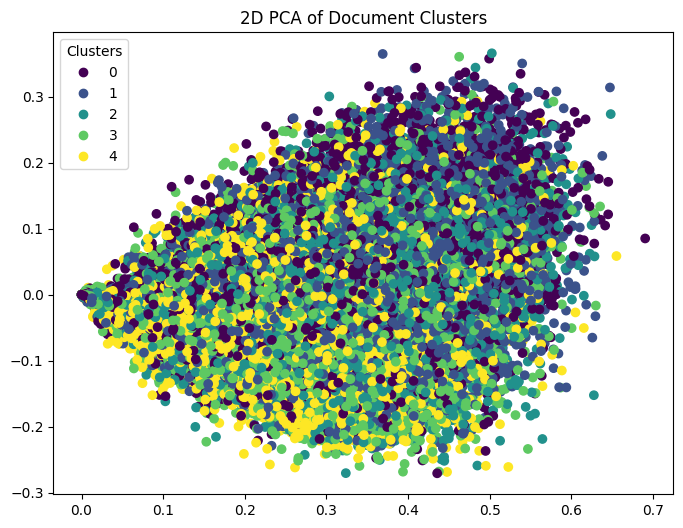

done


In [ ]:
# Visualize the clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=train_df_sample['label'])
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D PCA of Document Clusters')
plt.show()
print('done')

As we see from the plots above, a simple clustering with TF-IDF Vectorizer do not reflect the true distribution of labels on the data. 

But why?

To understand it better, let's take a look at the following sample:

In [ ]:
train_df_sample.iloc[0]['text']

'Thank you for all the emails you sent me on my review! I was surprised at how many responses I recieved from people searching for the right dentist..\\nI shared my new dentist information and even got some movie tickets from my dentist for the referrals!\\nI find it funny how since I wrote this review how many people have reviewed with 5 stars... They must have a lot of friends and family! \\nI hope everyone reads my review and picks the right dentist for your needs!\\nHappy Holidays'

Even though this sample has words like:
```thank```, ```surprised```, ```right dentist```, ```5 stars```,  ```happy```;
it is labeled as ```0```. Lowest it can get.

And you can see the irrelevance between the true label and the assigned label from the table below:

In [ ]:
train_df_sample

label                                               text  doc_length  \
21194       0  Thank you for all the emails you sent me on my...          86   
373117      3  I, myself, and vietnamese and have tried all d...         129   
470627      2  3.5 stars.\n\nI have had BFG on my list of \"m...         140   
256672      2  Edamame with truffle salt was great; really li...          27   
465495      3  So I'm running  errands before I go back to th...         129   
...       ...                                                ...         ...   
344887      4    I love this place and their excellent steaks...           8   
580827      3  Been there twice. Great food but buy the wine ...          12   
485230      0  I bought an amazing TaylorMade golf bag for so...         349   
550667      4  Holy crud was this place AMAZING!!!!!! It came...          77   
63720       0  Sam Woo is a Chinese popularity name you would...         231   

        vocab_size  cluster  
21194           62        3  
373117          90        0  
470627         102        4  
256672          26        3  
465495          84        4  
...            ...      ...  
344887           8        3  
580827          11        3  
485230         217        2  
550667          62        1  
63720          154        0  

[65000 rows x 5 columns]

To be more precise, and show statistics:

In [ ]:
(train_df_sample['label'] == train_df_sample['cluster']).sum()

10575

Out of 65000 train samples, only 10575 (16%) assigned the true label.

- Similarly, let's inspect the wordclouds for the data labeled as ```0``` and ```4```.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

(-0.5, 399.5, 199.5, -0.5)

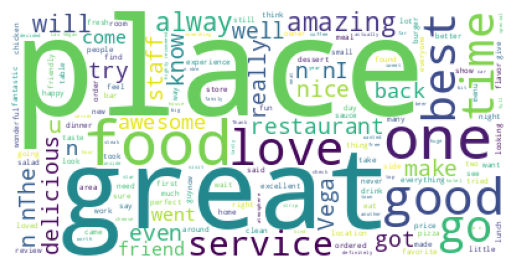

In [ ]:
df5 = train_df_sample[train_df_sample.label == 4]
text5 = ''
for line in df5.text:
    text5 += line + " "
wordcloud5 = WordCloud(background_color="white").generate(text5)
plt.imshow(wordcloud5)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

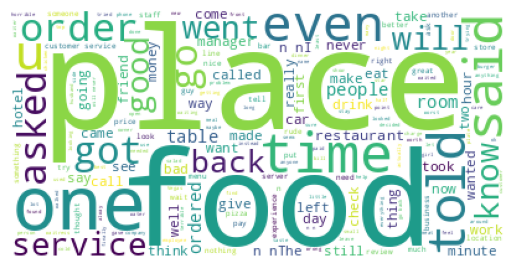

In [ ]:
df1 = train_df_sample[train_df_sample.label == 0]
text1 = ''
for line in df1.text:
    text1 += line + " "
wordcloud1 = WordCloud(background_color="white").generate(text1)
plt.imshow(wordcloud1)
plt.axis("off")

As we can see from the wordclouds, most of the words are in common to both set of data even though they are the exact opposite in terms of labels.

You may not expect a word like ```good``` to be frequently used in samples labeled ```0```.

### Indexing

- Merge train and test sets to allow searching over the entire dataset.

In [ ]:
df = pd.concat([train_df, test_df])
df = df.reset_index(drop=True)

In [ ]:
df

label                                               text
0           4  dr. goldberg offers everything i look for in a...
1           1  Unfortunately, the frustration of being Dr. Go...
2           3  Been going to Dr. Goldberg for over 10 years. ...
3           3  Got a letter in the mail last week that said D...
4           0  I don't know what Dr. Goldberg was like before...
...       ...                                                ...
699995      0  Just wanted to write a review to chip in with ...
699996      4  Great ambience. Great drinks. Great food. I lo...
699997      3  I have been to the other Monks locations so I ...
699998      1  Don't go here.  I know you might want to try i...
699999      0  Buffet was recently open after renovation so m...

[700000 rows x 2 columns]

- Implement the inverted index from scratch.

In [ ]:
# dictionary = 
# { 
#     word: (
#         number of docs containing word ,
#         {
#             doc_id: [position_list]
#         },
#         number of times word appears in all docs      
#     )
# }

dictionary = {}

- Apply preprocessing to the data (and the query during search). \
\
 Note that this preprocessing is not the same as preprocessing applied before the model trainings. This preprocessing will only be used for search engine.

In [ ]:
import re

def apply_preprocessing(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Replace whitespace with a single space
    text = re.sub(r'\s+', ' ', text)
    
    return text

- Build the inverted index.

In [ ]:
def build_index(df):
    len_df = len(df)
    for id, row in df.iterrows():
        print(f'Processing progress: {id+1}/{len_df} ({(id+1)/len_df*100:.2f}%)', end='\r')
        text = apply_preprocessing(row['text'])

        # Split the text into words and iterate over them
        for index, word in enumerate(text.split()):

            # If the word is already in the dictionary, update the dictionary
            if word in dictionary:
                if id in dictionary[word][1]:
                    dictionary[word][1][id].append(index)   # Update the position list
                else:
                    dictionary[word][1][id] = [index]       # Create the position list
                    dictionary[word][0] += 1            # Update the number of docs containing the word
                dictionary[word][2] += 1                # Update the number of times the word appears in all docs
            
            # If the word is not in the dictionary, add it to the dictionary
            else:
                dictionary[word] = [1, {id: [index]}, 1]    # Create the posting list

build_index(df)

- Save the inverted index to be used for searching.

In [ ]:
import pickle

def save_pickle(dictionary):
    # Save the dictionary to a pickle file
    with open('dictionary.pkl', 'wb') as f:
        pickle.dump(dictionary, f)

save_pickle(dictionary)

In [ ]:
def save_csv(dictionary):
    # Save the dictionary to a csv file
    pd.DataFrame.from_dict(dictionary, orient='index').to_csv('dictionary.csv')

save_csv(dictionary)

### Searching

- Load the inverted index.

In [ ]:
def load_pickle(path):
    with open(path, 'rb') as f:
        inverted_index = pickle.load(f)
    
    return inverted_index

        #please change the path to the location of your inverted index.
path = '/kaggle/input/dictionary/dictionary.pkl'
inverted_index = load_pickle(path)

In [ ]:
type(inverted_index)

dict

Remember that type is dictionary.

- Try to show the first sample that we printed at the beginning of this notebook.

In [ ]:
inverted_index['goldberg']

[12,
 {0: [1],
  1: [111],
  2: [4],
  3: [11],
  4: [5, 35],
  6: [2, 27],
  89695: [169],
  274490: [44],
  383088: [142],
  396714: [191],
  467580: [43],
  467581: [55, 72]},
 15]

Indeed, we get the first sample (indexed 0), the second word (indexed 1) was 'goldberg'.

- Providing the query.

In our search engine, there are two types of querying possible.

- 1. - Phrase Query: \
\
A standard query format providing string to be searched in the index. \
example query: ```"goldberg ate my sandwich"``` 

- 2. - Proximity Query: \
\
An alternative query format providing two words and maximum difference of occurence indexes. \
example query: ```went 5 restaurant```

Please note that from now on, we will include two different outputs for each cell, one for phrase and the other for proximity queries.

In [ ]:
query = input("Enter your query: ")

<div style="font-family: 'Courier New';">
> Enter your query:  "Dr. Goldberg"
<br/>
> Enter your query:  went 5 restaurant
</div>


- Check if the query is ```phrase``` or ```proximity```.
- Apply preprocessing to the query.

In [ ]:
# check if the query is a phrase or proximity query
if query[0] == '"' and query[-1] == '"':
    query = apply_preprocessing(query[1:-1])
    query = query.split()
    q_type = 'PHRASE'
    print('query is a phrase')
else:
    try:
        query = apply_preprocessing(query)
        l = query.split()
        k = int(l[1]) + 1
        query = [l[0], l[2]]
        q_type = 'PROXIMITY'
        print('query is a proximity')
    except:
        print('Try this format: string1 integer string2')

<div style="font-family: 'Courier New';">
> query is a phrase
<br/>
> query is a proximity
</div>


- Take a look at the processed query.

In [ ]:
query

<div style="font-family: 'Courier New';">
> ['dr', 'goldberg']
<br/>
> ['went', 'restaurant']
</div>
<br/>

Queries are tokenized.


- Retrieve the frequency of each token and sort them.

In [ ]:
try:
    freqs = [(inverted_index[word][0], index, word) for index, word in enumerate(query)]
except:
    print('Word not found in dictionary')

freqs

<div style="font-family: 'Courier New';">
> [(4821, 0, 'dr'), (12, 1, 'goldberg')]
<br/>
> [(103945, 0, 'went'), (87175, 1, 'restaurant')]
</div>
<br/>

In [ ]:
freqs.sort()
freqs

<div style="font-family: 'Courier New';">
> [(12, 1, 'goldberg'), (4821, 0, 'dr')]
<br/>
> [(87175, 1, 'restaurant'), (103945, 0, 'went')]
</div>
<br/>

The reason of sorting is that we will start our search using the first element in the `freqs` list, therefore we want it to be more restrictive in terms of document count. 

In [ ]:
FREQ_LENGTH = len(freqs)

- intersect method allows us to find the common documents of two words, given their posting lists.

In [ ]:
def intersect(postings1, postings2, k): #parameter k is the proximity value
    i = 0
    j = 0
    result = []
    while i < len(postings1) and j < len(postings2):
        if postings1[i] - postings2[j] == k:
            result.append(postings1[i])
            i += 1
            j += 1
        elif postings1[i] - postings2[j] < k:
            i += 1
        else:
            j += 1
    return result

- Set the least occuring word as the *static*. Other words in the query will be compared with this word to minimize the search space.

In [ ]:
# choose the first word in the query as the static word to compare with the other words
static = freqs[0][2]
static_postings = inverted_index[static][1]
static_postings_keys = list(static_postings.keys())

static_index = freqs[0][1]

- get_common_postings method utilises the intersect method and returns all common documents' ids including all of the query words.

In [ ]:
# get the common postings list for the query words
def get_common_postings():
    intersection = None

    for i in range(FREQ_LENGTH - 1):

        # set the dynamic word to compare with the static word
        dynamic = freqs[i + 1][2]
        dynamic_postings = inverted_index[dynamic][1]
        dynamic_postings_keys = list(dynamic_postings.keys())

        # get the common postings list for the static and dynamic word
        if intersection is None: intersection = intersect(static_postings_keys, dynamic_postings_keys, 0)
        else:                    intersection = intersect(intersection, dynamic_postings_keys, 0)

        # if there are no common postings, break the loop
        if len(intersection) == 0: break

    return intersection

In [ ]:
intersection = get_common_postings()

- get_ordered_positions allows us to exclude documents that do not have the desired distance between query words.
<br/>
<br/>
- For phrase queries, words must be in order.
- For proximity queries, words must have the desired proximity value at most.

In [ ]:
# get the ordered positions for the query words
def get_ordered_positions():
    orders = {}

    for i in range(FREQ_LENGTH - 1):

        # set the dynamic word to compare with the static word
        dynamic_index = freqs[i + 1][1]
        dynamic = freqs[i + 1][2]
        dynamic_postings = inverted_index[dynamic][1]

        # first iteration
        # proximity queries can only be iterated once
        if len(orders) == 0:
            for id in intersection:
                static_positions = static_postings[id]
                dynamic_positions = dynamic_postings[id]

                if q_type == 'PHRASE':      order = intersect(static_positions, dynamic_positions, static_index - dynamic_index)
                elif q_type == 'PROXIMITY': order = intersect(static_positions, dynamic_positions, k) + intersect(dynamic_positions, static_positions, k)

                if len(order) > 0:
                    orders[id] = order

        # subsequent iterations
        # check if the positions of the query words are in order
        else:
            for id in orders.copy():
                order = orders[id]
                dynamic_positions = dynamic_postings[id]

                # get the positions of the query words that are in order
                update = intersect(order, dynamic_positions, static_index - dynamic_index)

                if len(update) > 0: 
                    orders[id] = update
                else:
                    del orders[id]

        # if there are no wanted positions, break the loop
        if len(orders) == 0: break
    
    return orders

In [ ]:
orders = get_ordered_positions()  

orders list includes the occurance index in the document as well as document id. At the moment, we are only interested in document id, thats why we retrieve the keys.

In [ ]:
# print document ids that contain the query words in the correct order
list(orders.keys())

### note: the output of this cell is omitted because it is too long, but will be referenced in a moment.

In [ ]:
print(intersection == list(orders.keys()))

<div style="font-family: 'Courier New';">
> True
<br/>
> False
</div>
<br/>

As we can see the orders list may or may not differ from the intersection list, depending on the positions of the query words within the text.

- Let's print a sample that is included in the orders list for the given proximity query: 
went 5 restaurant

In [ ]:
print(df[7015])

<div style="font-family: 'Courier New';">
> {'label': 1, 'text': "<b><big>Went</big></b> for a girls night for <b><big>restaurant</big></b>  week. I was feeling crazy so let the waiter pick my meal from the options. He was blah.. All the staff seemed overworked and very tired. The jazz band was the only thing buzzing. He picked the risotto balls they were okay, kinda bland. Then he picked the hanger steak since most everyone at the table got the swordfish. It was cooked rare in he middle which I normally love. I love a good steak. This was not a good steak. Very tough and minimal flavor. Veg casserole was good. The dessert was okay. Had the lemon and blueberry thing. The cookie was TERRIBLE! Like a unflavored overlooked piece of cornbread. What were they thinking. Even our weighted laughed and said yeah it's more for decoration than taste. It was gross.  Don't think I will be back. Disappointed in my queens feast choice. Wish I could go back and choose again. I'm a foodie and disappointed."}
<br/>




This concludes indexing and searching.

### References

- Le, J.P. (2023) Rating prediction from review text with regularization - linear regression vs logistic regression, Medium. Available at: https://medium.com/mitb-for-all/rating-prediction-from-review-text-with-regularization-linear-regression-vs-logistic-regression-df0181fe9c07 (Accessed: 26 May 2024). 
- A step-by-step explanation of principal component analysis (PCA) (no date) Built In. Available at: https://builtin.com/data-science/step-step-explanation-principal-component-analysis (Accessed: 26 May 2024). 
- Özgür, A. (2023) ‘IR-Lec5: Dictionaries’. Istanbul. 
- Özgür, A. (2023) ‘IR-Lec8: Index Construction. Istanbul. 
- Özgür, A. (2023) ‘IR-Lec12: Text Clustering. Istanbul. 

### Preprocessing

In this notebook, we analyzed some pre-processing tecniques. Preprocessing is a crucial step in Natural Language Processing (NLP) that involves transforming raw text into a format suitable for analysis. This process is essential for several reasons:
* Noise Reduction: Raw text data often contains noise such as punctuation, special characters, and irrelevant information which can adversely affect the performance of NLP models.

* Normalization: Text normalization steps like lowercasing and stemming help in reducing variations in the text, making the data more uniform and easier to process.

* Efficiency: Preprocessing can significantly reduce the dimensionality of the data, which leads to faster processing times and reduced computational costs.

* Improved Model Performance: Cleaned and well-prepared data generally leads to more accurate and reliable NLP models. This is because the models can focus on the relevant patterns and structures within the text.

#### Preprocessing Techniques for YELP Review Dataset
* Tokenization
    * Advantages: Simplifies text processing by breaking down text into manageable pieces.
    * Disadvantages: Basic tokenization might not handle compound words or idioms effectively, potentially losing context.
<br /><br />
* Lowercasing
    * Advantages: Reduces the complexity by making the text case-insensitive, ensuring uniformity.
    * Disadvantages: Loss of information where case sensitivity matters, such as proper nouns.
<br /><br /> 
* Stopword Removal
    * Advantages: Reduces dimensionality and noise, focusing on more informative words.
    * Disadvantages: Risk of losing context or meaning if important stopwords are removed.
<br /><br />
* Stemming and Lemmatization
    * Advantages: Reduces variations of words, simplifying analysis.
    * Disadvantages: Stemming can be too aggressive and remove necessary parts of words, while lemmatization is computationally more intensive and requires more resources.
<br /><br />
* Removing Punctuation and Special Characters
    * Advantages: Reduces noise and potential non-informative elements in the text.
    * Disadvantages: Might lead to loss of sentiment indicators (e.g., exclamation marks) that can be important for sentiment analysis.
<br /><br />
* Text Cleaning (URL, Email etc)
    * Advantages: Ensures that only relevant textual information is retained.
    * Disadvantages: Requires robust regular expressions or libraries to effectively clean the data without removing useful information.
<br /><br />
* Spell Check
    * Advantages: Corrects wrong spelled words in order to increase of sentence
    * It is a very complicated task. Also it may lead correcting true words into wrong words.
<br /><br />
* Slang Correction
    * Advantages: For human input such as review, it can help to make sentence more meaningful (SMS phrases, internet jargon)
    * Disadvantages: It is a very complicated task. Keeping this process current is also hard because internet jargon is changing often.

In our project we will explain some tokenization techniques such as using BERT Tokenizer later. So in the prepocessing step we tokenize text by blank spaces. We focused on other techniques and tools that we can use.

In [ ]:
# Needed libraries
import re
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

from datasets import load_dataset
dataset = load_dataset("yelp_review_full")

import pandas as pd
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])
x = train_df['text']
y = train_df['label']


Firstly we will see the techniques and the codes of the steps. Then later on notebook some models are used to test the effectiveness of the techniques.

##### Lowercase

If we apply ```lower()``` to all sentences, does it affect negatively the meaning of the review? Answer is ```NO```, so we made all review lover case. Also, for later, this enables us to use ```bert-uncased```.

All the models (from logistic regression to neural networks) we applied lowercasing.

##### Stopwords

We have removed some of the stopwords indicating sentiment of the sentence. 

In [ ]:
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
all_stopwords.remove('no')
all_stopwords.remove('but')
all_stopwords.remove("won't")
all_stopwords = set(all_stopwords)

In [ ]:

dataset_without_stopwords = []
for i, text in enumerate(x):
  words = text.split()
  words = [word for word in words if word not in all_stopwords]
  dataset_without_stopwords.append(' '.join(words))

Removing stopwords did not affect the models in a good way. (See next chapter on the notebook)

##### Special Characters and Punctuation

Removing special characters can reduce the impact of some emotions of course. However, for these sentences, it is very likely to have other words related to these emotions. For example:
* Awesomee! I liked it :\)
* Very bad taste of food. feeling angry to service :@

In [ ]:
!pip install contractions

In [ ]:
import contractions
dataset_without_special_characters_and_punctuation = []
for i, tex in enumerate(x):
    # Convert text to UTF-8 encoding
    text_new = text.encode('utf-8').decode('utf-8')

    # Convert special characters
    text_new = text_new.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')

    # Expand contractions
    text_new = contractions.fix(text_new)

    # Remove quotation marks around words
    text_new = re.sub(r'\"(\w+)\s*\"', r'\1', text_new)

    # Replace dots that are not between numbers with a space
    text_new = re.sub(r'(?<!\d)\.|\.(?!\d)', ' ', text_new)

    # Handle punctuation (excluding numbers)
    text_new = re.sub(r"[^\w\s\.]", r" ", text_new)

    # Handle dots at the end of sentences (excluding numbers)
    text_new = re.sub(r"\b\.(?!\d)", r" ", text_new)
    dataset_without_special_characters_and_punctuation.append(text_new)

##### Cleaning URLs and Emails
Does text contains any markup, or some words that have non-content information?
There is a bunch of methods to find out if a string is url or not, but spacy library is most trusted compared to other tools like regex etc. It is most slow one though.

Also checking if word is email or not.

Drawback: Too long and not no prominent improvement of the model.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

dataset_without_url_and_email = []

for doc in nlp.pipe(x, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
  words = []
  for token in doc:
      if token.like_url:
          continue
      if token.like_email:
          continue
      else:
        words.append(token.text)
  dataset_without_url_and_email.append(' '.join(words))



##### Spell Check

Considering the dataset, it is a valid point that users often make their review in very informal way. They can make misspelling, use slang words etc.
* Misspelling can change the meaning of sentence as expexted.
* Slangs can generally have a real meaning other than the meaning that comes to mind at first glance.

At this point, tokenization this kind of review can lead to missing some information [1].
Also we noticed that most of the spelling libraries are not very succesfull for recognizing some nouns, especially they are related to a specific domain.

We investigated TextBlob results. However it changes some word in very undesirable way. For example:
* appetizer -> appetize
* garbage -> garage
* thrift -> thrifty

Its harm to meaning of sentence dominated its potential advantages.

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob
dataset_text_blob = []
for i, text in enumerate(x):
  corrected = str(TextBlob(text).correct())
  dataset_text_blob.append(corrected)

Considering the [4], Gingerit is the best API that can give better results compating other tools we have. However, it is not free and API limits are very low.

We also use the 'autocorrect' library to correct the wrongly spelled words.

In [ ]:
!pip install autocorrect

In [ ]:
import itertools
from autocorrect import Speller

#One letter in a word should not be present more than twice in continuation
dataset_spell_checked = []
i = 0
spell = Speller(lang='en', fast=True)
for i, text in enumerate(x):
  ans = spell(text)
  dataset_spell_checked.append(ans)

As we see in TextBlob, this library also changes some correct words and makes model worse. Testing of these techniques are available in logictis regression part of notebook.

##### Slang Removal

We scrape the website https://www.noslang.com/ and created a dictionary. This dictionary contains the true version of the slangs using in the internet.
* nyc: New York City
* asap: as soon as possible
* afaik: as far as i know

For example some slangs can be:

* WD: Well done!
* Headdesk: Frustration

At this point we will employ slang dictionary to replace the slang words with their real meaning.

In [ ]:
slang_dict = json.load(open('slang.json', 'r'))

dataset_without_slang = []
for i, text in enumerate(x):
  words = text.split()
  corrected_slang_words = []
  for word in words:
    if word in slang_dict:
      word = slang_dict[word]
    corrected_slang_words.append(word)

  dataset_without_slang.append(' '.join(corrected_slang_words))

Slang removal helps to model to improve because people often tends to use this kind of words in reviews.

##### Stemming and Lemmatization

Stemming is also very beneficial because it makes use of root of the words and helps to represenet the meaning of the sentence. However it can cause *False-Positive* results sometimes [2].

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatized_dataset = []
for text in x:
  words = nltk.word_tokenize(text)
  words = [lemmatizer.lemmatize(word) for word in words]
  lemmatized_dataset.append(' '.join(words))


We saw that using stemming and lemmatization affected the sentiment of the sentence because positive/negative words turned into their roots with less meaning (less informative).

##### Final Preprocessing

In [ ]:
def preprocess(row):
    # Convert text to UTF-8 encoding
    text = row['text'].encode('utf-8').decode('utf-8')

    # Convert special characters
    text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')

    # Expand contractions
    text = contractions.fix(text)

    # Remove quotation marks around words
    text = re.sub(r'\"(\w+)\s*\"', r'\1', text)

    # Replace dots that are not between numbers with a space
    text = re.sub(r'(?<!\d)\.|\.(?!\d)', ' ', text)

    # Handle punctuation (excluding numbers)
    text = re.sub(r"[^\w\s\.]", r" ", text)

    # Handle dots at the end of sentences (excluding numbers)
    text = re.sub(r"\b\.(?!\d)", r" ", text)
    ## Replacing slangs
    words = text.split()
    corrected_slang_words = []
    for word in words:
        if word in slang_dict:
            word = slang_dict[word].lower()
        corrected_slang_words.append(word)

    row["text"] = ' '.join(corrected_slang_words)
    return row

#### REFERENCES
[1] Gharatkar, S., Ingle, A., Naik, T.R., & Save, A.M. (2017). Review preprocessing using data cleaning and stemming technique. 2017 International Conference on Innovations in Information, Embedded and Communication Systems (ICIIECS), 1-4.

[2] Ms. Anjali Ganesh Jivani, “A Comparative Study of Stemming
Algorithms”, IJCTA, Volume 2, 2011, pp 1930-1938.

[3] Wang, M., & Qiu, R. (2015). Text Mining for Yelp Dataset Challenge.

[4] Cahyaningtyas, S., Fudholi, D.H., & Hidayatullah, A.F. (2021). Deep Learning for Aspect-Based Sentiment Analysis on Indonesian Hotels Reviews. Kinetik: Game Technology, Information System, Computer Network, Computing, Electronics, and Control.

[5] Ekawati, D., & Khodra, M.L. (2017). Aspect-based sentiment analysis for Indonesian restaurant reviews. 2017 International Conference on Advanced Informatics, Concepts, Theory, and Applications (ICAICTA), 1-6.

[6] https://github.com/Azd325/gingerit

[7] https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff

[8] https://textblob.readthedocs.io/en/dev/

### Preprocessing Experiments, Linear Regression, Logistic Regression and SVM 

Before moving on to neural network-based solutions, we focused on linear solutions that we could develop on the dataset. In this direction, we have developed different models that give precision between 50-58% using Linear Regression, Logistic Regression and SVM. Let's start by explaining the effects of preprocessing steps on loss.

Firstly, we created a corpus by applying following preprocessing steps using the codes above:
* Lowercase
* Stopword Removal
* Special Characters and Punctuation
* Url and Email removal
* Spell Checking with Autocorrect library
* Lemmatization
* Slang Removal
You can find the full scripts and notebook on the Github.

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn import metrics
import math

Note that this is not the result of above finalized ```preprocess``` function. Indeed, it is finalized after the below experiments.

In [ ]:
# If you want to run cell please put the correct file location. 
# Corpus is available in Github repository

train_data = []
with open('/kaggle/input/preprocessed-real/corpus_preprocessed.json', 'r') as f:
    train_data = json.load(f)

test_data = []
with open('/kaggle/input/preprocessed-real/test_corpus_preprocessed.json', 'r') as f:
    test_data = json.load(f)

#make df
import pandas as pd
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

As a first step, naturally, we tried count vectorizer on the full preprocessed corpus.

In [ ]:
vectorizer = CountVectorizer(ngram_range = (1, 2), min_df=10)
def fit_linear_model(x,y):
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 2022)

    # initialize the vectorizer class instance with some configurations

    # fitting (learn) the vectorizer with the vocab in the training set
    vectorizer.fit(x_train)
    # then transform the original training data and test data into document-term matrices
    # with the fitted vectorizer
    X_train = vectorizer.transform(x_train)
    X_test = vectorizer.transform(x_val)

    X_train.toarray()
    X_test.toarray()
    Y_train = np.array(y_train)
    Y_test = np.array(y_val)

    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)
    return regr, X_test, Y_test

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']
regr, X_test, Y_test = fit_linear_model(x,y)

LinearRegression()

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -86.97
RMSE: 13.41


Results are terrible. We understand that there must be a problem related to the preprocessing.

In [ ]:
#Create a dataframe containing attributes with actual words via .get_feature_names() method,
#with their corresponding coefficient values
df_features = pd.DataFrame(data = {'Coefficient':list(regr.coef_),'Feature_Name':vectorizer.get_feature_names_out()})
#create coefficient magnitude column and sort the dataframe by this column
#followed by getting the top 10 coefficients
df_features['Coefficient_Magnitude'] = abs(df_features['Coefficient'])
df_features.sort_values(by='Coefficient_Magnitude', ascending=False).head(10)

Coefficient     Feature_Name  Coefficient_Magnitude
45193    26.764586       tammie coe              26.764586
10717   -23.622950              dac              23.622950
20933   -22.304135  heirloom tomato              22.304135
20932    20.752112         heirloom              20.752112
45192   -20.358046           tammie              20.358046
33492    19.593876      payment and              19.593876
33973    18.920227          pho dac              18.920227
3995    -18.658192     barnes noble              18.658192
10823    18.348454  daughter wanted              18.348454
49461   -18.082241      waiter gave              18.082241

The features are too meaningless even though coefficient magnitudes are too big. This means that these unmeaningful words affect too much the model. Let's try with dataset itself without preprocessing.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("yelp_review_full")

import pandas as pd
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

In [ ]:
regr, X_test, Y_test = fit_linear_model(x,y)

LinearRegression()

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -4.76
RMSE: 3.43


In [ ]:
#Create a dataframe containing attributes with actual words via .get_feature_names() method,
#with their corresponding coefficient values
df_features = pd.DataFrame(data = {'Coefficient':list(regr.coef_),'Feature_Name':vectorizer.get_feature_names_out()})
#create coefficient magnitude column and sort the dataframe by this column
#followed by getting the top 10 coefficients
df_features['Coefficient_Magnitude'] = abs(df_features['Coefficient'])
df_features.sort_values(by='Coefficient_Magnitude', ascending=False).head(10)

Coefficient      Feature_Name  Coefficient_Magnitude
59793     4.942655  service terrible               4.942655
37576     3.433772          life has               3.433772
64832     3.049920     surprised the               3.049920
59715     3.024919  service horrible               3.024919
64395    -2.873843          subs and               2.873843
22650    -2.767547      fabulous but               2.767547
41997     2.722037       motorcycles               2.722037
71579     2.712590          this wal               2.712590
72263     2.702900            timing               2.702900
57303    -2.476710        rock music               2.476710

It is really obvious that some step in preprocessing disrupts sentence semantics in a way that prevents us from doing linear regression over sentences. Let's go step by step to find this step.

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

In [ ]:
x[1]

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

**Problems like sentiment analysis are much more sensitive to stop words removal than document classification.**

Lowercasing is a trivial process so we apply it first.

In [ ]:
new_x = []
for i, text in enumerate(x):
    new_text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')
    new_x.append(new_text)
x = new_x

In [ ]:
x[1]

"unfortunately, the frustration of being dr. goldberg's patient is a repeat of the experience i've had with so many other doctors in nyc -- good doctor, terrible staff.  it seems that his staff simply never answers the phone.  it usually takes 2 hours of repeated calling to get an answer.  who has time for that or wants to deal with it?  i have run into this problem with many other doctors and i just don't get it.  you have office workers, you have patients with medical needs, why isn't anyone answering the phone?  it's incomprehensible and not work the aggravation.  it's with regret that i feel that i have to give dr. goldberg 2 stars."

In [ ]:
slang_dict = json.load(open('/kaggle/input/english-slang/slang.json', 'r'))

new_x = []
for text in x:
  words = text.split()
  corrected_slang_words = []
  for word in words:
    if word in slang_dict:
      word = slang_dict[word].lower()
    corrected_slang_words.append(word)

  new_x.append(' '.join(corrected_slang_words))

x = new_x

In [ ]:
x[1]

"unfortunately, the frustration of being dr. goldberg's patient is a repeat of the experience i've had with so many other doctors in new york city -- good doctor, terrible staff. it seems that his staff simply never answers the phone. it usually takes 2 hours of repeated calling to get an answer. who has time for that or wants to deal with it? i have run into this problem with many other doctors and i just don't get it. you have office workers, you have patients with medical needs, why isn't anyone answering the phone? it's incomprehensible and not work the aggravation. it's with regret that i feel that i have to give dr. goldberg 2 stars."

In [ ]:
regr, X_test, Y_test = fit_linear_model(x,y)

LinearRegression()

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -4.69
RMSE: 3.41


RMSE is a bit lower. So changing the slang word with their real meaning of the slang is a helpful technique as we expected.

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

x_without_url = []

for doc in nlp.pipe(x, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
  words = []
  for token in doc:
      if token.like_url:
          continue
      if token.like_email:
          continue
      else:
        words.append(token.text)
  x_without_url.append(' '.join(words))

x = x_without_url

In [ ]:
regr, X_test, Y_test = fit_linear_model(x,y)

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -4.76
RMSE: 3.43


OK. Not a disaster like the first model. We started suspect that problem is lemmatization. But this step is too long and not effective so we will also discard it.

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

Let's try a spell checking library to correct some misspelled words. You can find the experiments with these libraries later on notebook. Most of these libraries corrupts some specific nouns, such as:
* pesto -> pest
* calzone -> canzone

In [ ]:
import itertools
from autocorrect import Speller

#One letter in a word should not be present more than twice in continuation
x_spell_checked = []

spell = Speller(lang='en', fast=True)
for text in x:
  ans = spell(text)
  x_spell_checked.append(ans.lower())

x = x_spell_checked

In [ ]:
x[10]

"owning a driving range inside the city limits is like a license to print money . i do n't think i ask much out of a driving range . decent mats , clean balls and accessible hours . hell you need even less people now with the advent of the machine that does out the balls . this place has none of them . it is april and there are no grass tees yet . by the way they opened for the season this week although it has been golfing weather for a month . the mats look like the carpet at my 107 year old aunt irene 's house . worn and thread bare . let 's talk about the hours . this place is equipped with lights yet they only sell buckets of balls until 730 . it is still light out . finally lets you have the pit to hit into . when i arrived i was n't sure if this was a driving range or an excavation site for a mastodon or a strip mining operation . there is no grass on the range . just mud . makes it a good tool to figure out how far you actually are hitting the ball . oh , they are cash only also

In [ ]:
regr, X_test, Y_test = fit_linear_model(x,y)

LinearRegression()

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -4.73
RMSE: 3.42


Features derived from this model:

In [ ]:
#Create a dataframe containing attributes with actual words via .get_feature_names() method,
#with their corresponding coefficient values
df_features = pd.DataFrame(data = {'Coefficient':list(regr.coef_),'Feature_Name':vectorizer.get_feature_names_out()})
#create coefficient magnitude column and sort the dataframe by this column
#followed by getting the top 10 coefficients
df_features['Coefficient_Magnitude'] = abs(df_features['Coefficient'])
df_features.sort_values(by='Coefficient_Magnitude', ascending=False).head(10)

Coefficient      Feature_Name  Coefficient_Magnitude
58928     4.437789  service terrible               4.437789
37777     3.302069          life has               3.302069
42263     3.212980       motorcycles               3.212980
63545    -3.016461          subs and               3.016461
63991     2.962433     surprised the               2.962433
41392    -2.809754          mile and               2.809754
58856     2.771312  service horrible               2.771312
22786    -2.650515      fabulous but               2.650515
70753     2.625733          this wal               2.625733
22246    -2.524600   excellent place               2.524600

So we are sure that the problem is lemmatization. It really harms the score. But still our model is not very well so we have to improve the linear regression model here.

In [ ]:
from nltk.stem import *
stemmer = SnowballStemmer(ignore_stopwords=True, language="english")

We don't want word like "won't,, become" to be stemmed. So we ignore the stopword while stemming.

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

In [ ]:
x_snowball_stemmer = []
for text in x:
    text_new = ''
    for word in text.split():
        word_stemmed = stemmer.stem(word)
        text_new = text_new + word_stemmed + ' '
    x_snowball_stemmer.append(text_new)

In [ ]:
x_snowball_stemmer[10]

"own a drive rang insid the citi limit is like a licens to print money . i do n't think i ask much out of a drive rang . decent mat , clean ball and access hour . hell you need even less peopl now with the advent of the machin that does out the ball . this place has none of them . it is april and there are no grass tee yet . by the way they open for the season this week although it has been golf weather for a month . the mat look like the carpet at my 107 year old aunt iren 's hous . worn and thread bare . let 's talk about the hour . this place is equip with light yet they only sell bucket of ball until 730 . it is still light out . final let you have the pit to hit into . when i arriv i was n't sure if this was a drive rang or an excav site for a mastodon or a strip mine oper . there is no grass on the rang . just mud . make it a good tool to figur out how far you actual are hit the ball . oh , they are cash only also . bottom line , this place suck . the best hope is that the owner 

In [ ]:
regr, X_test, Y_test = fit_linear_model(x_snowball_stemmer,y)

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -5.34
RMSE: 3.60


It is way worse. Even ignoring stopwords, stemming works poorly. 

In sentiment analysis, lemmatization or stemming can reduce the meaning of the sentence and lead to worse results, sometimes. It depends on the dataset characteristics. In our dataset we couldn't manage to get better results with both of them

**IN FOLLOWING STEPS, FINALIZED ```preprocess``` FUNCTION IS USED.**

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']
final_x = []
for i, text in enumerate(x):
    row = {'text': text, 'label': y[i]}
    preprocessed_row = preprocess(row)
    final_x.append(preprocessed_row['text'])

x = final_x

#### Regularized Linear Regression

Regularized linear regression introduces a penalty term to the cost function to prevent overfitting. This penalty discourages the model from fitting too closely to the training data, thereby enhancing its generalization capability to unseen data

In [ ]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 2022)

# initialize the vectorizer class instance with some configurations
vectorizer = CountVectorizer(ngram_range = (1, 2), min_df=10)

# fitting (learn) the vectorizer with the vocab in the training set
vectorizer.fit(x_train)
# then transform the original training data and test data into document-term matrices
# with the fitted vectorizer
X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_val)

X_train.toarray()
X_test.toarray()
Y_train = np.array(y_train)
Y_test = np.array(y_val)

In [ ]:
X_train.shape

(52000, 83026)

In scikit-learn, Lasso is a linear model that implements Lasso regression, which is a type of linear regression that includes L1 regularization. This regularization technique adds a penalty equal to the absolute value of the magnitude of the coefficients, encouraging sparsity in the model.

In [ ]:
alpha_list = [0.0001, 0.001, 0.01]
col_labels_lasso = ['Alpha', 'Training RMSE', 'Model Complexity - Coef Norm1', 'Model Complexity - Coef Sum', 'Test RMSE']

result_lasso_arr = []
for alpha in alpha_list:
    result_lasso_list=[]
    #build model:
    lasso = linear_model.Lasso(alpha,max_iter=10)
    print(f'Training for {alpha}')
    lasso.fit(X_train, Y_train)
    print("Training finalized")
    #applied to test data
    Y_pred_test = lasso.predict(X_test)
    mse_test = metrics.mean_squared_error(Y_test, Y_pred_test)
    rmse_test = math.sqrt(mse_test)
    #applied to train data
    Y_pred_train = lasso.predict(X_train)
    mse_train = metrics.mean_squared_error(Y_train, Y_pred_train)
    rmse_train = math.sqrt(mse_train)
    #compute complexity by L1-norm of the model parameter values
    complexity_coef_norm1 = np.linalg.norm(lasso.coef_, ord=1)
    #compute complexity by sum of the model parameter magnitudes
    complexity_coef_sum = np.sum(np.abs(lasso.coef_))
    #output result
    print(f'Alpha value: {alpha}')
    print(f'Train RMSE: {rmse_train}')
    print(f'Model Complexity - Norm1 of Coefficients: {complexity_coef_norm1}')
    print(f'Model Complexity - Sum of Coefficients: {complexity_coef_sum}')
    print(f'Test RMSE: {rmse_test}\n')
    result_lasso_list = [alpha, rmse_train, complexity_coef_norm1, complexity_coef_sum, rmse_test]
    result_lasso_arr.append(result_lasso_list)
    
df_lasso = pd.DataFrame(result_lasso_arr,columns=col_labels_lasso)

Training for 0.0001


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18607.75878975823, tolerance: 10.460821075000041
  model = cd_fast.sparse_enet_coordinate_descent(


Training finalized
Alpha value: 0.0001
Train RMSE: 0.7156784256539539
Model Complexity - Norm1 of Coefficients: 1039.8791239616899
Model Complexity - Sum of Coefficients: 1039.8791239616899
Test RMSE: 1.0063802357256755

Training for 0.001


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26164.75824877238, tolerance: 10.460821075000041
  model = cd_fast.sparse_enet_coordinate_descent(


Training finalized
Alpha value: 0.001
Train RMSE: 0.956884346349361
Model Complexity - Norm1 of Coefficients: 60.433988730656154
Model Complexity - Sum of Coefficients: 60.433988730656154
Test RMSE: 0.9855948663900004

Training for 0.01
Training finalized
Alpha value: 0.01
Train RMSE: 1.0888677306849095
Model Complexity - Norm1 of Coefficients: 9.70703962061009
Model Complexity - Sum of Coefficients: 9.70703962061009
Test RMSE: 1.1021936350665638



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27984.764867169706, tolerance: 10.460821075000041
  model = cd_fast.sparse_enet_coordinate_descent(


In [ ]:
df_lasso

Alpha  Training RMSE  Model Complexity - Coef Norm1  \
0  0.0001       0.715678                    1039.879124   
1  0.0010       0.956884                      60.433989   
2  0.0100       1.088868                       9.707040   

   Model Complexity - Coef Sum  Test RMSE  
0                  1039.879124   1.006380  
1                    60.433989   0.985595  
2                     9.707040   1.102194

It can be seen that model gives lowest error when alpha regularization parameter equals  0.001. Let's regenerate the best performing model.

In [ ]:
# Regenerate the best performing model:
lasso_best = linear_model.Lasso(0.001, max_iter=10)
lasso_best.fit(X_train, Y_train)
df_lasso_features = pd.DataFrame(data = {'Coefficient':list(lasso_best.coef_),'Feature_Name':vectorizer.get_feature_names_out()})
df_lasso_features['Coefficient_Magnitude'] = abs(df_lasso_features['Coefficient'])
df_lasso_features.sort_values(by='Coefficient_Magnitude', ascending=False).head(10)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26164.75824877238, tolerance: 10.460821075000041
  model = cd_fast.sparse_enet_coordinate_descent(


Coefficient     Feature_Name  Coefficient_Magnitude
81693    -0.460217            worst               0.460217
7286     -0.450103          at best               0.450103
43980    -0.447531      never again               0.447531
39463     0.400815        love this               0.400815
45295    -0.389304    not recommend               0.389304
32076    -0.373423         horrible               0.373423
8850      0.351327  be disappointed               0.351327
65226    -0.333797         terrible               0.333797
2864      0.330529          amazing               0.330529
37036     0.326365    knowledgeable               0.326365

Sentiment of the words are not that correct however magnitudes and best features are quite understandable.

**But Linear Regression is not suitable for classification. Linear Regression deals with continuous values whereas classification problems mandate discrete values.**

#### Logistic Regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5704615384615385
Confusion Matrix:
 [[2206  579  136   32   52]
 [ 590 1274  546  130   57]
 [ 135  408 1255  538  153]
 [  36   73  562 1120  726]
 [  53   28  159  591 1561]]


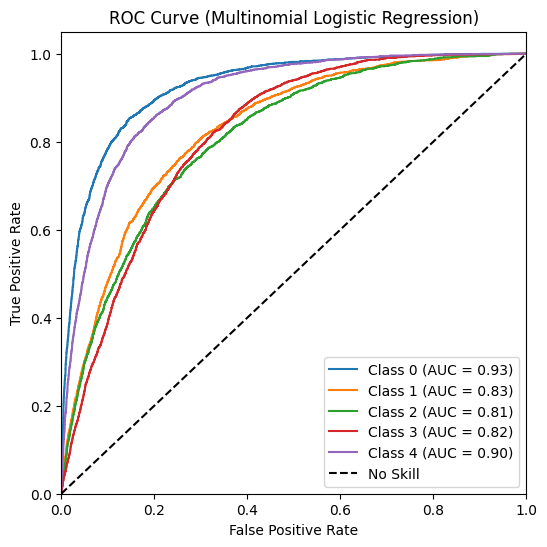

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc


# Create a multinomial logistic regression classifier
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the classifier
classifier.fit(X_train, y_train)

# Predict class labels for test data
y_pred_test = classifier.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, y_pred_test)
print("Accuracy:", accuracy)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(Y_test, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

# ROC Curve and AUC Score
# One-vs-Rest approach for ROC curve (as Multinomial Logistic Regression doesn't directly output probabilities)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classifier.classes_)

for i in range(n_classes):
    y_test_binary = (Y_test == i)  # Binarize for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, classifier.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

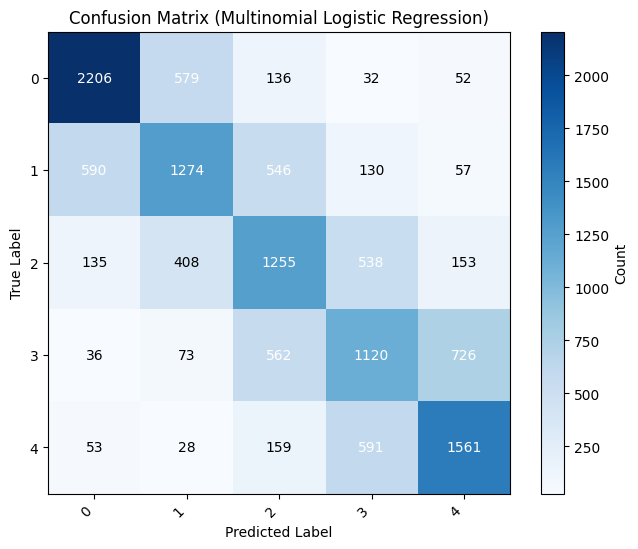

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

Results are really good. So we will investigate Logistic Regression further later by changing embedding. But is there anything we can do more with tokenized data after all these steps?  

In this step we read about POS Tagging in sentiment analysis. We decided to make an analysis that whether POS Tagging can be helpful for our model or not.

In [ ]:
data = {"text":x,"labels":y}
df = pd.DataFrame(data)

In [ ]:
df.head()

text  labels
0  dr goldberg offers everything i look for in a ...       4
1  unfortunately the frustration of being dr gold...       1
2  been going to dr goldberg for over 10 years i ...       3
3  got a letter in the mail last week that said d...       3
4  i do not know what dr goldberg was like before...       0

In [ ]:
import nltk
# Conduct POS Tagging (takes a bit of time to run this code)
pos_tags = (df.text.apply(lambda text: nltk.pos_tag(nltk.word_tokenize(text))))

In [ ]:
def pos_tag_count(list_of_postag):
    # Return dictionary of dataframes with postags as keys and counts as values
    dict_of_postags = {}
    for tag in list_of_postag:
        dict_of_postags[tag[1]] = dict_of_postags.get(tag[1], 0) + 1
    return dict_of_postags
        
postags_df = pd.DataFrame(pos_tags.apply(pos_tag_count).to_dict()).T

In [ ]:
pos_tag_col = [col for col in postags_df.columns if re.findall('[A-Z]+', col)]

postags_df_ = postags_df[pos_tag_col].fillna(0)

In [ ]:
postags_df_.head

<bound method NDFrame.head of          NN  VBZ  VBP    IN    DT    JJ   PRP    CC   TO    VB  ...  JJS   EX  \
0      12.0  5.0  8.0  10.0   4.0   7.0   9.0   4.0  6.0   6.0  ...  0.0  0.0   
1      24.0  9.0  7.0  14.0   9.0  11.0   8.0   3.0  3.0   6.0  ...  0.0  0.0   
2      12.0  7.0  2.0  14.0   7.0   9.0   7.0   6.0  2.0   4.0  ...  0.0  0.0   
3      11.0  1.0  1.0   6.0   5.0   7.0   2.0   0.0  3.0   5.0  ...  0.0  0.0   
4      36.0  7.0  8.0  19.0  24.0  13.0  17.0  10.0  7.0  19.0  ...  0.0  0.0   
...     ...  ...  ...   ...   ...   ...   ...   ...  ...   ...  ...  ...  ...   
29995   5.0  1.0  2.0   2.0   4.0   2.0   1.0   3.0  1.0   1.0  ...  0.0  0.0   
29996  42.0  4.0  6.0  18.0  24.0  13.0   3.0   7.0  1.0   5.0  ...  3.0  2.0   
29997  24.0  4.0  6.0  18.0  12.0  11.0   4.0   5.0  2.0   5.0  ...  0.0  1.0   
29998  14.0  3.0  1.0   5.0  10.0  14.0   4.0   6.0  2.0   5.0  ...  0.0  0.0   
29999  22.0  2.0  6.0  12.0   9.0   8.0   9.0   4.0  4.0   6.0  ...  0.0  0.0  

In [ ]:
pt_df = postags_df_
import seaborn as sns
pt_df['0'] = pd.get_dummies(df.labels)[0]
pt_df['1'] = pd.get_dummies(df.labels)[1]
pt_df['2'] = pd.get_dummies(df.labels)[2]
pt_df['3'] = pd.get_dummies(df.labels)[3]
pt_df['4'] = pd.get_dummies(df.labels)[4]

In [ ]:
pt_df.corr()[['0','1','2','3','4']]

0         1         2         3         4
NN    0.061131  0.058885  0.003624 -0.038499 -0.089251
VBZ  -0.044270  0.012891  0.042756  0.021452 -0.034754
VBP  -0.005431  0.019128  0.002538  0.005764 -0.023065
IN    0.076849  0.069558  0.007276 -0.049366 -0.109376
DT    0.056698  0.071544  0.015575 -0.039708 -0.109249
JJ   -0.044713  0.045126  0.042266  0.016934 -0.062883
PRP   0.135931  0.056085 -0.025560 -0.075824 -0.094698
CC    0.021868  0.051673  0.013056 -0.021438 -0.068454
TO    0.151342  0.062274 -0.032089 -0.085674 -0.100126
VB    0.148402  0.065715 -0.020876 -0.087701 -0.110384
VBG   0.116000  0.061038 -0.025648 -0.070769 -0.084286
RB    0.087257  0.088405  0.007437 -0.068926 -0.119826
PRP$  0.132841  0.032868 -0.047758 -0.073269 -0.046390
NNS   0.014247  0.038213  0.018464 -0.009066 -0.064956
VBN   0.127063  0.074838 -0.036074 -0.073343 -0.096619
WDT   0.013707  0.061398  0.020860 -0.020780 -0.079058
MD    0.119335  0.058421 -0.005890 -0.076603 -0.099781
WP    0.103850  0.046679 -0.023283 -0.065368 -0.064676
RBR  -0.010310  0.065661  0.030881 -0.025847 -0.063803
CD    0.124815  0.064332 -0.018181 -0.063637 -0.112206
WRB   0.125682  0.056771 -0.031959 -0.070793 -0.083222
VBD   0.155428  0.104476 -0.023548 -0.103767 -0.138839
PDT   0.002935  0.024043  0.001713 -0.005774 -0.024076
RP    0.102524  0.053008 -0.019062 -0.049612 -0.090753
JJR   0.013151  0.072413  0.030318 -0.032749 -0.087562
JJS  -0.000557 -0.001014 -0.012787 -0.020865  0.036803
EX    0.043014  0.049923  0.017189 -0.030691 -0.083391
RBS  -0.012251  0.013556 -0.011816 -0.008201  0.019526
NNP  -0.005704 -0.007813  0.001334  0.003025  0.009586
FW   -0.013063  0.001626  0.007936  0.007983 -0.004757
WP$   0.021969 -0.008311  0.004520 -0.014445 -0.003927
UH    0.025651 -0.002825 -0.010775 -0.010218 -0.001786
NNPS -0.005314 -0.005449  0.007292  0.003428  0.000003
POS   0.004436 -0.009300 -0.000398  0.004511  0.000863
SYM   0.001368  0.001257  0.008270 -0.005792 -0.005443
0     1.000000 -0.256562 -0.258835 -0.252660 -0.237428
1    -0.256562  1.000000 -0.261691 -0.255449 -0.240048
2    -0.258835 -0.261691  1.000000 -0.257712 -0.242174
3    -0.252660 -0.255449 -0.257712  1.000000 -0.236398
4    -0.237428 -0.240048 -0.242174 -0.236398  1.000000

Using seaborn library we created POS Tags of the words. Then we try to find if there is a correlation between labels and POS Tags.

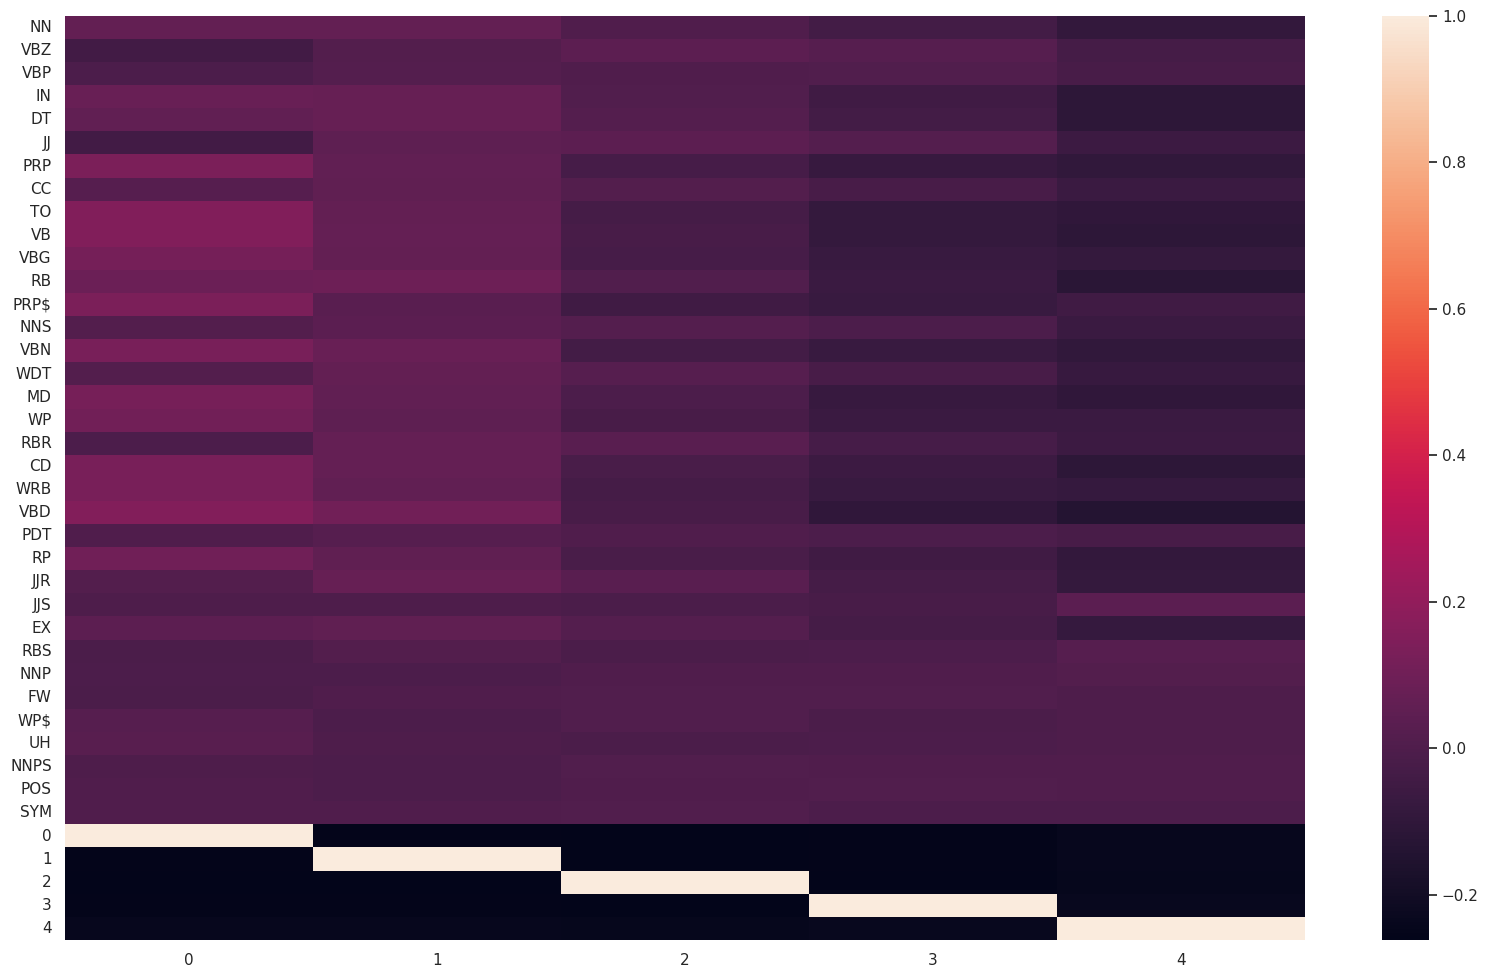

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(20,12))
sns.heatmap(pt_df.corr()[['0','1','2','3','4']])
plt.show()

**One can say that as rate increases, number of pos tags also increases. Eventhough it is true, there is still lower correlation between them (Look the values below). So we avoid to use POS Tagging.**

In [ ]:
import pandas as pd

# Example DataFrame
df = corr_matrix

# Find the max value in each row
max_values_per_row = df.max(axis=1)
print("Max values in each row:")
print(max_values_per_row)



Max values in each row:
NN      0.061131
VBZ     0.042756
VBP     0.019128
IN      0.076849
DT      0.071544
JJ      0.045126
PRP     0.135931
CC      0.051673
TO      0.151342
VB      0.148402
VBG     0.116000
RB      0.088405
PRP$    0.132841
NNS     0.038213
VBN     0.127063
WDT     0.061398
MD      0.119335
WP      0.103850
RBR     0.065661
CD      0.124815
WRB     0.125682
VBD     0.155428
PDT     0.024043
RP      0.102524
JJR     0.072413
JJS     0.036803
EX      0.049923
RBS     0.019526
NNP     0.009586
FW      0.007983
WP$     0.021969
UH      0.025651
NNPS    0.007292
POS     0.004511
SYM     0.008270
0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       1.000000
dtype: float64


So finally we are sure about the text representation of our data. But what about the embeddings? The CountVectorizer is very fast and interpretable, however it is very trivial. We have used TF-IDF Vectorizer to represent better text data.


TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It is commonly used in information retrieval and text mining to transform text data into numerical representations, making it suitable for machine learning algorithms. 

In [ ]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 2022)

We also find bigrams in our vectorizer.
A bigram is a sequence of two adjacent elements from a string of tokens, which are typically words in the context of natural language processing (NLP). Bigrams are a type of n-gram, where n represents the number of elements in the sequence. While unigrams are single words, bigrams consist of pairs of consecutive words.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df=10)
vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_val)
X_train.toarray()
X_test.toarray()
Y_train = np.array(y_train)
Y_test = np.array(y_val)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,f1_score


# Create a multinomial logistic regression classifier
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)

# Train the classifier
classifier.fit(X_train, Y_train)


LogisticRegression(max_iter=1000, multi_class='multinomial')

Accuracy: 0.5991538461538461
F1-Score: 0.5916673462878368
Confusion Matrix:
 [[2365  519   70   19   32]
 [ 632 1355  478   85   47]
 [ 146  495 1243  493  112]
 [  69  109  492 1255  592]
 [  77   45   99  600 1571]]


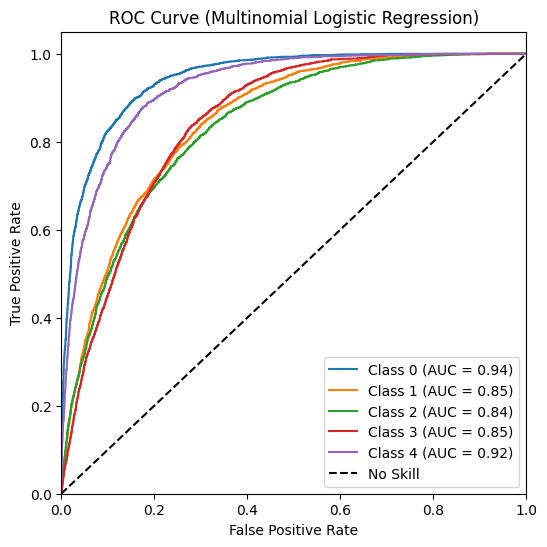

In [ ]:
# Predict class labels for test data
y_pred_test = classifier.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, y_pred_test)
print("Accuracy:", accuracy)
f1_score = f1_score(Y_test, y_pred_test, average='macro')
print("F1-Score:", f1_score)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(Y_test, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

# ROC Curve and AUC Score
# One-vs-Rest approach for ROC curve (as Multinomial Logistic Regression doesn't directly output probabilities)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classifier.classes_)

for i in range(n_classes):
    y_test_binary = (Y_test == i)  # Binarize for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, classifier.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

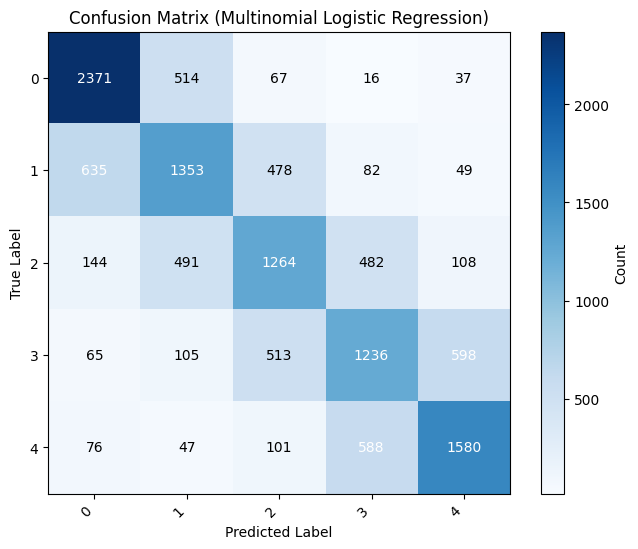

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

**For Test set**

In [ ]:
X_test_test = test_df['text']
Y_test_test = test_df['label']
X_test_test_preprocessed = []
for text in X_test_test:
    X_test_test_preprocessed.append(preprocess(text))
X_test_test = X_test_test_preprocessed
x_test = vectorizer.transform(X_test_test)
x_test.toarray()
y_test = np.array(Y_test_test)

Accuracy: 0.58456
F1-Score: 0.5842360995582105
Confusion Matrix:
 [[7532 2040  213   96  119]
 [2329 5312 1879  343  137]
 [ 541 2261 4980 1848  370]
 [ 208  437 2205 5103 2047]
 [ 276  149  444 2830 6301]]


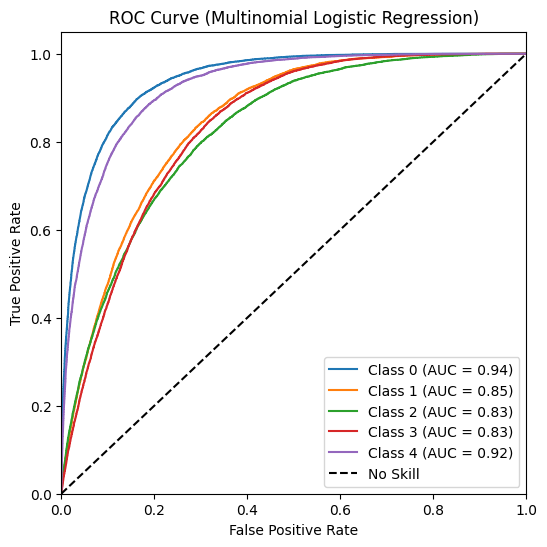

In [ ]:
# Predict class labels for test data
y_pred_test = classifier.predict(x_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)
f1_score = metrics.f1_score(y_test, y_pred_test, average='macro')
print("F1-Score:", f1_score)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

# ROC Curve and AUC Score
# One-vs-Rest approach for ROC curve (as Multinomial Logistic Regression doesn't directly output probabilities)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classifier.classes_)

for i in range(n_classes):
    y_test_binary = (y_test == i)  # Binarize for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, classifier.predict_proba(x_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

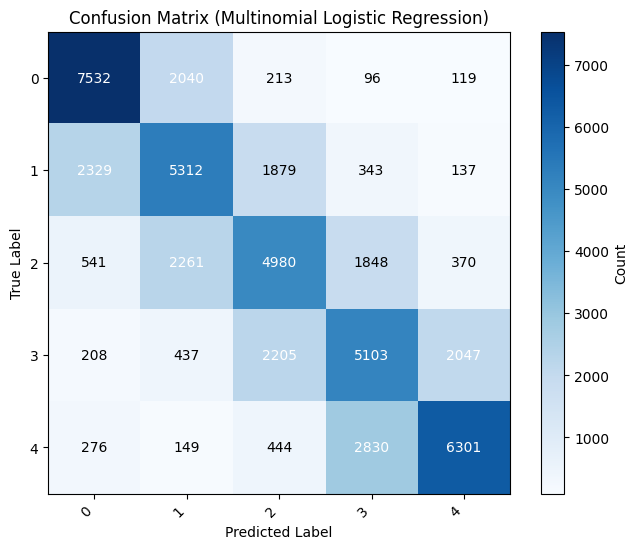

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

Logistic Regression with TF-IDF Vectorizer gives better result than Count Vectorizer. Especially for reviews with 0 label, it gives way better accuracy.

#### WORD2VEC Embedding

Without implementing further models, we have focused on Word2Vec and using it as embedding to our training model.

Word2Vec is a popular technique in natural language processing (NLP) that transforms words into numerical vectors in a continuous vector space. Developed by a team of researchers led by Tomas Mikolov at Google in 2013, Word2Vec captures semantic and syntactic relationships between words based on their context in a large corpus of text. The resulting word embeddings (vector representations) can then be used in various NLP tasks.

##### Training Process

- Corpus Preparation: A large corpus of text is collected and preprocessed. This involves tokenization, removal of stop words, and possibly stemming or lemmatization.

- Context Window: A sliding window is used to define the context of each word. For example, with a window size of 2, the context of a word includes the two words before and after it.

- Model Training: The neural network is trained to maximize the probability of context words given a target word (Skip-gram) or a target word given context words (CBOW). The training adjusts the weights of the neural network, which correspond to the word vectors.

Advantages:
* Semantic Similarity: Words with similar meanings tend to have similar vectors, enabling semantic understanding.
* Efficient Computation: The models are relatively simple and can be trained efficiently on large datasets.
* Transfer Learning: Pre-trained Word2Vec models can be fine-tuned for specific NLP tasks, reducing the need for extensive retraining.

We have creted different word2vec models changing configurations such as window size, vector size etc. All the models are available on the Github Repository.

In [ ]:
from gensim.models import Word2Vec

data = []
for sentence in x:
    data.append(sentence.split())

# Define Word2Vec parameters
vector_size = 256  # Dimensionality of the word vectors, we use 100, 256 and 512
window = 5  # Maximum distance between the current and predicted word within a sentence
min_count = 10  # Ignores all words with a total frequency lower than this, we use 1 and 10
sg = 1  # Training algorithm: CBOW (0) or skip-gram (1)

# Train Word2Vec model
model = Word2Vec(sentences=data, vector_size=vector_size, window=window, min_count=min_count, sg=sg)

# Optionally train for more epochs
# model.train(data, total_examples=model.corpus_count, epochs=10)
# Save the trained model to a file
model.save('word2vec_model.bin')


The codes above contains examples from with configuration:
vector_size = 256
window=5
min_count=10
sg=1
The examples from other models is stated.

##### Similar Words, Analogies and Other Experiments

Let's find similar words.

In [ ]:
# Find similar words
similar_words_amazing = model.wv.most_similar('amazing')
similar_words_terrible = model.wv.most_similar('terrible')

In [ ]:
similar_words_amazing

[('incredible', 0.8868997693061829),
 ('awesome', 0.884756863117218),
 ('fantastic', 0.852196455001831),
 ('phenomenal', 0.8384959697723389),
 ('fabulous', 0.786296546459198),
 ('outstanding', 0.7801915407180786),
 ('wonderful', 0.7527675628662109),
 ('excellent', 0.7492627501487732),
 ('superb', 0.7274727821350098),
 ('terrific', 0.7265809178352356)]

In [ ]:
similar_words_terrible

[('horrible', 0.9425191879272461),
 ('awful', 0.8715782165527344),
 ('horrendous', 0.8070825338363647),
 ('horrid', 0.8062782883644104),
 ('lousy', 0.7586703896522522),
 ('atrocious', 0.7233906388282776),
 ('horrific', 0.6967999935150146),
 ('aweful', 0.6909676790237427),
 ('dreadful', 0.6837438941001892),
 ('bad', 0.6736840605735779)]

In [ ]:
# Find similar words
similar_words = model.wv.most_similar('sushi', topn=5)
print('Similar words to "sushi":', similar_words)

# Calculate cosine similarity between two words
similarity_score = model.wv.similarity('italian', 'sushi')
print('Cosine similarity between "italian" and "sushi":', similarity_score)

# Calculate cosine similarity between two words
similarity_score = model.wv.similarity('italian', 'pizza')
print('Cosine similarity between "italian" and "pizza":', similarity_score)

# Calculate cosine similarity between two words
similarity_score = model.wv.similarity('japanese', 'sushi')
print('Cosine similarity between "japanese" and "sushi":', similarity_score)

# Calculate cosine similarity between two words
similarity_score = model.wv.similarity('japanese', 'pizza')
print('Cosine similarity between "japanese" and "pizza":', similarity_score)


Similar words to "sushi": [('sashimi', 0.7559454441070557), ('nigiri', 0.7263278365135193), ('ayce', 0.713910698890686), ('maki', 0.6613011956214905), ('sushis', 0.6272545456886292)]
Cosine similarity between "italian" and "sushi": 0.26738885
Cosine similarity between "italian" and "pizza": 0.4306146
Cosine similarity between "japanese" and "sushi": 0.52857655
Cosine similarity between "japanese" and "pizza": 0.118901804


As we expected, "italian" and "pizza" are very similar. "Japanese" and "sushi" are have more similarity. For sushi-italian and pizza-italian, scores are lower.

Analogy tasks with Word2Vec involve finding relationships between words based on their vector representations. The idea is that the relationships captured by the vectors in the embedding space can be used to solve analogy problems, such as "man is to king as woman is to queen." Word2Vec models learn these relationships during training, and the resulting embeddings can be used to perform such tasks effectively.

In [ ]:

analogy1 = model.wv.most_similar(positive=['wine', 'malt'], negative=['grape'], topn=3)
print('1. Analogy: wine - grape + malt =', analogy1[0])

analogy1 = model.wv.most_similar(positive=['pesto', 'tomato'], negative=['basil'], topn=3)
print('1. Analogy: pesto - basil + tomato =', analogy1[0])



1. Analogy: wine - grape + malt = ('beer', 0.5273988842964172)
1. Analogy: pesto - basil + tomato = ('sundried', 0.6006603240966797)


<img src="https://www.thespruceeats.com/thmb/N9TEoqtQz-R9zkjMXM8I530sj30=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/red-wine-is-poured-into-a-glass-from-a-bottle--light-background--1153158143-98320451802c485cb6d7b5437c7fd60a.jpg" alt="drawing" width="100"/> <img src="https://static.vecteezy.com/system/resources/previews/000/380/520/original/minus-vector-icon.jpg" alt="drawing" width="100"/> <img src="https://img.imageboss.me/fourwinds/width/425/dpr:2/shop/products/blackmonukka.jpg?v=1538780984" alt="drawing" width="100"/> <img src="https://t4.ftcdn.net/jpg/01/26/10/59/360_F_126105961_6vHCTRX2cPOnQTBvx9OSAwRUapYTEmYA.jpg" alt="drawing" width="100"/> <img src="https://upload.wikimedia.org/wikipedia/commons/9/98/Gr%C3%BCnmalz.jpg" alt="drawing" width="100"/> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMEfkQITJ-uqEIX76ghbK8OeHLF5Bvbks2L8RzmKJY3g&s" alt="drawing" width="100"/> <img src="https://static.toiimg.com/thumb/93353895.cms?width=400&height=300&resizemode=4&imgsize=54288" alt="drawing" width="100"/> 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c9/BasilPesto.JPG" alt="drawing" width="100"/> <img src="https://static.vecteezy.com/system/resources/previews/000/380/520/original/minus-vector-icon.jpg" alt="drawing" width="100"/> <img src="https://www.clickandgrow.com/cdn/shop/products/Basil_plant_1280x960_0fc95446-605c-49e3-aa42-c6f3a171b8ae.jpg" alt="drawing" width="100"/> <img src="https://t4.ftcdn.net/jpg/01/26/10/59/360_F_126105961_6vHCTRX2cPOnQTBvx9OSAwRUapYTEmYA.jpg" alt="drawing" width="100"/> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Tomato_je.jpg/1200px-Tomato_je.jpg" alt="drawing" width="100"/> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMEfkQITJ-uqEIX76ghbK8OeHLF5Bvbks2L8RzmKJY3g&s" alt="drawing" width="100"/> <img src="https://www.budgetbytes.com/wp-content/uploads/2012/08/Not-Sun-Dried-Tomato-Sauce-front.jpg" alt="drawing" width="100"/> 

With the Word2Vec model with 512 vector size, second one becomes "marinara":

In [ ]:

analogy1 = model.wv.most_similar(positive=['wine', 'malt'], negative=['grape'], topn=3)
print('1. Analogy: wine - grape + malt =', analogy1[0])

analogy1 = model.wv.most_similar(positive=['pesto', 'tomato'], negative=['basil'], topn=3)
print('1. Analogy: pesto - basil + tomato =', analogy1[0])



1. Analogy: wine - grape + malt = ('beer', 0.6625512838363647)
1. Analogy: pesto - basil + tomato = ('marinara', 0.7865259647369385)


<img src="https://upload.wikimedia.org/wikipedia/commons/c/c9/BasilPesto.JPG" alt="drawing" width="100"/> <img src="https://static.vecteezy.com/system/resources/previews/000/380/520/original/minus-vector-icon.jpg" alt="drawing" width="100"/> <img src="https://www.clickandgrow.com/cdn/shop/products/Basil_plant_1280x960_0fc95446-605c-49e3-aa42-c6f3a171b8ae.jpg" alt="drawing" width="100"/> <img src="https://t4.ftcdn.net/jpg/01/26/10/59/360_F_126105961_6vHCTRX2cPOnQTBvx9OSAwRUapYTEmYA.jpg" alt="drawing" width="100"/> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Tomato_je.jpg/1200px-Tomato_je.jpg" alt="drawing" width="100"/> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMEfkQITJ-uqEIX76ghbK8OeHLF5Bvbks2L8RzmKJY3g&s" alt="drawing" width="100"/> <img src="https://i2.wp.com/www.downshiftology.com/wp-content/uploads/2019/06/Marinara-Sauce-main.jpg" alt="drawing" width="100"/> 

In [ ]:
# Find similar words
similar_words = model.wv.most_similar('sushi', topn=5)
print('Similar words to "sushi":', similar_words)

Similar words to "sushi": [('sashimi', 0.7559454441070557), ('nigiri', 0.7263278365135193), ('ayce', 0.713910698890686), ('maki', 0.6613011956214905), ('sushis', 0.6272545456886292)]


In [ ]:
# Find similar words
similar_words = model.wv.most_similar('italian', topn=5)
print('Similar words to "italian":', similar_words)

Similar words to "italian": [('mexican', 0.6268699169158936), ('mediterranean', 0.6218019127845764), ('stallion', 0.6103924512863159), ('greek', 0.6076419353485107), ('asian', 0.5981730222702026)]


In [ ]:
# Word frequencies
word_freq = model.wv.key_to_index
most_common_words = sorted(word_freq, key=word_freq.get, reverse=False)[:10]
print('Most common words:', most_common_words)

Most common words: ['the', 'and', 'i', 'a', 'to', 'was', 'it', 'is', 'of', 'not']


Then we viusalized the vector space with T-SNE. Contrary to methods we did in data exploration part such as k-means, T-SNE result seems more meaningful in the 3-D Space. This encourage us to use these embeddings in Logistic Regression and SVM.

In [ ]:
def get_average_word2vec(sentence):
    word_vectors = []
    for word in sentence.split():
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if len(word_vectors)>0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assuming you have a list of sentences and their corresponding labels
sentences = x  # List of sentences
labels = y  # List of corresponding labels

# Convert labels to numeric values
label_to_numeric = {label: i for i, label in enumerate(set(labels))}
numeric_labels = np.array([label_to_numeric[label] for label in labels])

In [ ]:
# Convert sentences to their corresponding Word2Vec embeddings
sentence_vectors = []
for sentence in sentences[:10000]:
    # Assuming you have a function to convert each sentence to its Word2Vec embedding
    vector = get_average_word2vec(sentence)  # Example function to get Word2Vec embedding
    sentence_vectors.append(vector)

sentence_vectors = np.array(sentence_vectors)

# Perform t-SNE
tsne = TSNE(n_components=3, random_state=42)
vectors_3d = tsne.fit_transform(sentence_vectors)



<Figure size 1000x800 with 0 Axes>

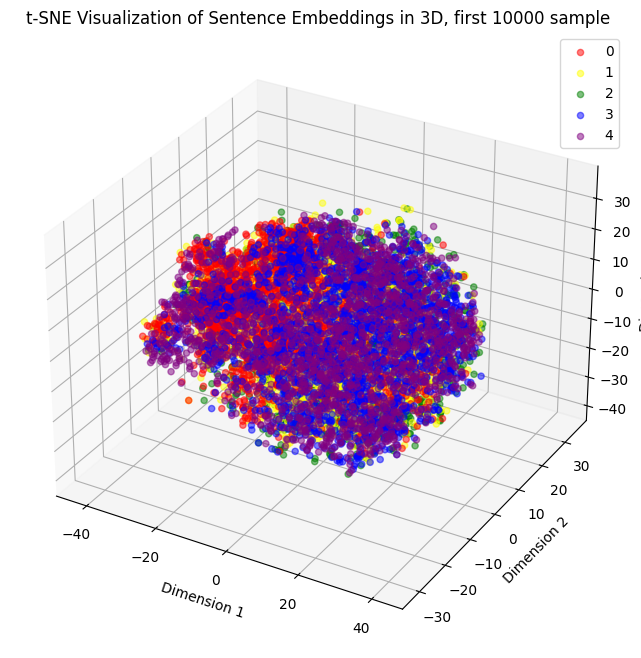

In [ ]:
# Plot
label_colors = {"0":"red","1":"yellow","2":"green","3":"blue","4":"purple"}
plt.figure(figsize=(10, 8))
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
numeric_labels = numeric_labels[:10000]
for label, color in label_colors.items():
    indices = numeric_labels == label_to_numeric[int(label)]
    ax.scatter(vectors_3d[indices, 0], vectors_3d[indices, 1], vectors_3d[indices, 2], c=color, label=label, alpha=0.5)

ax.set_title('t-SNE Visualization of Sentence Embeddings in 3D, first 10000 sample')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()

Below visual is from the model with vector size 512:

<Figure size 1000x800 with 0 Axes>

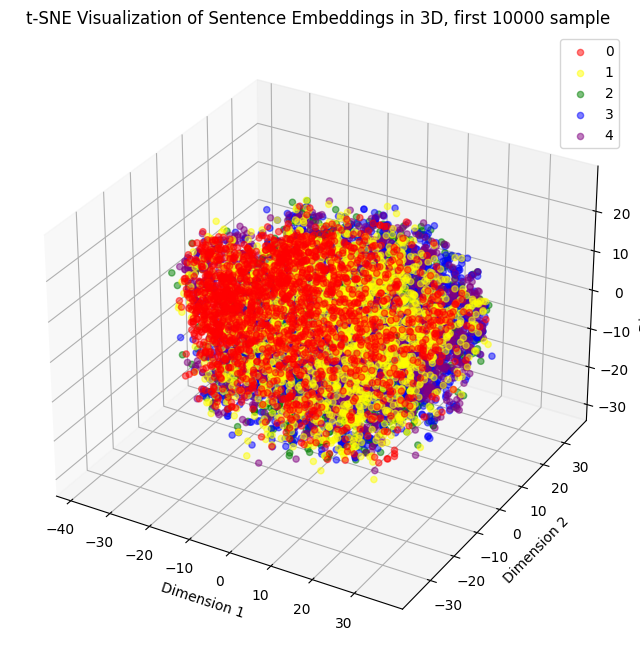

In [ ]:
# Plot
label_colors = {"0":"red","1":"yellow","2":"green","3":"blue","4":"purple"}
plt.figure(figsize=(10, 8))
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
numeric_labels = numeric_labels[:10000]
for label, color in label_colors.items():
    indices = numeric_labels == label_to_numeric[int(label)]
    ax.scatter(vectors_3d[indices, 0], vectors_3d[indices, 1], vectors_3d[indices, 2], c=color, label=label, alpha=0.5)

ax.set_title('t-SNE Visualization of Sentence Embeddings in 3D, first 10000 sample')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()

In [ ]:
# Find similar words
similar_words = model.wv.similar_by_word('patronizing', topn=5)
print('Similar words to "patronizing":', similar_words)

Similar words to "patronizing": [('frequenting', 0.5402674674987793), ('patronize', 0.5291619300842285), ('unproffesional', 0.5280306935310364), ('behaviour', 0.5170702934265137), ('unkind', 0.511965274810791)]


In [ ]:
query = "The stuff is rude.Their attitude is so bad"
query_vector = get_average_word2vec(query)
similar_sentences = []
for sentence in x[:65000]:
    sentence_vector = get_average_word2vec(sentence)
    similarity_score = np.dot(query_vector, sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(sentence_vector))
    similar_sentences.append((sentence, similarity_score))
similar_sentences = sorted(similar_sentences, key=lambda x: x[1], reverse=True)[:5]
print("Top similar sentences:")
for sentence, score in similar_sentences:
    print(f"- {sentence} (Similarity: {score})")

/tmp/ipykernel_33/3910004658.py:6: RuntimeWarning: invalid value encountered in scalar divide
  similarity_score = np.dot(query_vector, sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(sentence_vector))


Top similar sentences:
- awful  food is bad and there is nogood service  (Similarity: 0.8291990756988525)
- bad attitudes from the workers  the food is not that great to put up with the mood of this place  this is not like the soup nazi from seinfeld  sometimes the place is open and sometimes it is not which makes for crappy business  (Similarity: 0.8150925040245056)
- this place is dirty  the owner is miserable and the food is terrible  it is amazing they have been in business this long  (Similarity: 0.8122240304946899)
- food is good but beware of racial bias  bad attitudes  if your skin color is darker than the mongloids running the place expect bad attitudes  the midget that works the drive thru window was the worse  but she is better now  still will not give me eye contact  the younger ore american girl that works there has always been nice    but funny  (Similarity: 0.8067569732666016)
- it is very inconsistent here in terms of barista skills  unfortunately  sometimes i get a gre

In [ ]:
query = "Italian restaurant with great ambiance"
query_vector = get_average_word2vec(query)
similar_sentences = []
for sentence in x[:65000]:
    sentence_vector = get_average_word2vec(sentence)
    similarity_score = np.dot(query_vector, sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(sentence_vector))
    similar_sentences.append((sentence, similarity_score))
similar_sentences = sorted(similar_sentences, key=lambda x: x[1], reverse=True)[:5]
print("Top similar sentences:")
for sentence, score in similar_sentences:
    print(f"- {sentence} (Similarity: {score})")


/tmp/ipykernel_33/1729701784.py:6: RuntimeWarning: invalid value encountered in scalar divide
  similarity_score = np.dot(query_vector, sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(sentence_vector))


Top similar sentences:
- great ambience and food  (Similarity: 0.8416973352432251)
- the food was excellent  the ambiance cozy   great for date night  (Similarity: 0.8380798101425171)
- great restaurant with great food nice wine  the inside ambience is good but there is no nice view of the city  (Similarity: 0.8358926177024841)
- great thai food   ambiance is great  good service  great food  (Similarity: 0.8319563269615173)
- great service  food was good bar food nice atmosphere  great place to chill and have a beer  (Similarity: 0.8269951939582825)


We developed a Logictic Regression Model with the help of Word2Vec embedding.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 2022)

In [ ]:
# Assuming you have a list of sentences and their corresponding labels
sentences = x_train  # List of sentences
labels = y_train  # List of corresponding labels

# Convert labels to numeric values
label_to_numeric = {label: i for i, label in enumerate(set(labels))}
numeric_labels = np.array([label_to_numeric[label] for label in labels])

In [ ]:
# Convert sentences to their corresponding Word2Vec embeddings
sentence_vectors = []
for sentence in sentences:
    # Assuming you have a function to convert each sentence to its Word2Vec embedding
    vector = get_average_word2vec(sentence)  # Example function to get Word2Vec embedding
    sentence_vectors.append(vector)

sentence_vectors = np.array(sentence_vectors)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc


# Create a multinomial logistic regression classifier
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)

# Train the classifier
classifier.fit(sentence_vectors, labels)

# Predict class labels for test data
y_pred_test = classifier.predict(val_sentence_vectors)

# Calculate Accuracy
accuracy = accuracy_score(y_val, y_pred_test)
print("Accuracy:", accuracy)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(y_val, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

Accuracy: 0.5862538461538461
Confusion Matrix:
 [[19511  5318   667   196   365]
 [ 5753 13659  5207   758   438]
 [ 1209  5688 12915  4963  1167]
 [  411  1082  5872 12749  6125]
 [  531   426  1201  6410 17379]]


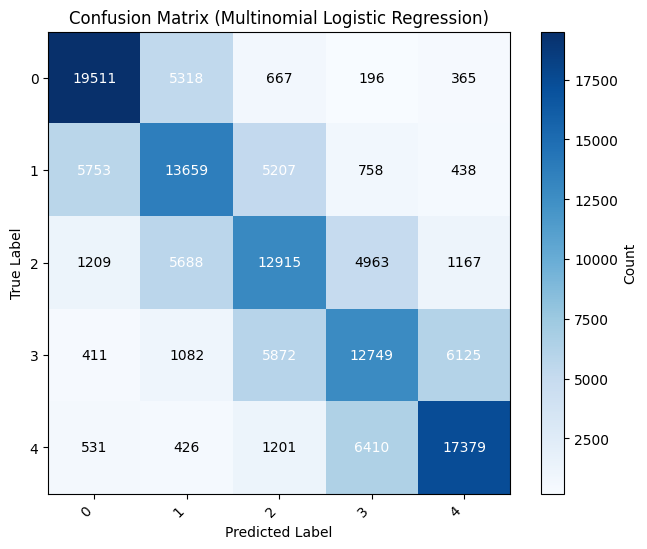

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

Lastly, we use Word2Vec with TF-IDF Vectorizer. TF_IDF Weighted Word2Vec Logistic Regression give worse result than what we expected. As a future work, one may can work on this method. We hace reached %54 accuracy with this kind of model. (You can find the notebook on repository. Below you can find vector calculation code).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=10)
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

# Get the vocabulary and the tf-idf scores
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()
feature_names_dict = {}
for i, name in enumerate(tfidf_feature_names.tolist()):
    feature_names_dict[name] = i

# Function to create TF-IDF weighted Word2Vec embedding for a document
def create_embedding(document, model, tfidf_vectorizer, tfidf_scores, feature_names_dict, i):
    words = document.split()
    doc_embedding = np.zeros(model.vector_size)
    weighted_sum = 0
    
    for word in words:
        if word in model.wv:
            tfidf_index = feature_names_dict[word] if word in feature_names_dict else -1
            if tfidf_index != -1:
                tfidf_score = tfidf_scores[tfidf_index]
                word_embedding = model.wv[word]
                doc_embedding += word_embedding * tfidf_score
                weighted_sum += tfidf_score

    if weighted_sum != 0:
        doc_embedding /= weighted_sum

    return doc_embedding
    

#### SVM

Support Vector Machine (SVM) is a powerful supervised learning algorithm used for classification and regression tasks in machine learning. It is particularly well-suited for binary classification problems but can be extended to handle multi-class classification as well.

Key Concepts of SVM
* Hyperplane: In SVM, a hyperplane is a decision boundary that separates data points of different classes. In two dimensions, this is a line; in three dimensions, it is a plane; and in higher dimensions, it is called a hyperplane.

* Support Vectors: Support vectors are the data points that are closest to the hyperplane and thus are the most difficult to classify. These points are critical as they define the position and orientation of the hyperplane.

* Margin: The margin is the distance between the hyperplane and the nearest support vectors of any class. SVM aims to maximize this margin, leading to a decision boundary that is as far away from the closest data points of any class as possible. This is known as the maximum margin classifier.



We have used the embeddings above with SVM.

Radial Basis Function(RBF) kernel is needed when the data is really unevenly distributed. So we use poly kernel.

In [ ]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


In [ ]:
poly = svm.SVC(kernel='poly', degree=3, C=1,verbose=True).fit(sentence_vectors[:65000], labels[:65000])

[LibSVM]...........*..*.*
optimization finished, #iter = 13823
obj = -14637.241142, rho = -0.844666
nSV = 15609, nBSV = 15181
.......*..*.*
optimization finished, #iter = 9405
obj = -7744.039311, rho = -0.269098
nSV = 8889, nBSV = 8493
....
*..*
optimization finished, #iter = 6006
obj = -4465.473865, rho = -0.633883
nSV = 5579, nBSV = 5228
....*.*.*
optimization finished, #iter = 5763
obj = -3806.624718, rho = -0.075940
nSV = 4848, nBSV = 4522
............*.
*.*
optimization finished, #iter = 14435
obj = -16088.882707, rho = 1.027395
nSV = 17192, nBSV = 16766
........*.*
optimization finished, #iter = 9482
obj = -8536.812691, rho = 0.719639
nSV = 9873, nBSV = 9500
.....*.*
optimization finished, #iter = 6405
obj = -5492.025257, rho = 0.934755
nSV = 6671, nBSV = 6338
............*.*
optimization finished, #iter = 13820
obj = -16299.600256, rho = 0.282674
nSV = 17448, nBSV = 16969
........*..*.*
optimization finished, #iter = 10879
obj = -9115.197410, rho = 0.720638
nSV = 10322, nBSV = 9

In [ ]:
y_pred_test = poly.predict(val_sentence_vectors[:10000])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [ ]:
# Calculate Accuracy
accuracy = accuracy_score(y_val[:10000], y_pred_test)
print("Accuracy:", accuracy)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(y_val[:10000], y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

f1_score = f1_score(y_val[:10000], y_pred_test, average='weighted')
print('F1 (Polynomial Kernel): ', "%.2f" % (f1_score*100))

Accuracy: 0.5783
Confusion Matrix:
 [[1468  440   64   14   27]
 [ 460 1010  421   59   32]
 [  95  446  950  402   61]
 [  31   83  451 1098  417]
 [  31   52   97  534 1257]]
F1 (Polynomial Kernel):  57.90


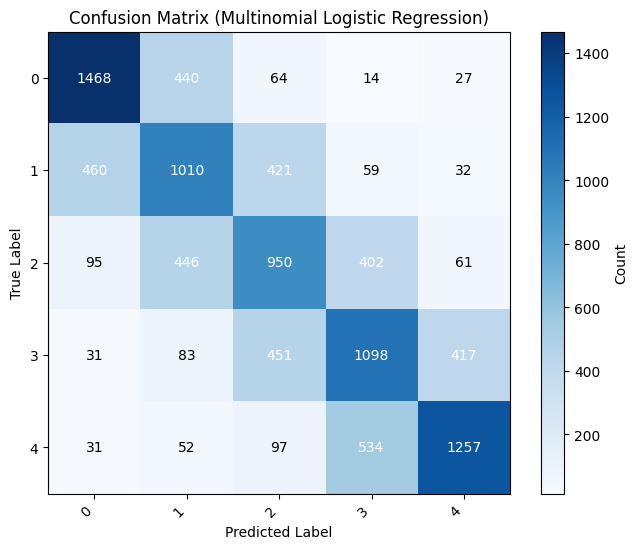

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(5)]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

It gives similar result to Logistic Regression. This makes us to think about our representation of data because at least we hope to reach %60 accuracy. So later in the notebook we have focused on the Deep Learning methods to achive better precision and F1-score.

### Training Steps

So far, we focused on logistic regression and SVM. Also we analyzed some vector embeddings with Word2Vec or similar methods.

Now, we are starting to use some state of the art language models based on neural networks and transformers.

BERT, which stands for Bidirectional Encoder Representations from Transformers, is a state-of-the-art model in the field of natural language processing (NLP). Developed by researchers at Google, BERT has significantly advanced the capabilities of NLP models, enabling them to better understand the context of words in a sentence.

##### Key Features of BERT:

**Bidirectional Context Understanding**: Unlike traditional models that read text either left-to-right or right-to-left, BERT reads text in both directions simultaneously. This bidirectional approach allows BERT to understand the context of a word based on its surroundings, leading to more accurate interpretations of meaning.

**Transformer Architecture**: BERT is based on the Transformer architecture, which utilizes self-attention mechanisms to process input data. This architecture allows BERT to weigh the importance of different words in a sentence dynamically, enhancing its understanding of complex linguistic structures.

**Pre-training**: BERT is initially trained on a large corpus of text using two unsupervised tasks:
Masked Language Modeling (MLM): In this task, random words in a sentence are masked, and the model learns to predict the masked words based on the context provided by the surrounding words.
Next Sentence Prediction (NSP): This task involves predicting whether a given sentence follows another sentence, helping the model understand relationships between sentences.

**Fine-tuning**: After pre-training, BERT can be fine-tuned on specific tasks such as question answering, sentiment analysis, or named entity recognition by adding a small layer on top of the pre-trained model and training it on task-specific data.

**Transfer Learning**: BERT's pre-trained models can be fine-tuned on a wide range of NLP tasks with relatively small task-specific datasets. This transfer learning capability has made BERT highly versatile and effective across various applications.

For more information, go to [paper](https://arxiv.org/abs/1810.04805)

Let's start to investigate our models step by step.

#### Baseline

This is our first model without doing anything fancy. We have used 'bert-base-uncased' tokenizer. 

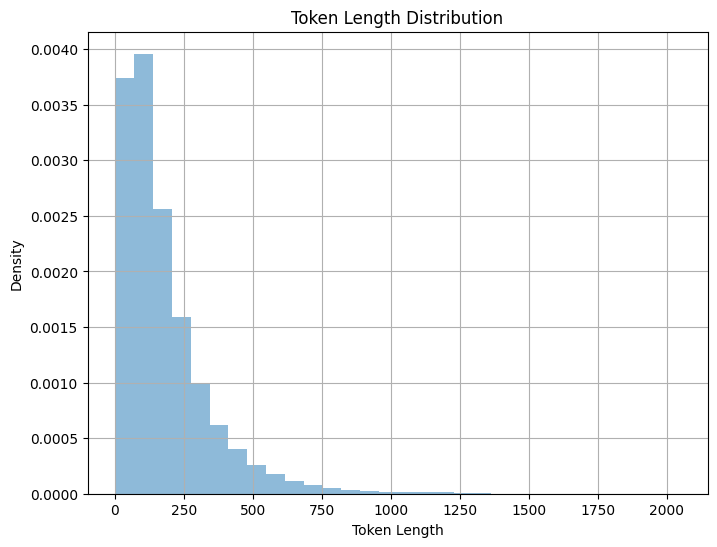

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 6))
train_dataset["token_lengths"].hist(bins=30, density=True, alpha=0.5)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Density")
plt.show()

In [ ]:
import torch
from datasets import load_dataset
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import torch.multiprocessing as mp

if __name__ == "__main__":
    mp.set_sharing_strategy('file_system')
    # Your code here


random_seed = 42
torch.manual_seed(random_seed)

# Load the dataset
dataset = load_dataset("yelp_review_full")

# Create a custom dataset class
class YelpDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data[index]["text"]
        label = self.data[index]["label"]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "token_type_ids": encoding["token_type_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create the dataset and data loader
train_dataset = YelpDataset(dataset["train"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)

# Calculate the size of each part
num_parts = 5
part_size = len(train_dataset) // num_parts

# Process and save each part separately
for i in range(num_parts):
    print(f"Processing Part {i + 1}")
    
    # Define the start and end indices for the current part
    start_index = i * part_size
    end_index = start_index + part_size if i < num_parts - 1 else len(train_dataset)
    
    # Create a subset of the dataset for the current part
    part_dataset = torch.utils.data.Subset(train_dataset, list(range(start_index, end_index)))
    
    # Create a data loader for the current part
    part_loader = DataLoader(part_dataset, batch_size=32, shuffle=True, num_workers=8)
    
    # Process and save the data for the current part
    part_data = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "labels": []
    }

    for batch in tqdm(part_loader, desc=f"Processing Part {i + 1}"):
        part_data["input_ids"].append(batch["input_ids"])
        part_data["token_type_ids"].append(batch["token_type_ids"])
        part_data["attention_mask"].append(batch["attention_mask"])
        part_data["labels"].append(batch["labels"])

    # Convert to tensors
    part_data["input_ids"] = torch.cat(part_data["input_ids"], dim=0)
    part_data["token_type_ids"] = torch.cat(part_data["token_type_ids"], dim=0)
    part_data["attention_mask"] = torch.cat(part_data["attention_mask"], dim=0)
    part_data["labels"] = torch.cat(part_data["labels"], dim=0)

    # Save the data for the current part
    torch.save(part_data, f"yelp_data_part_{i + 1}.pt")

**As you may assume tokenization is a long process so we tokenized the dataset and saved it to files in order to use them in further models. This is our code to tokenize texts. There is no preprocessing at this step.
You can find the tokenizer code on parallel_tokenizer.py and parallel_tokenizer_preprocessing.py files.**

Now, we can start to build our model and training pipeline.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Define the dataset class
class YelpDataset(Dataset):
    def __init__(self, input_ids, token_type_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'token_type_ids': self.token_type_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


Load the training data

In [ ]:
def load_data(is_test=False):
    # Load each part of the dataset
    data_parts = []
    for i in range(1, 6):
        if not is_test:
            part_data = torch.load(f'yelp_data_part_{i}.pt')
        if is_test:
            part_data = torch.load(f'test_yelp_data_part_{i}.pt')
        data_parts.append(part_data)
    return data_parts

data_parts = load_data()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Combine data_parts into a single TensorDataset
full_dataset = TensorDataset(
    torch.cat([part['input_ids'] for part in data_parts]),
    torch.cat([part['token_type_ids'] for part in data_parts]),
    torch.cat([part['attention_mask'] for part in data_parts]),
    torch.cat([part['labels'] for part in data_parts])
)

In [ ]:
data_parts = load_data(is_test=True)
test_dataset = TensorDataset(
    torch.cat([part['input_ids'] for part in data_parts]),
    torch.cat([part['token_type_ids'] for part in data_parts]),
    torch.cat([part['attention_mask'] for part in data_parts]),
    torch.cat([part['labels'] for part in data_parts])
)

In [ ]:
from sklearn.model_selection import train_test_split


# Use train_test_split to split the dataset into training, validation, and test sets
train_size = int(0.9 * len(full_dataset))
val_size = (len(full_dataset) - train_size)

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

As the base model, we have used BertForSequenceClassification. We attached 1 Layer classificaiton head to the BERT. After quick runs and the research on the available BERT models on the spaces, we decided to start with 4 epochs, 32 batch size and 2e-4 learning rate with 0.1 dropout rate.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
# Fine-tune BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
# Freeze BERT parameters
for param in model.bert.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Specify hyperparameters
epochs = 4
learning_rate = 2e-4
warmup_steps = 3

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
%%capture outs1
# Training loop
for epoch in range(epochs):
    # Training loop with tqdm
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    print(f'Epoch {epoch+1}/{epochs}')
    #progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Training)')
    for batch in train_loader:
    #for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        #progress_bar_train.set_postfix({'Training Loss': total_train_loss / len(progress_bar_train), 'Training Accuracy': total_train_accuracy / len(progress_bar_train)})

    # Validation loop with tqdm
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    #print(f'Epoch {epoch+1}/{epochs} (Validation)')
    #progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} (Validation)')
    with torch.no_grad():
        for batch in val_loader:
        #for batch in progress_bar_val:
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            labels = batch[3].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            accuracy = (predictions == labels).float().mean()
            total_val_accuracy += accuracy.item()
            
            #progress_bar_val.set_postfix({'Validation Loss': total_val_loss / len(progress_bar_val), 'Validation Accuracy': total_val_accuracy / len(progress_bar_val)})
            
    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    
    print(f'Training Loss: {total_train_loss / len(train_loader)}, Training Accuracy: {total_train_accuracy / len(train_loader)}')
    print(f'Validation Loss: {total_val_loss / len(val_loader)}, Validation Accuracy: {total_val_accuracy / len(val_loader)}')

In [ ]:
%%capture outs2
# Testing loop with tqdm
model.eval()
total_test_loss = 0
total_test_accuracy = 0
progress_bar_test = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} (Testing)')
with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_test_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_test_accuracy += accuracy.item()
        
        progress_bar_test.set_postfix({'Testing Loss': total_test_loss / len(progress_bar_test),
                                       'Testing Accuracy': total_test_accuracy / len(progress_bar_test)})
    
# Calculate average loss and accuracy
avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)

# Print the average testing loss and accuracy
print(f'Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_accuracy:.4f}')

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.3043114977590549, Training Accuracy: 0.4369256645881195
Validation Loss: 1.1805259633193335, Validation Accuracy: 0.49444820374015747
Epoch 2/4
Training Loss: 1.2206021236350926, Training Accuracy: 0.4693243354118805
Validation Loss: 1.1485856288061367, Validation Accuracy: 0.504767470472441
Epoch 3/4
Training Loss: 1.207259475223059, Training Accuracy: 0.4743258396236736
Validation Loss: 1.13826560375728, Validation Accuracy: 0.5091043307086615
Epoch 4/4
Training Loss: 1.2029538757560316, Training Accuracy: 0.47701290887211467
Validation Loss: 1.13498492970124, Validation Accuracy: 0.509765625


In [ ]:
outs2()

Average Testing Loss: 1.1312, Average Testing Accuracy: 0.5126


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [14:34<00:00,  1.79it/s, Testing Loss=1.13, Testing Accuracy=0.513]   


This model is our baseline. In the following cells, we won't write te code again and again. You can find all the training steps and related notebook in Github repository. From now on, we will just show the changes and results.


#### Adding Preprocessing (All preprocessing steps are applied)

Upon the baseline this notebook explores if a preprocessing scheme with lemmatization leads to better predictions. The final accuracy drops to %46 from %50 due to the information loss in the lemmatization process, as expected.

Note that this is the same reason why we encounter terrible results in the linear models, in the previous notebook. We showed that some preprocessing operations can lead worse results in some data characteristics.

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.393277020752267, Training Accuracy: 0.3917548681763483
Validation Loss: 1.283207580095201, Validation Accuracy: 0.44895730807086615
Epoch 2/4
Training Loss: 1.327565246139701, Training Accuracy: 0.42273308445465485
Validation Loss: 1.2616023259956066, Validation Accuracy: 0.4568467027559055
Epoch 3/4
Training Loss: 1.3164710248276932, Training Accuracy: 0.42795851110381794
Validation Loss: 1.2477558573751937, Validation Accuracy: 0.46315206692913385
Epoch 4/4
Training Loss: 1.31130342439637, Training Accuracy: 0.4303943086095613
Validation Loss: 1.2446318346801706, Validation Accuracy: 0.4646438238188976


In [ ]:
outs2()

Average Testing Loss: 1.2431, Average Testing Accuracy: 0.4626


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [14:34<00:00,  1.79it/s, Testing Loss=1.24, Testing Accuracy=0.463]   


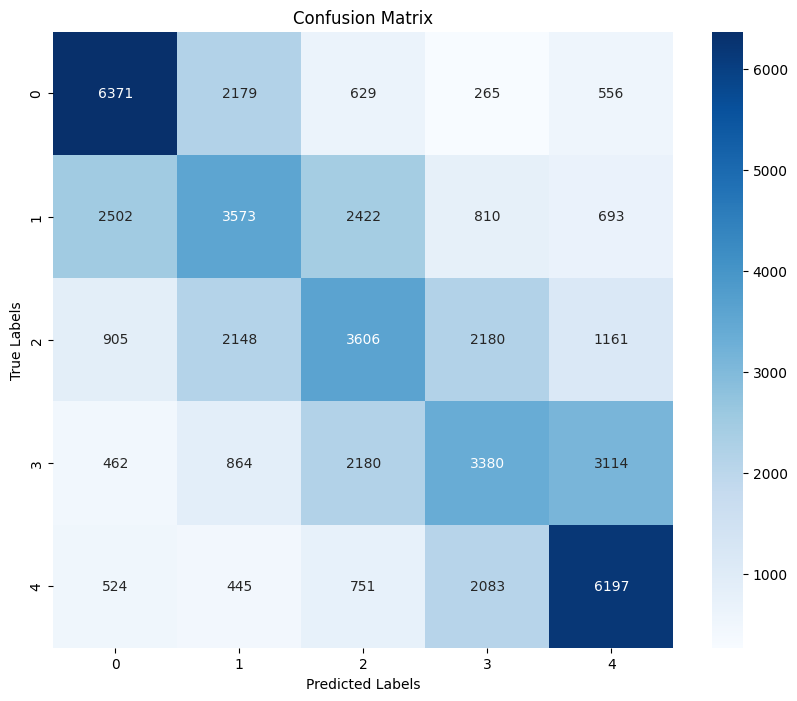

In [ ]:
#### Confusion Matrix ####

#### Adding Preprocessing (Final Preprocessing Function)

Considering the information loss due to the lemmatization, we did the pre-processing without lemmatization and we fixed the non-encoded characters, unnecessary quotation marks, handled special white-space characters, handled punctuations and dots (details can be found in parallel_tokenizer.py). We reached the baseline accuracy again with this setup.

In the preprocessing notebook, you can find the preprocessing function.

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.3425457976100716, Training Accuracy: 0.41724783940487914
Validation Loss: 1.22359186578102, Validation Accuracy: 0.4773929625984252
Epoch 2/4
Training Loss: 1.2649315931860667, Training Accuracy: 0.450275544251176
Validation Loss: 1.1996696840707712, Validation Accuracy: 0.48016117125984253
Epoch 3/4
Training Loss: 1.252322158766137, Training Accuracy: 0.4556479734164752
Validation Loss: 1.1773216591517286, Validation Accuracy: 0.49617064468503935
Epoch 4/4
Training Loss: 1.2483002736621658, Training Accuracy: 0.45859657039711194
Validation Loss: 1.1759931677439082, Validation Accuracy: 0.495847687007874


In [ ]:
outs2()

Average Testing Loss: 1.1737, Average Testing Accuracy: 0.4936


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [28:05<00:00,  1.08s/it, Testing Loss=1.17, Testing Accuracy=0.494]   


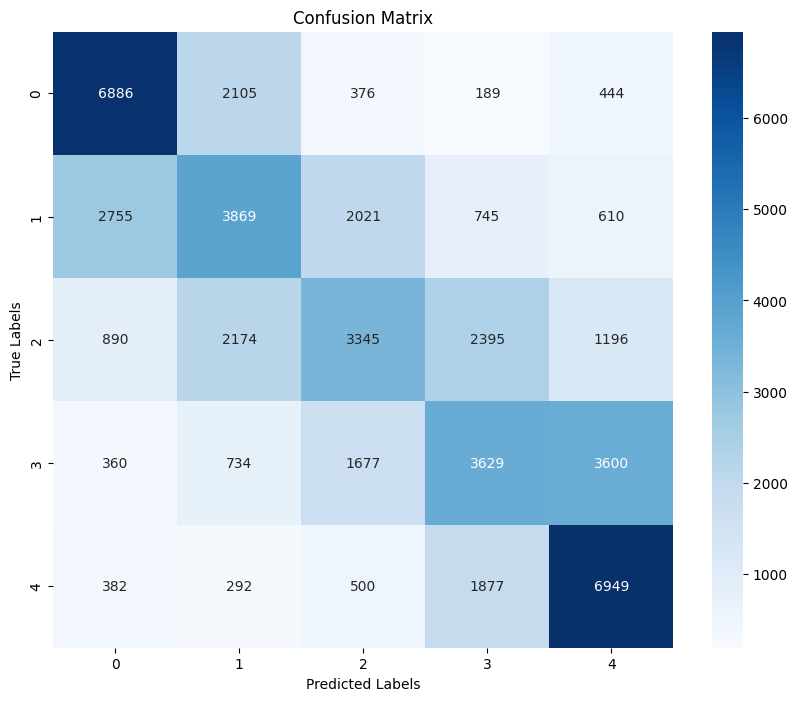

In [ ]:
### Confusion Matrix ###

### Classification with 2 Layer

We have increased the number of layers in the classification layer to capture more complex relations. Resulted in a minor increase in the final accuracy. However, 4 epochs was under-training for this case because there is a gap between train and validation accuracy.

In [ ]:
# Define the new classifier layers
import torch.nn as nn
from transformers import BertForSequenceClassification, BertConfig
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 128),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(128, 5)
)
# Replace the classifier of the pre-trained model
model.classifier = classifier

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.2775801845565955, Training Accuracy: 0.4382103136015559
Validation Loss: 1.1604789357292256, Validation Accuracy: 0.498428102788409
Epoch 2/4
Training Loss: 1.2449781643282212, Training Accuracy: 0.4560460222438313
Validation Loss: 1.1491254234392179, Validation Accuracy: 0.5034513395297977
Epoch 3/4
Training Loss: 1.2380107360476202, Training Accuracy: 0.4590088276406953
Validation Loss: 1.160428573943149, Validation Accuracy: 0.4959164844177146
Epoch 4/4
Training Loss: 1.2326196374262293, Training Accuracy: 0.46207039321745474
Validation Loss: 1.1375419220486387, Validation Accuracy: 0.5091580098414434


In [ ]:
outs2()

Average Testing Loss: 1.1350, Average Testing Accuracy: 0.5074


Epoch 4/4 (Testing): 100%|##########| 1407/1407 [13:24<00:00,  1.75it/s, Testing Loss=1.13, Testing Accuracy=0.507]    


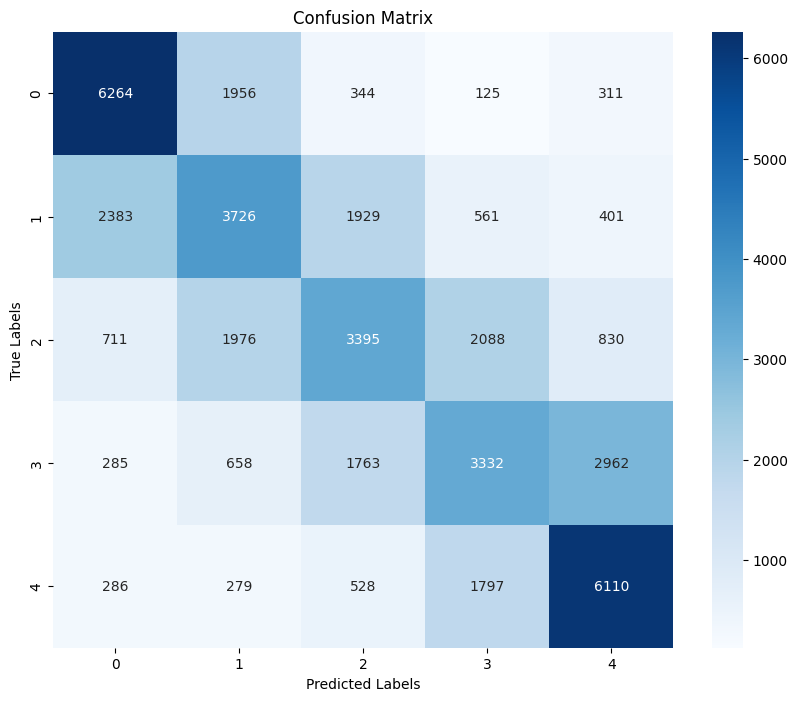

In [ ]:
### Confusion Matrix ###

We have reached better results with 2 Layer Classifier. However, we suspect undertraining because of the gap between validation and test accuracy.

### Starting training experiments with subset

We switched to training with subset instead of the whole to reduce the training times in order to do more compherensive HPO. This is a baseline for smaller subset.

There is no much code here but assume that ,until the final architecture and training, we will use 0.1 of the training set.

### Classification with 3 Layer

Increased the classification layers to three, to increase the model's complexity to handle more complex relations. Not much of a difference is observed. 

In [ ]:
# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(64, 5)
)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.368411942184004, Training Accuracy: 0.3913340623291416
Validation Loss: 1.2072524469272763, Validation Accuracy: 0.4777879901960784
Epoch 2/4
Training Loss: 1.2752008379450779, Training Accuracy: 0.4421473482777474
Validation Loss: 1.1702535342352063, Validation Accuracy: 0.48483455882352944
Epoch 3/4
Training Loss: 1.2606634629300673, Training Accuracy: 0.44800779114270095
Validation Loss: 1.1569969595647325, Validation Accuracy: 0.49984681372549017
Epoch 4/4
Training Loss: 1.2472437312526088, Training Accuracy: 0.4557989338436304
Validation Loss: 1.1497672223577313, Validation Accuracy: 0.49846813725490197


In [ ]:
outs2()

Average Testing Loss: 1.1688, Average Testing Accuracy: 0.4867


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:31<00:00,  1.72it/s, Testing Loss=1.17, Testing Accuracy=0.487]   


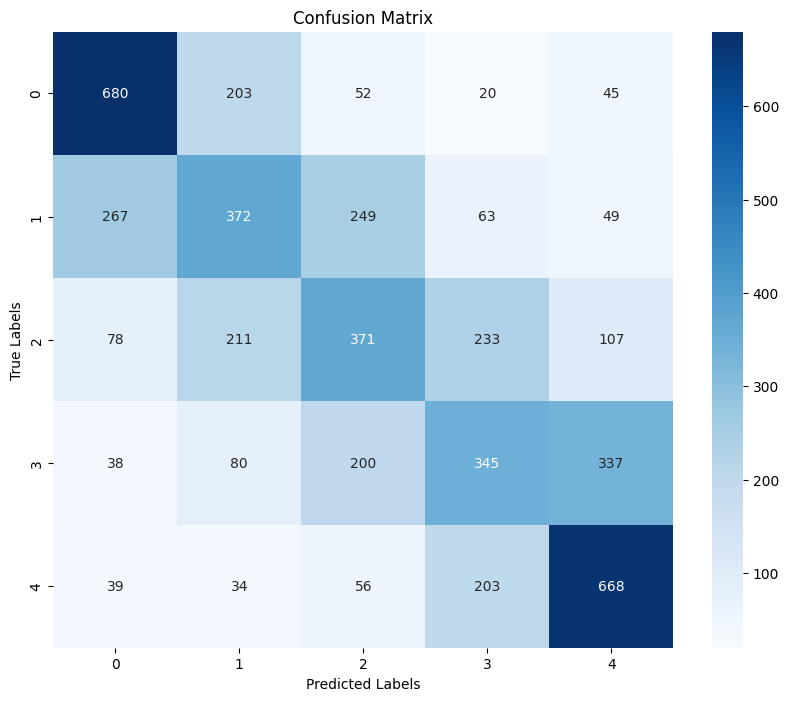

In [ ]:
### Confusion Matrix ###

At this point, we decided that original embedding space of the bert model does not align with our task and we decided to see the results with the finetuned embedding space as well.

### Classification wtih 2 Layer and All Unfreeze

With the frozen embedding space we couldn't get promising results so we decided to finetune the embedding space with lower learning rates. As expected, the results are overfitted a little. It could perform better with the whole dataset in terms of overfitting.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn
import torch.nn.functional as F

# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 5)
)

# Replace the classifier of the pre-trained model
model.classifier = classifier

# Update the number of labels in the config
model.config.num_labels = 5
model.num_labels = 5

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

# Create separate parameter groups for BERT and classifier
bert_params = []
classifier_params = []
for name, param in model.named_parameters():
    if 'classifier' in name:
        classifier_params.append(param)
    else:
        bert_params.append(param)

# Set up the optimizer with different learning rates for BERT and classifier
optimizer_grouped_parameters = [
    {'params': bert_params, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.9391978535579162, Training Accuracy: 0.5826100328048114
Validation Loss: 0.8333215283996919, Validation Accuracy: 0.6393995098039216
Epoch 2/4
Training Loss: 0.7756779108007076, Training Accuracy: 0.6597696828868234
Validation Loss: 0.8073050945120699, Validation Accuracy: 0.6527267156862745
Epoch 3/4
Training Loss: 0.6898153159643146, Training Accuracy: 0.7028601694915254
Validation Loss: 0.8087778219989702, Validation Accuracy: 0.6588541666666666
Epoch 4/4
Training Loss: 0.6250813028863247, Training Accuracy: 0.7349302897758337
Validation Loss: 0.8309259507439885, Validation Accuracy: 0.6602328431372549


In [ ]:
outs2()

Average Testing Loss: 0.8595, Average Testing Accuracy: 0.6453


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:28<00:00,  1.77it/s, Testing Loss=0.86, Testing Accuracy=0.645]   


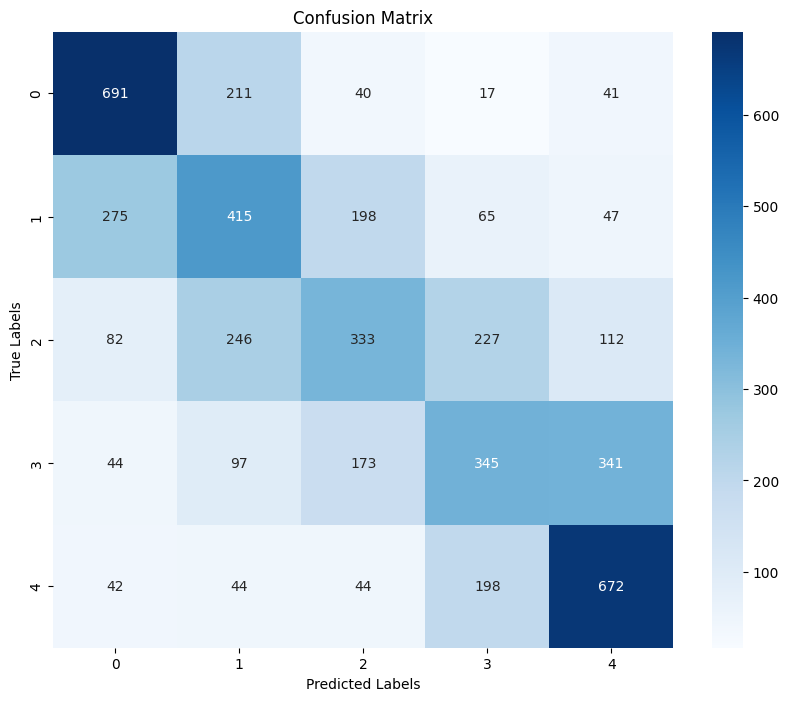

In [ ]:
### Confusion Matrix ###

As you can see, we achieved way better results. Our embedding space is also trained. This enables model to learn more about our documents.

### Classification with 2 Layer and 6 Layer Unfreeze

Only the last 6 layers of the BertEncoder is unfreezen as suggested in the papers and used as a SOTA way for finetuning BERT models on downstream tasks. BertEncoders are updated with lower learning rate compared to the classification head. Reached the same accuracy with the AllUnfreeze model with less overfitting.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn
import torch.nn.functional as F

# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 5)
)

# Replace the classifier of the pre-trained model
model.classifier = classifier

# Update the number of labels in the config
model.config.num_labels = 5
model.num_labels = 5

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
bert_params_rest = []
classifier_params = []

for name, param in model.named_parameters():
    if 'classifier' in name:
        classifier_params.append(param)
    elif 'bert.encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= num_bert_layers - 6:
            bert_params_last_6.append(param)
        else:
            param.requires_grad = False  # Freeze the previous layers
    else:
        bert_params_rest.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.9703559463078888, Training Accuracy: 0.5705303444505194
Validation Loss: 0.8632782574962167, Validation Accuracy: 0.6173406862745098
Epoch 2/4
Training Loss: 0.8469399492423869, Training Accuracy: 0.6279558501913614
Validation Loss: 0.8296068944036961, Validation Accuracy: 0.6331188725490197
Epoch 3/4
Training Loss: 0.7921296302381925, Training Accuracy: 0.6538408966648441
Validation Loss: 0.813924707034055, Validation Accuracy: 0.6430759803921569
Epoch 4/4
Training Loss: 0.7553609741750866, Training Accuracy: 0.6699699289229087
Validation Loss: 0.8131635712057936, Validation Accuracy: 0.6429227941176471


In [ ]:
outs2()

Average Testing Loss: 0.8275, Average Testing Accuracy: 0.6407


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:29<00:00,  1.76it/s, Testing Loss=0.827, Testing Accuracy=0.641]  


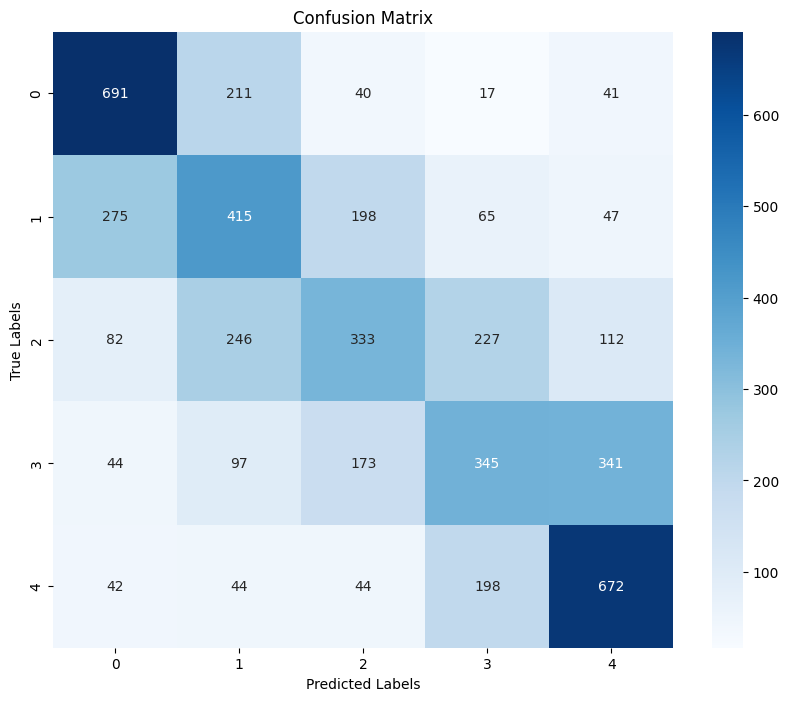

In [ ]:
### Confusion Matrix ###

### Classification with 3 Layer and 6 Layer Unfreeze

Upon the good results of the 2 Layer 6 Unfreeze model, we would like to see the extension to the third layer. But we couldn't observe any improvements in the subset. We concluded that the subset was not adequate to train all the parameters, and to be on the safe side we decided to continue with 3 layer architecture.

In [ ]:
# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(64, 5)
)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.9900317240634728, Training Accuracy: 0.5634568069983598
Validation Loss: 0.8989464126381219, Validation Accuracy: 0.6047794117647058
Epoch 2/4
Training Loss: 0.8563629415368955, Training Accuracy: 0.6257517769272827
Validation Loss: 0.8357810741838287, Validation Accuracy: 0.6349571078431373
Epoch 3/4
Training Loss: 0.8050422369944977, Training Accuracy: 0.6465794149808639
Validation Loss: 0.823057827777138, Validation Accuracy: 0.6421568627450981
Epoch 4/4
Training Loss: 0.7660877910091813, Training Accuracy: 0.6656642974302898
Validation Loss: 0.8166496235073781, Validation Accuracy: 0.6482843137254902


In [ ]:
outs2()

Average Testing Loss: 0.8309, Average Testing Accuracy: 0.6397


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:10<00:00,  2.22it/s, Testing Loss=0.831, Testing Accuracy=0.64]   


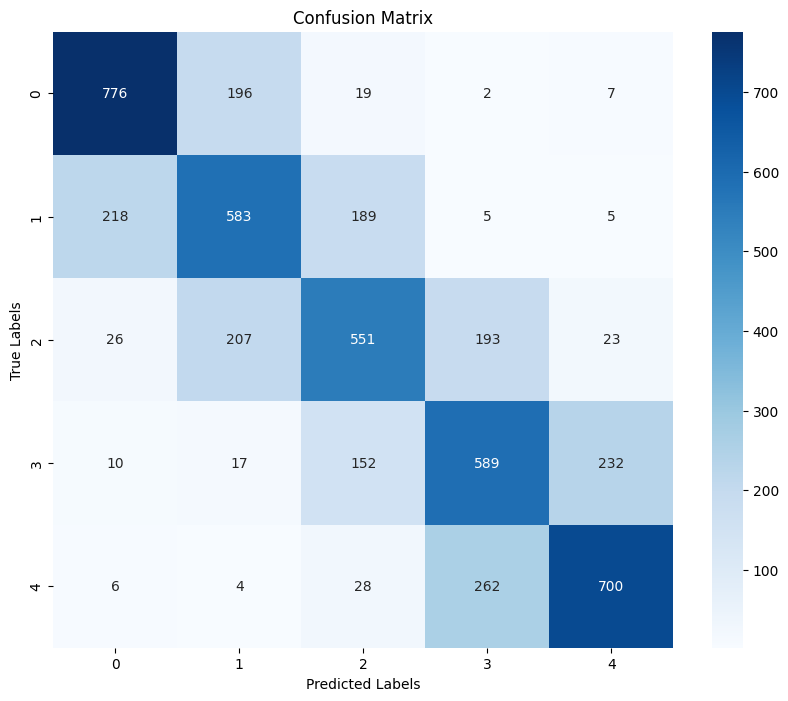

In [ ]:
### Confusion Matrix ###

### Regression and Effect of Ordinality

Upon to the last experiment, we wanted to see the effect of ordinality. Because, in the previous ones we treated classes as unordinary due to the softmax. Now, we want to preserve the ordinality with sigmoid activation function.

In [ ]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Define the model architecture for regression
class BERTRegression(torch.nn.Module):
    def __init__(self):
        super(BERTRegression, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier1 = torch.nn.Linear(768, 256)
        self.classifier2 = torch.nn.Linear(256, 64)
        self.classifier3 = torch.nn.Linear(64, 1)
        self.activate = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(0.1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        x1 = self.classifier1(pooler)
        x1_a = self.activate(x1)
        x1_drop = self.dropout(x1_a)
        x2 = self.classifier2(x1_drop)
        x2_a = self.activate(x2)
        x2_drop = self.dropout(x2_a)
        x3 = self.classifier3(x2_drop)
        out = self.sigmoid(x3)
        return out

model = BERTRegression()
criterion = nn.MSELoss()

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
bert_params_rest = []
classifier_params = []

for name, param in model.named_parameters():
    if 'classifier' in name:
        classifier_params.append(param)
    elif 'bert.encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= num_bert_layers - 6:
            bert_params_last_6.append(param)
        else:
            param.requires_grad = False  # Freeze the previous layers
    else:
        bert_params_rest.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.03446603013292167, Training Accuracy: 0.5513087752870421
Validation Loss: 0.02833527836528625, Validation Accuracy: 0.5962009803921569
Epoch 2/4
Training Loss: 0.027248807966876155, Training Accuracy: 0.6035231000546747
Validation Loss: 0.02779806455752502, Validation Accuracy: 0.6049325980392157
Epoch 3/4
Training Loss: 0.02401820649767163, Training Accuracy: 0.6270844723892838
Validation Loss: 0.025581075376191854, Validation Accuracy: 0.6352634803921569
Epoch 4/4
Training Loss: 0.02219760639770206, Training Accuracy: 0.6400697102241663
Validation Loss: 0.025147881491255818, Validation Accuracy: 0.6367953431372549


In [ ]:
outs2()

Average Testing Loss: 0.0254, Average Testing Accuracy: 0.6254


Testing: 100%|##########| 157/157 [01:10<00:00,  2.22it/s, Testing Loss=0.0254, Testing Accuracy=0.625]  


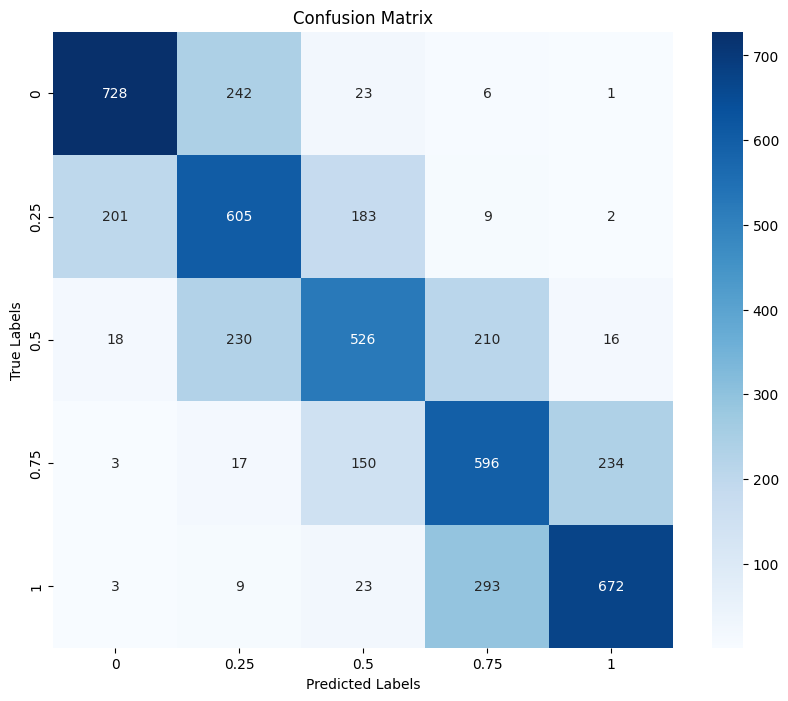

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Original labels and predictions
# all_labels and all_predictions should be defined elsewhere in your code

# Define the mapping
mapping = {0: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1: 4}

# Function to map values to integers
def map_to_int(values, mapping):
    return np.array([mapping[v] for v in values])

# Map the labels and predictions
all_labels_mapped = map_to_int(all_labels, mapping)
all_predictions_mapped = map_to_int(all_predictions, mapping)

# Calculate the confusion matrix
cm = confusion_matrix(all_labels_mapped, all_predictions_mapped)

# Define class names for the heatmap
class_names = ['0', '0.25', '0.5', '0.75', '1']

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Regression + Leaky Relu

We switched to the LeakyRelu activation function instead of tanh, to observe possible theoretical advantages of it. However, there is not much of a difference.

In [ ]:
self.activate = torch.nn.LeakyReLU()

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.02111507493400709, Training Accuracy: 0.6463572990705303
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863
Epoch 2/4
Training Loss: 0.021097260101623487, Training Accuracy: 0.6490226899945325
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863
Epoch 3/4
Training Loss: 0.02101718099225677, Training Accuracy: 0.6454346637506835
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863
Epoch 4/4
Training Loss: 0.02104165478206727, Training Accuracy: 0.6470919901585566
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863


In [ ]:
outs2()

Average Testing Loss: 0.0253, Average Testing Accuracy: 0.6180


Testing: 100%|##########| 157/157 [01:10<00:00,  2.22it/s, Testing Loss=0.0253, Testing Accuracy=0.618]  


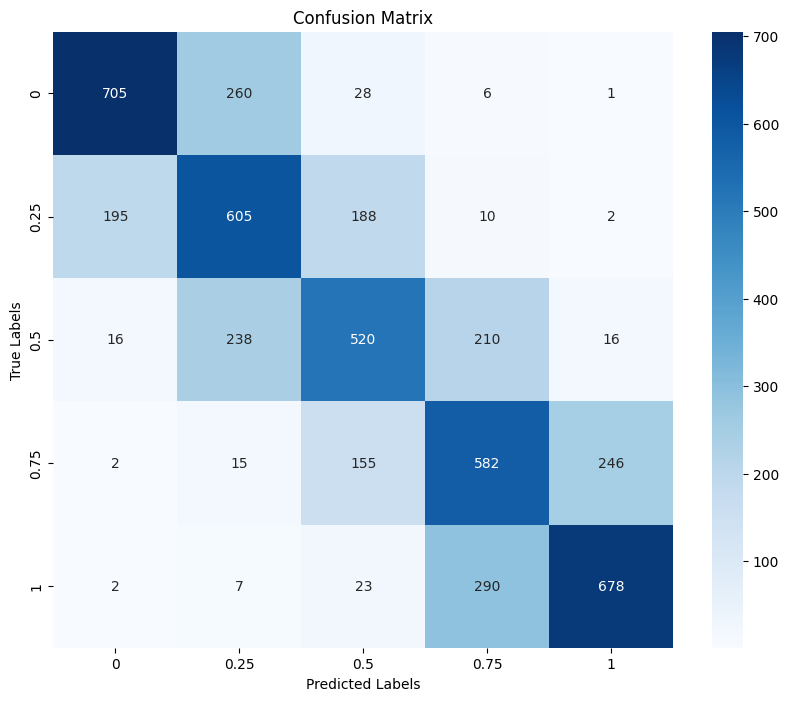

In [ ]:
### Confusion Matrix ###

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np
from sklearn.metrics import accuracy_score

# Function to calculate accuracy for given thresholds
def calculate_accuracy(predictions, labels, thresholds):
    class_preds = np.digitize(predictions, thresholds)
    return accuracy_score(labels, class_preds)

# Convert back to original scale
labels = np.array(all_labels) * 4

# Define the objective function for optimization
def objective(thresholds):
    thresholds = np.sort(thresholds)  # Ensure thresholds are sorted
    return -calculate_accuracy(all_raw_predictions, labels, thresholds)  # We minimize, so negate accuracy

# Define bounds for the thresholds (three thresholds between 0 and 1)
bounds = [(0, 1), (0, 1), (0, 1), (0,1)]

class TqdmProgress:
    def __init__(self, max_iter):
        self.progress_bar = tqdm(total=max_iter, desc="Optimization Progress", position=0, leave=True)
        self.iteration = 0

    def __call__(self, xk, convergence):
        self.iteration += 1
        self.progress_bar.update(1)

    def close(self):
        self.progress_bar.close()

# Initialize the progress bar
progress = TqdmProgress(50000)

# Perform differential evolution to find the optimal thresholds
result = differential_evolution(
    objective, 
    bounds, 
    maxiter=50000,      
    popsize=500,          
    mutation=(0.5, 1),     
    recombination=0.5,     
    callback=progress       
)

# Close the progress bar
progress.close()
# Get the best thresholds and accuracy
best_thresholds = np.sort(result.x)
best_accuracy = -result.fun

print(f'Best Accuracy: {best_accuracy:.4f} with thresholds: {best_thresholds}')

Optimization Progress:   0%|                                          | 36/50000 [01:20<31:02:13,  2.24s/it]

Best Accuracy: 0.6284 with thresholds: [0.12495491 0.38662843 0.63670718 0.82971599]


### Attention Mechanism

We wanted to switch the LeakyRelu with GELU activation function and wanted to add attention layers to better handle the padding tokens.

The attention mechanism is a concept within neural networks that allows the model to focus on specific parts of the input sequence when making predictions. It was originally introduced to improve performance in sequence-to-sequence models, particularly in the field of machine translation. The key idea is to dynamically weigh the importance of different elements in the input sequence, allowing the model to concentrate on relevant parts of the data while ignoring less relevant parts.

* Improved Performance: Attention mechanisms can significantly enhance the performance of neural networks on tasks involving sequential data, such as machine translation, text summarization, and question answering, by allowing the model to focus on relevant parts of the input.

* Handling Long Sequences: Traditional sequence models like RNNs and LSTMs struggle with long dependencies due to issues like vanishing gradients. Attention mechanisms, particularly self-attention, can handle long sequences more effectively by providing direct connections between distant elements of the sequence.

* Parallelization: In the Transformer architecture, the use of self-attention allows for more parallel computation compared to RNNs, which process sequences sequentially. This leads to faster training times and more efficient use of computational resources.

* Interpretability: Attention weights can provide insights into what parts of the input the model is focusing on. This can help in understanding the model's decisions and improving interpretability.

* Flexibility: Attention mechanisms can be easily adapted to various tasks and architectures. They are not limited to text data and have been successfully applied in areas like image captioning and speech recognition.

In [ ]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
from transformers import modeling_outputs
import torch.nn as nn
import torch.nn.functional as F

class EnhancedBertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=5):
        super(EnhancedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=8)
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.LayerNorm(64),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(64, num_labels)
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        attn_output, _ = self.attention(sequence_output, sequence_output, sequence_output)
        attn_output = self.layer_norm(attn_output + sequence_output)  # Residual connection and layer normalization
        pooled_output = attn_output.mean(dim=1)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        
        return modeling_outputs.SequenceClassifierOutput(
        loss=loss,
        logits=logits)

model = EnhancedBertClassifier()

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
classifier_params = []

for name, param in model.named_parameters():
    if name.startswith('bert.embeddings') or (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) < 7):
        param.requires_grad = False
    if (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) >= 7):
        bert_params_last_6.append(param)
    if ((name.startswith('classifier')) or (name.startswith('bert.pooler')) or (name.startswith('attention')) or (name.startswith('layer_norm'))):
        classifier_params.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.9687884016855615, Training Accuracy: 0.5754852378348825
Validation Loss: 0.8841111110705956, Validation Accuracy: 0.6128982843137255
Epoch 2/4
Training Loss: 0.8557966662241893, Training Accuracy: 0.6248633132859486
Validation Loss: 0.8552585698518098, Validation Accuracy: 0.6289828431372549
Epoch 3/4
Training Loss: 0.8110408217871756, Training Accuracy: 0.6468869600874795
Validation Loss: 0.828862644293729, Validation Accuracy: 0.6397058823529411
Epoch 4/4
Training Loss: 0.7733738182215433, Training Accuracy: 0.6618712411153636
Validation Loss: 0.8228677866213462, Validation Accuracy: 0.6389399509803921


In [ ]:
outs2()

Average Testing Loss: 0.8313, Average Testing Accuracy: 0.6346


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:10<00:00,  2.24it/s, Testing Loss=0.831, Testing Accuracy=0.635]  


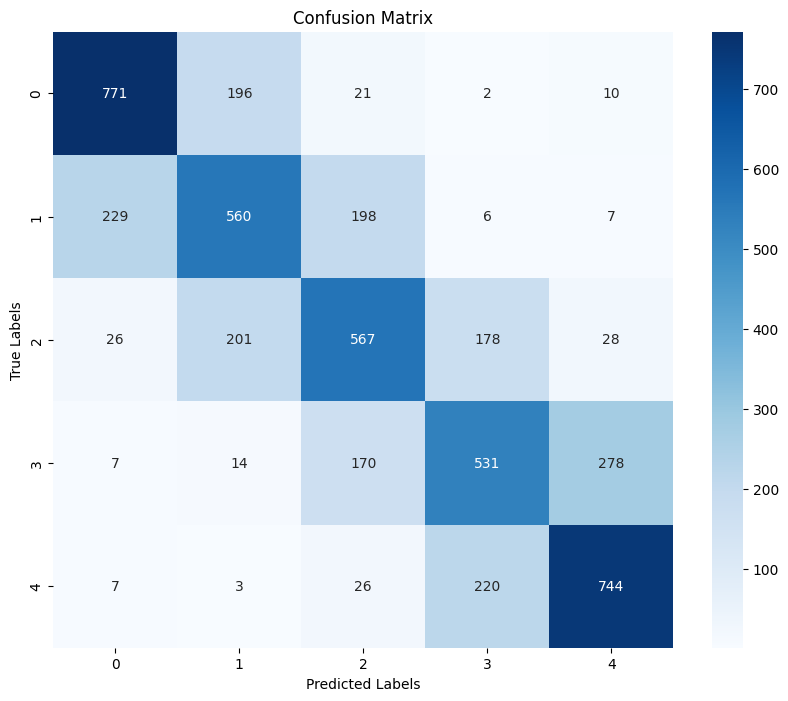

In [ ]:
### Confusion Matrix ###

### Train with All Data with Best 2 Architecture

We have 2 architecture giving accuracy around %64. We do not have that much of GPU power so we will train just these 2 models with all data. 

#### First Model

Since this model was the one of the bests, we trained this model with the whole dataset again.

In [ ]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
from transformers import modeling_outputs
import torch.nn as nn
import torch.nn.functional as F

class EnhancedBertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=5):
        super(EnhancedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=8)
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.LayerNorm(64),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(64, num_labels)
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        attn_output, _ = self.attention(sequence_output, sequence_output, sequence_output)
        attn_output = self.layer_norm(attn_output + sequence_output)  # Residual connection and layer normalization
        pooled_output = attn_output.mean(dim=1)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        
        return modeling_outputs.SequenceClassifierOutput(
        loss=loss,
        logits=logits)

model = EnhancedBertClassifier()

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
classifier_params = []

for name, param in model.named_parameters():
    if name.startswith('bert.embeddings') or (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) < 7):
        param.requires_grad = False
    if (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) >= 7):
        bert_params_last_6.append(param)
    if ((name.startswith('classifier')) or (name.startswith('bert.pooler')) or (name.startswith('attention')) or (name.startswith('layer_norm'))):
        classifier_params.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


EnhancedBertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
%%capture outs1
# Training loop
for epoch in range(epochs):
    # Training loop with tqdm
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    print(f'Epoch {epoch+1}/{epochs}')
    #progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Training)')
    for batch in train_loader:
    #for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        #progress_bar_train.set_postfix({'Training Loss': total_train_loss / len(progress_bar_train), 'Training Accuracy': total_train_accuracy / len(progress_bar_train)})

    # Validation loop with tqdm
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    #print(f'Epoch {epoch+1}/{epochs} (Validation)')
    #progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} (Validation)')
    with torch.no_grad():
        for batch in val_loader:
        #for batch in progress_bar_val:
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            labels = batch[3].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            accuracy = (predictions == labels).float().mean()
            total_val_accuracy += accuracy.item()
            
            #progress_bar_val.set_postfix({'Validation Loss': total_val_loss / len(progress_bar_val), 'Validation Accuracy': total_val_accuracy / len(progress_bar_val)})
            
    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    
    print(f'Training Loss: {total_train_loss / len(train_loader)}, Training Accuracy: {total_train_accuracy / len(train_loader)}')
    print(f'Validation Loss: {total_val_loss / len(val_loader)}, Validation Accuracy: {total_val_accuracy / len(val_loader)}')

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.8226125934376731, Training Accuracy: 0.6392712093862816
Validation Loss: 0.7456464996986737, Validation Accuracy: 0.6694605068897638
Epoch 2/4
Training Loss: 0.7314922203512685, Training Accuracy: 0.6798490318345914
Validation Loss: 0.7173082605444305, Validation Accuracy: 0.68677718996063
Epoch 3/4
Training Loss: 0.6958607956530711, Training Accuracy: 0.6945561207745323
Validation Loss: 0.7028372092685831, Validation Accuracy: 0.6922828494094488
Epoch 4/4
Training Loss: 0.6739806418570292, Training Accuracy: 0.7043027294606717
Validation Loss: 0.7018289785157508, Validation Accuracy: 0.6927903543307087


In [ ]:
%%capture outs2
model.eval()
total_test_loss = 0
total_test_accuracy = 0
progress_bar_test = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} (Testing)')

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_test_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_test_accuracy += accuracy.item()
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar_test.set_postfix({'Testing Loss': total_test_loss / len(progress_bar_test),
                                       'Testing Accuracy': total_test_accuracy / len(progress_bar_test)})
    
# Calculate average loss and accuracy
avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)

# Print the average testing loss and accuracy
print(f'Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_accuracy:.4f}')

In [ ]:
outs2()

Average Testing Loss: 0.7099, Average Testing Accuracy: 0.6890


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [11:50<00:00,  2.20it/s, Testing Loss=0.71, Testing Accuracy=0.689]   


In [ ]:
# Save the model and its parameters
torch.save(model.state_dict(), 'model_14.pth')

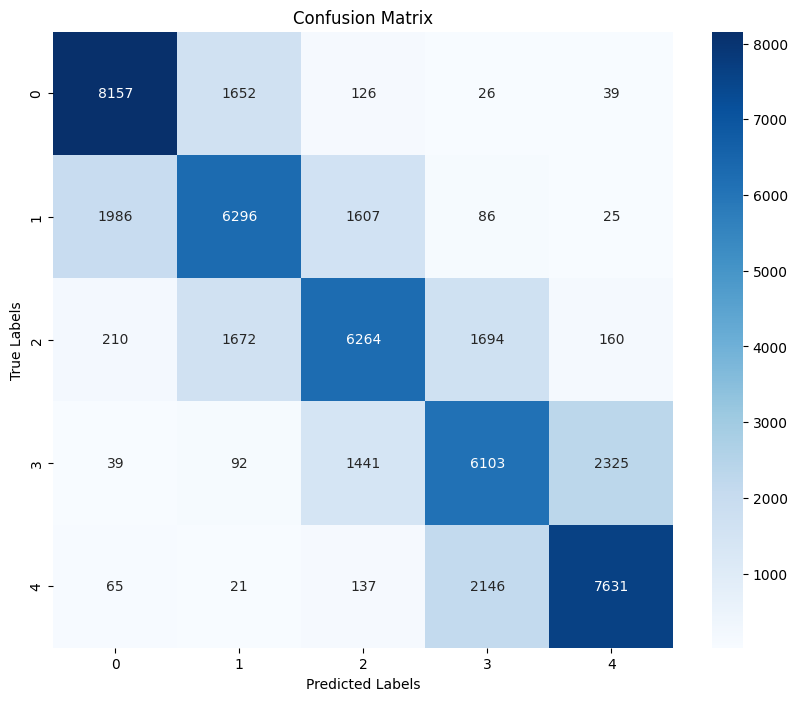

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Second Model

The whole dataset training of the other best model.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn
import torch.nn.functional as F

# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(64, 5)
)

# Replace the classifier of the pre-trained model
model.classifier = classifier

# Update the number of labels in the config
model.config.num_labels = 5
model.num_labels = 5

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
bert_params_rest = []
classifier_params = []

for name, param in model.named_parameters():
    if 'classifier' in name:
        classifier_params.append(param)
    elif 'bert.encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= num_bert_layers - 6:
            bert_params_last_6.append(param)
        else:
            param.requires_grad = False  # Freeze the previous layers
    else:
        bert_params_rest.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
%%capture outs1
# Training loop
for epoch in range(epochs):
    # Training loop with tqdm
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    print(f'Epoch {epoch+1}/{epochs}')
    #progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Training)')
    for batch in train_loader:
    #for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        #progress_bar_train.set_postfix({'Training Loss': total_train_loss / len(progress_bar_train), 'Training Accuracy': total_train_accuracy / len(progress_bar_train)})

    # Validation loop with tqdm
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    #print(f'Epoch {epoch+1}/{epochs} (Validation)')
    #progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} (Validation)')
    with torch.no_grad():
        for batch in val_loader:
        #for batch in progress_bar_val:
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            labels = batch[3].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            accuracy = (predictions == labels).float().mean()
            total_val_accuracy += accuracy.item()
            
            #progress_bar_val.set_postfix({'Validation Loss': total_val_loss / len(progress_bar_val), 'Validation Accuracy': total_val_accuracy / len(progress_bar_val)})
            
    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    
    print(f'Training Loss: {total_train_loss / len(train_loader)}, Training Accuracy: {total_train_accuracy / len(train_loader)}')
    print(f'Validation Loss: {total_val_loss / len(val_loader)}, Validation Accuracy: {total_val_accuracy / len(val_loader)}')

In [ ]:
outs1()

In [ ]:
%%capture outs2
model.eval()
total_test_loss = 0
total_test_accuracy = 0
progress_bar_test = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} (Testing)')

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_test_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_test_accuracy += accuracy.item()
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar_test.set_postfix({'Testing Loss': total_test_loss / len(progress_bar_test),
                                       'Testing Accuracy': total_test_accuracy / len(progress_bar_test)})
    
# Calculate average loss and accuracy
avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)

# Print the average testing loss and accuracy
print(f'Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_accuracy:.4f}')

In [ ]:
outs2()

Average Testing Loss: 0.7109, Average Testing Accuracy: 0.6896


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [11:27<00:00,  2.27it/s, Testing Loss=0.711, Testing Accuracy=0.69]   


In [ ]:
# Save the model and its parameters
torch.save(model.state_dict(), 'model_15.pth')

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.8272007566718483, Training Accuracy: 0.6369909610545892
Validation Loss: 0.7531800072962843, Validation Accuracy: 0.6714905265748031
Epoch 2/4
Training Loss: 0.7366962426976502, Training Accuracy: 0.6778456952193415
Validation Loss: 0.720752185547915, Validation Accuracy: 0.6872231791338582
Epoch 3/4
Training Loss: 0.7014354298965322, Training Accuracy: 0.6931749808554862
Validation Loss: 0.7115582478504012, Validation Accuracy: 0.6885765255905512
Epoch 4/4
Training Loss: 0.6780820782127741, Training Accuracy: 0.7034583196586807
Validation Loss: 0.7059024091457992, Validation Accuracy: 0.6927442175196851


In [ ]:
outs2()

Average Testing Loss: 0.7109, Average Testing Accuracy: 0.6896


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [11:27<00:00,  2.27it/s, Testing Loss=0.711, Testing Accuracy=0.69]   


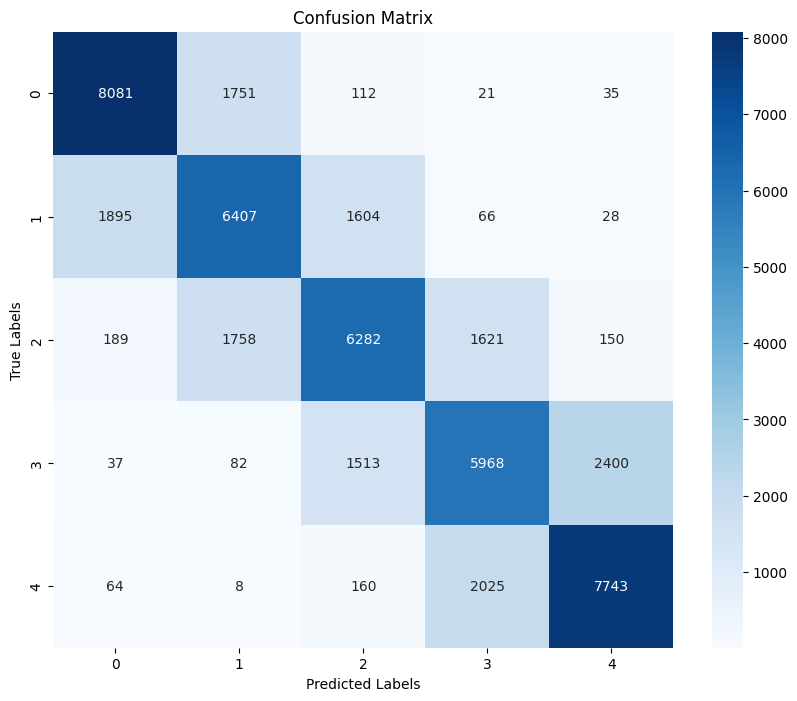

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_predictions)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     10000
           1       0.64      0.64      0.64     10000
           2       0.65      0.63      0.64     10000
           3       0.62      0.60      0.61     10000
           4       0.75      0.77      0.76     10000

    accuracy                           0.69     50000
   macro avg       0.69      0.69      0.69     50000
weighted avg       0.69      0.69      0.69     50000



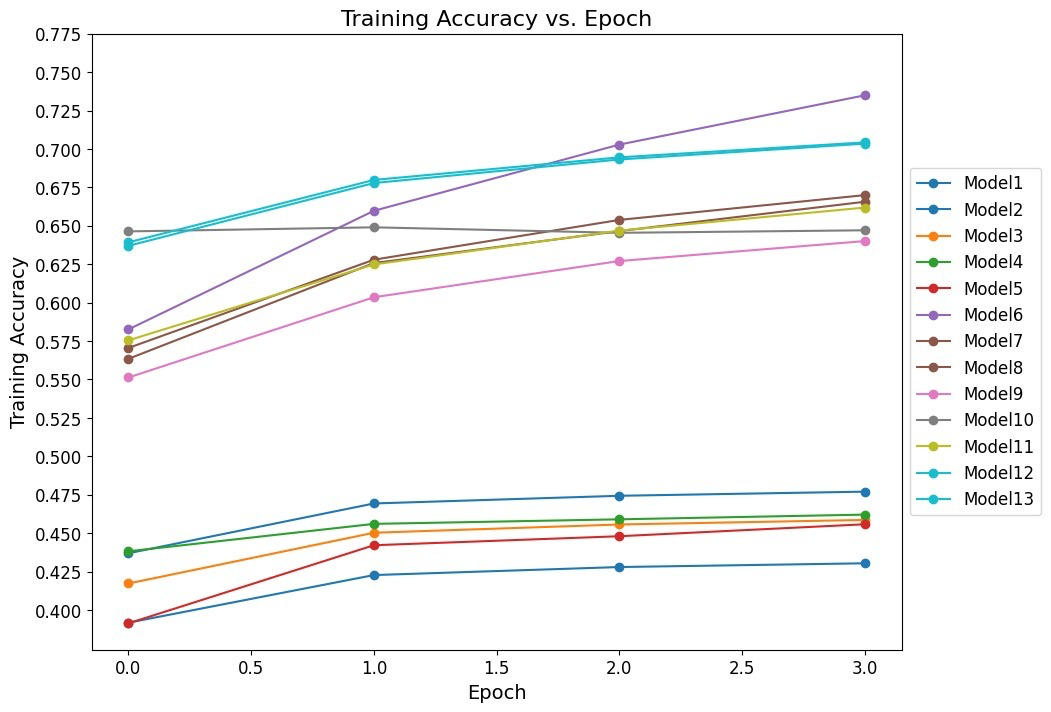

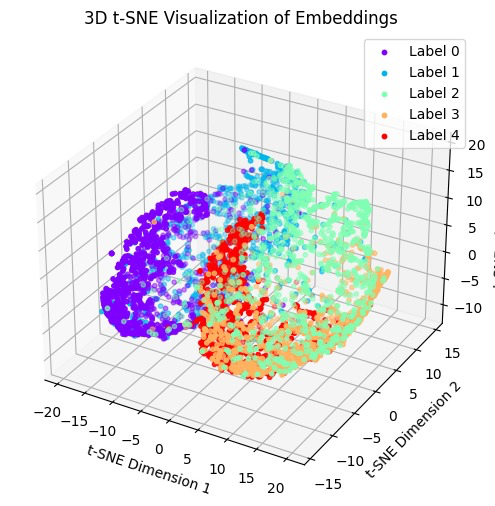

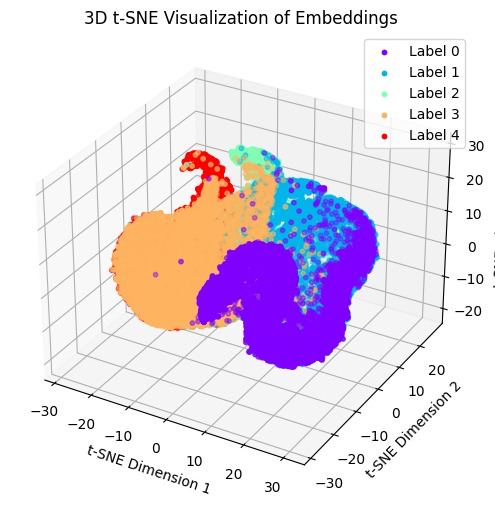

In [ ]:
import numpy as np

# Assuming all_predictions and all_labels are numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate the element-wise Hamming distance
absolute_differences = np.abs(all_predictions - all_labels)

print(f"Hamming Distance of Wrong Predictions: {np.mean(absolute_differences[absolute_differences != 0]):.2f}")

Hamming Distance of Wrong Predictions: 1.08


In [ ]:
outs2()

Average Testing Loss: 0.1278, Average Testing Accuracy: 0.9552


Epoch 4/4 (Testing): 100%|##########| 126/126 [00:55<00:00,  2.27it/s, Testing Loss=0.128, Testing Accuracy=0.955]  


### MODEL EVALUATION AND OTHER MODELS

YELP Review Dataset is widely known dataset so it is used in different models. As a result there are lots of models uploaded to huggingface. In this notebook we evaluate this models and our model in terms of accuracy, f1_score and similar metrics. Note that there is just one model in huggingface that gives better result than our models.

Install datasets library to use models.

In [ ]:
# install datasets
!pip install datasets

In [ ]:
import json

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

We are GPU Poor :(

Because of tokenizers and inference, testing can be a bit long.

In [ ]:
x_test = test_dataset['text'][:5000]
y_test = test_dataset['label'][:5000]

Using first 5000 sample is not much different than using 65k test set. All the models give similar result as they indicated in their huggingface model page.

In [ ]:
import torch
# Function to perform sentiment analysis
def analyze_sentiment(text, tokenizer,model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class (logits)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    # Map predicted class to sentiment (assuming 0-4 corresponds to 1-5 star ratings)
    sentiment = predicted_class
    
    return sentiment

In [ ]:
# Predict sentiments for the test set
def predict(x_test, tokenizer, model):
    y_pred = []
    for i,doc in enumerate(x_test):
        result = analyze_sentiment(doc,tokenizer, model)
        y_pred.append(result)
        print(i)
    return y_pred

In [ ]:

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
def metrics(y_test, y_pred, binary=False):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score: {f1:.2f}")

    # Generate a classification report
    report = classification_report(y_test, y_pred)
    print(f"Classification Report:\n{report}")
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(10, 7))
    if not binary:
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    if binary:
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

#### Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews

This model is a fine-tuned version of distilbert-base-uncased on the yelp_review_full dataset. It achieves the following results on the evaluation set:

* Loss: 0.8288
* Accuracy: 0.6418
* F1: 0.6425

The following hyperparameters were used during training:

* learning_rate: 2e-05
* train_batch_size: 32
* eval_batch_size: 32
* seed: 42
* optimizer: Adam with betas=(0.9,0.999) and epsilon=1e-08
* lr_scheduler_type: linear
* num_epochs: 2

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_distilbert_base_uncased_finetuned_yelp_reviews = AutoTokenizer.from_pretrained("Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews")
model_distilbert_base_uncased_finetuned_yelp_reviews = AutoModelForSequenceClassification.from_pretrained("Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews")

In [ ]:
y_pred_distilbert_base_uncased_finetuned_yelp_reviews = predict(x_test, tokenizer_distilbert_base_uncased_finetuned_yelp_reviews, model_distilbert_base_uncased_finetuned_yelp_reviews)

In [ ]:
with open('y_pred_distilbert_base_uncased_finetuned_yelp_reviews.json', 'w') as f:
    json.dump(y_pred_distilbert_base_uncased_finetuned_yelp_reviews, f)

In [ ]:
y_pred_distilbert_base_uncased_finetuned_yelp_reviews = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_distilbert_base_uncased_finetuned_yelp_reviews.json"))

Accuracy: 0.64
F1 Score: 0.64
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1141
           1       0.57      0.58      0.58      1009
           2       0.59      0.55      0.57      1003
           3       0.58      0.56      0.57       986
           4       0.68      0.74      0.71       861

    accuracy                           0.64      5000
   macro avg       0.64      0.64      0.64      5000
weighted avg       0.64      0.64      0.64      5000



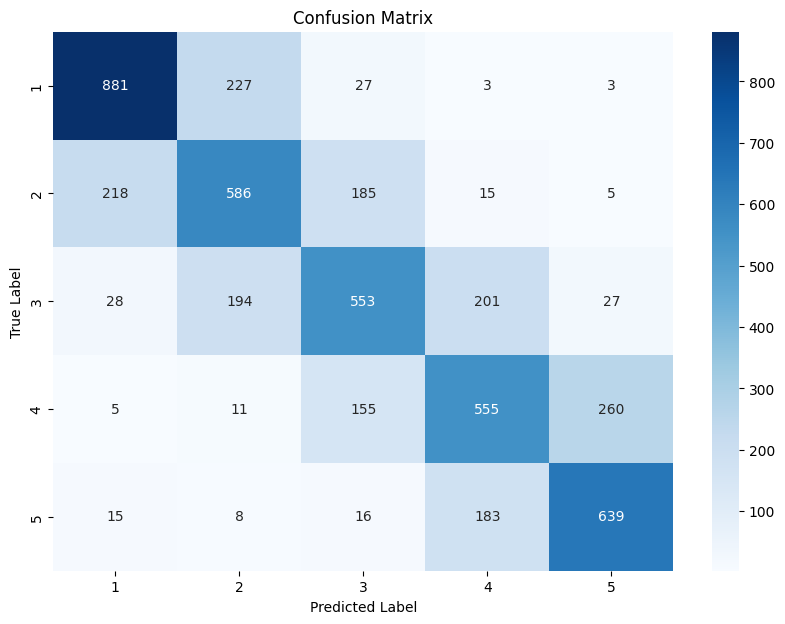

In [ ]:
metrics(y_test,y_pred_distilbert_base_uncased_finetuned_yelp_reviews)

As we understand from metrics, it predicts well semantic of the text. What I mean by "semantic" is being positive or negative. However for labels 2,3 and 4 (1,2 and 3 in dataset) it gives similar result to our model. Also F1-Score is same as the accuracy, which indicates precision and recall success are close to each other.

#### jenniferjane/Bert_Classifier

This model is a fine-tuned version of bert-base-cased on the yelp_review_full dataset. It achieves the following results on the evaluation set:

* Loss: 1.0546
* Accuracy: 0.634

In [ ]:
tokenizer_jenniferjane_Bert_Classifier = AutoTokenizer.from_pretrained("jenniferjane/Bert_Classifier")
model_jenniferjane_Bert_Classifier = AutoModelForSequenceClassification.from_pretrained("jenniferjane/Bert_Classifier")

In [ ]:
len(x_test)

In [ ]:
y_pred_jenniferjane_Bert_Classifier = predict(x_test, tokenizer_jenniferjane_Bert_Classifier, model_jenniferjane_Bert_Classifier)

In [ ]:
with open('y_pred_jenniferjane_Bert_Classifier.json', 'w') as f:
    json.dump(y_pred_jenniferjane_Bert_Classifier, f)

In [ ]:
y_pred_jenniferjane_Bert_Classifier = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_jenniferjane_Bert_Classifier.json"))

Accuracy: 0.62
F1 Score: 0.62
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1141
           1       0.55      0.56      0.55      1009
           2       0.54      0.56      0.55      1003
           3       0.55      0.56      0.56       986
           4       0.70      0.66      0.68       861

    accuracy                           0.62      5000
   macro avg       0.62      0.62      0.62      5000
weighted avg       0.62      0.62      0.62      5000



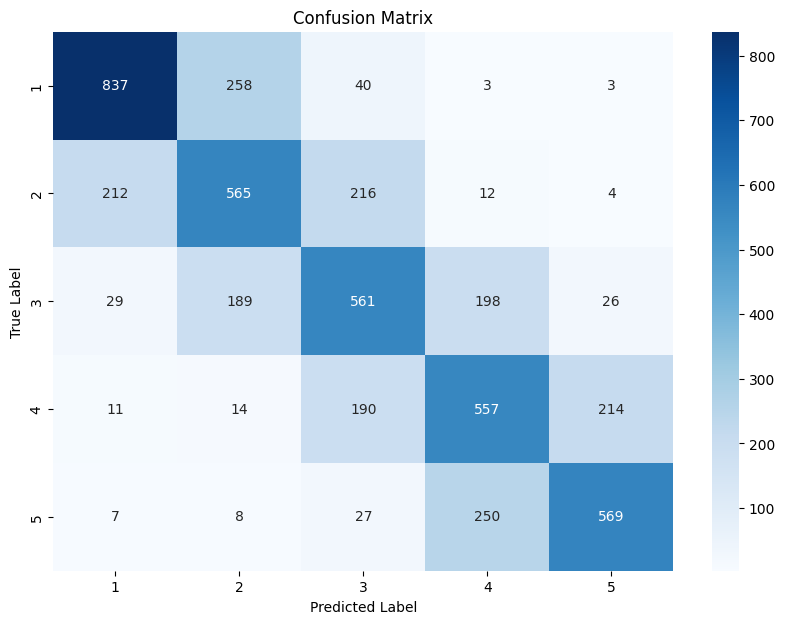

In [ ]:
metrics(y_test, y_pred_jenniferjane_Bert_Classifier)

As we see in previous model, accuracy and recall results are very low for labels 2, 3 and 4.

#### jakka/Bert_Classifier

This model is a fine-tuned version of bert-base-cased on the yelp_review_full dataset. It achieves the following results on the evaluation set:

* Loss: 1.9851
* Accuracy: 0.43

In [ ]:
tokenizer_jakka_Bert_Classifier = AutoTokenizer.from_pretrained("jakka/Bert_Classifier")
model_jakka_Bert_Classifier = AutoModelForSequenceClassification.from_pretrained("jakka/Bert_Classifier")

In [ ]:
y_pred_jakka_Bert_Classifier = predict(x_test, tokenizer_jakka_Bert_Classifier, model_jakka_Bert_Classifier)

In [ ]:
with open('y_pred_jakka_Bert_Classifier.json', 'w') as f:
    json.dump(y_pred_jakka_Bert_Classifier, f)

In [ ]:
y_pred_jakka_Bert_Classifier = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_jakka_Bert_Classifier.json"))

Accuracy: 0.54
F1 Score: 0.55
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1141
           1       0.46      0.50      0.48      1009
           2       0.46      0.46      0.46      1003
           3       0.45      0.51      0.48       986
           4       0.65      0.53      0.58       861

    accuracy                           0.54      5000
   macro avg       0.55      0.54      0.54      5000
weighted avg       0.55      0.54      0.55      5000



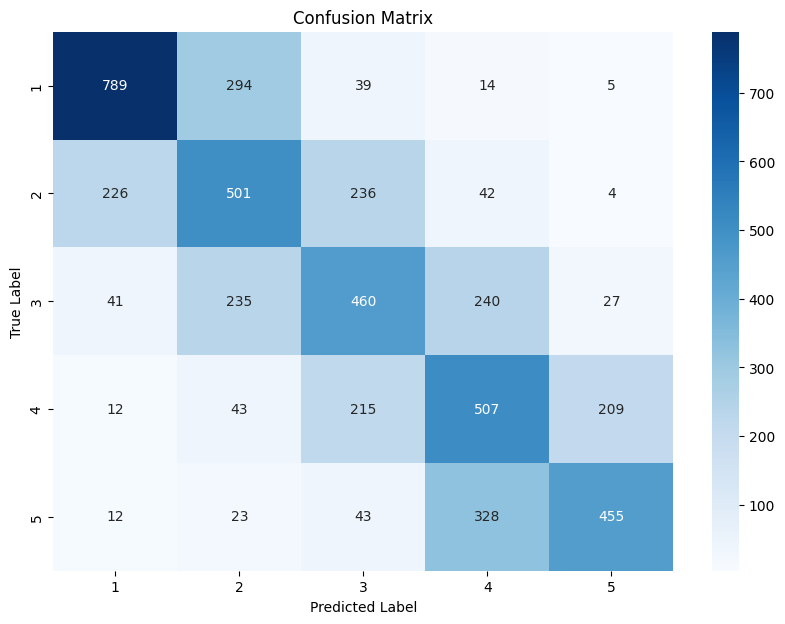

In [ ]:
metrics(y_test, y_pred_jakka_Bert_Classifier)

#### BeckyB/Bert_Classifier

This model is a fine-tuned version of bert-base-cased on the yelp_review_full dataset. It achieves the following results on the evaluation set:

* Loss: 1.1067
* Accuracy: 0.5533

In [ ]:
tokenizer_BeckyB_Bert_Classifier = AutoTokenizer.from_pretrained("BeckyB/Bert_Classifier")
model_BeckyB_Bert_Classifier = AutoModelForSequenceClassification.from_pretrained("BeckyB/Bert_Classifier")

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
y_pred_BeckyB_Bert_Classifier = predict(x_test, tokenizer_BeckyB_Bert_Classifier, model_BeckyB_Bert_Classifier)

In [ ]:
with open('y_pred_BeckyB_Bert_Classifier.json', 'w') as f:
    json.dump(y_pred_BeckyB_Bert_Classifier, f)

In [ ]:
y_pred_BeckyB_Bert_Classifier = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_jakka_Bert_Classifier.json"))

Accuracy: 0.56
F1 Score: 0.56
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      1141
           1       0.46      0.48      0.47      1009
           2       0.47      0.42      0.45      1003
           3       0.47      0.50      0.49       986
           4       0.65      0.63      0.64       861

    accuracy                           0.56      5000
   macro avg       0.55      0.55      0.55      5000
weighted avg       0.56      0.56      0.56      5000



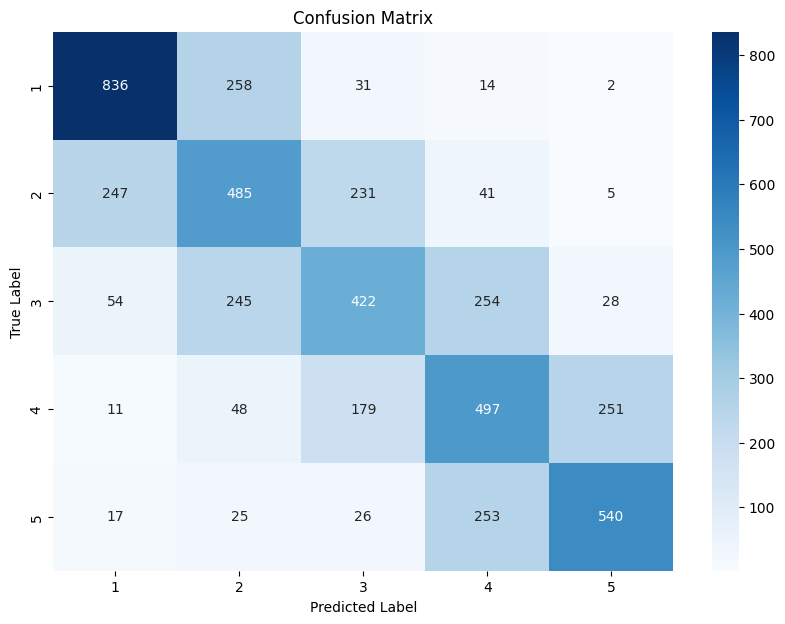

In [ ]:
metrics(y_test, y_pred_BeckyB_Bert_Classifier)

#### Shunian/yelp_review_classification

In [ ]:
tokenizer_Shunian_yelp_review_classification = AutoTokenizer.from_pretrained("Shunian/yelp_review_classification")
model_Shunian_yelp_review_classification = AutoModelForSequenceClassification.from_pretrained("Shunian/yelp_review_classification")

tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [ ]:
y_pred_Shunian_yelp_review_classification = predict(x_test, tokenizer_Shunian_yelp_review_classification, model_Shunian_yelp_review_classification)

In [ ]:
with open('y_pred_Shunian_yelp_review_classification.json', 'w') as f:
    json.dump(y_pred_Shunian_yelp_review_classification, f)

In [ ]:
y_pred_Shunian_yelp_review_classification = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_Shunian_yelp_review_classification.json"))

Accuracy: 0.68
F1 Score: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1141
           1       0.63      0.61      0.62      1009
           2       0.63      0.63      0.63      1003
           3       0.62      0.58      0.60       986
           4       0.71      0.78      0.74       861

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



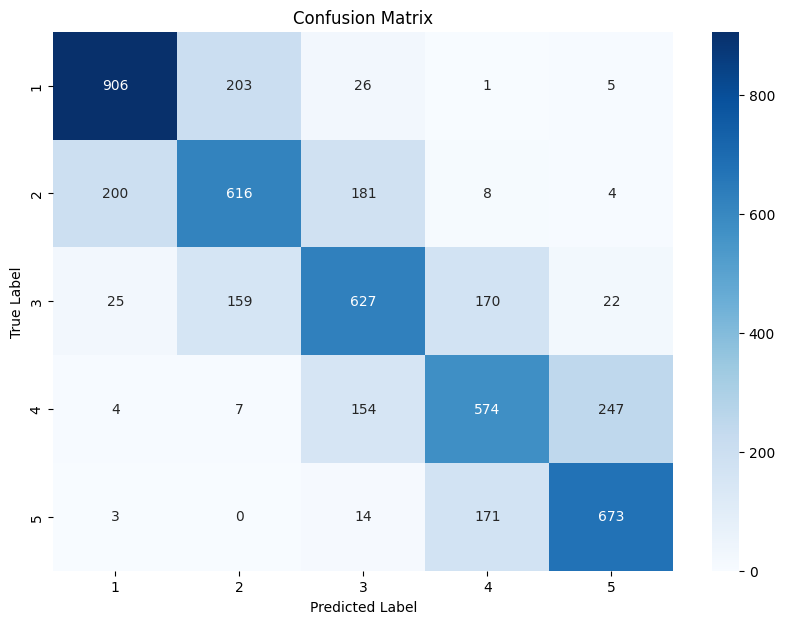

In [ ]:
metrics(y_test, y_pred_Shunian_yelp_review_classification)

#### rukshanCodeGen/dummp

In [ ]:
tokenizer_rukshanCodeGen_dummp = AutoTokenizer.from_pretrained("rukshanCodeGen/dummp")
model_rukshanCodeGen_dummp = AutoModelForSequenceClassification.from_pretrained("rukshanCodeGen/dummp")

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
y_pred_rukshanCodeGen_dummp = predict(x_test, tokenizer_rukshanCodeGen_dummp, model_rukshanCodeGen_dummp)

In [ ]:
with open('y_pred_rukshanCodeGen_dummp.json', 'w') as f:
    json.dump(y_pred_rukshanCodeGen_dummp, f)

In [ ]:
y_pred_rukshanCodeGen_dummp = y_pred_rukshanCodeGen_dummp= json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_rukshanCodeGen_dummp.json"))

Accuracy: 0.59
F1 Score: 0.59
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      1141
           1       0.49      0.56      0.52      1009
           2       0.53      0.44      0.48      1003
           3       0.51      0.55      0.53       986
           4       0.67      0.68      0.67       861

    accuracy                           0.59      5000
   macro avg       0.59      0.59      0.59      5000
weighted avg       0.59      0.59      0.59      5000



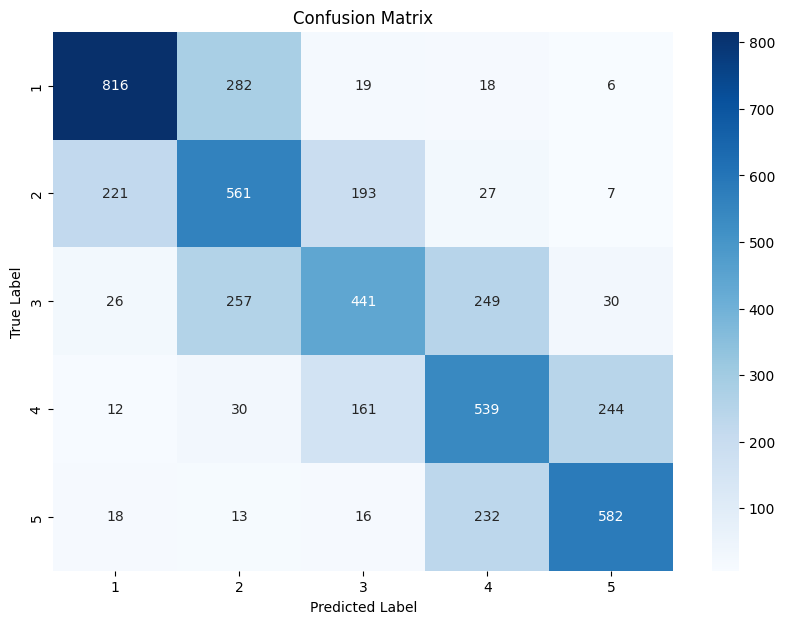

In [ ]:
metrics(y_test, y_pred_rukshanCodeGen_dummp)

#### OUR MODEL

Now we will create our tokenizer (BERT) and model. You can see our final model below:

In [ ]:
class EnhancedBertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=5):
        super(EnhancedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=8)
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.LayerNorm(64),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(64, num_labels)
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        attn_output, _ = self.attention(sequence_output, sequence_output, sequence_output)
        attn_output = self.layer_norm(attn_output + sequence_output)  # Residual connection and layer normalization
        pooled_output = attn_output.mean(dim=1)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        
        return modeling_outputs.SequenceClassifierOutput(
        loss=loss,
        logits=logits)

model = EnhancedBertClassifier()

In [ ]:
balkon_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
import torch

model_path = '/kaggle/input/balkon-model/attention_model.pth'
model_balkon.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
import contractions
import re
slang_dict = json.load(open('/kaggle/input/english-slang/slang.json', 'r'))
def preprocess(text):
    # Convert text to UTF-8 encoding
    text = text.encode('utf-8').decode('utf-8')

    # Convert special characters
    text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')

    # Expand contractions
    text = contractions.fix(text)

    # Remove quotation marks around words
    text = re.sub(r'\"(\w+)\s*\"', r'\1', text)

    # Replace dots that are not between numbers with a space
    text = re.sub(r'(?<!\d)\.|\.(?!\d)', ' ', text)

    # Handle punctuation (excluding numbers)
    text = re.sub(r"[^\w\s\.]", r" ", text)

    # Handle dots at the end of sentences (excluding numbers)
    text = re.sub(r"\b\.(?!\d)", r" ", text)
    ## Replacing slangs
    words = text.split()
    corrected_slang_words = []
    for word in words:
        if word in slang_dict:
            word = slang_dict[word].lower()
        corrected_slang_words.append(word)

    text = ' '.join(corrected_slang_words)
    return text

In [ ]:
x_test_preprocessed = []
for text in x_test:
    x_test_preprocessed.append(preprocess(text))

In [ ]:
y_pred_balkon = predict(x_test_preprocessed, balkon_tokenizer, model_balkon)

Accuracy: 0.65
F1 Score: 0.64
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1141
           1       0.66      0.50      0.57      1009
           2       0.62      0.60      0.61      1003
           3       0.59      0.48      0.53       986
           4       0.60      0.87      0.71       861

    accuracy                           0.65      5000
   macro avg       0.64      0.65      0.64      5000
weighted avg       0.65      0.65      0.64      5000



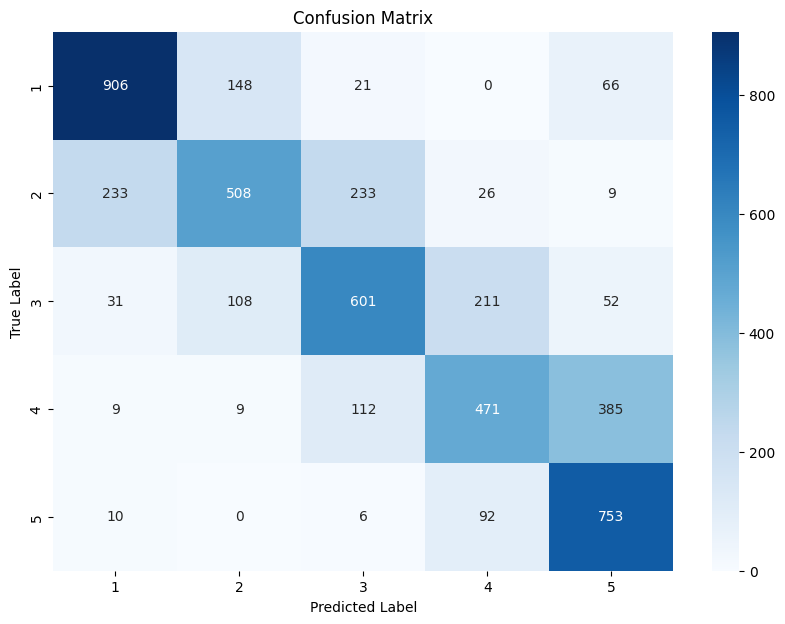

In [ ]:
metrics(y_test, y_pred_balkon)

In [ ]:
distilbert_base_uncased_finetuned_yelp_reviews_report = classification_report(y_test, y_pred_distilbert_base_uncased_finetuned_yelp_reviews)
jenniferjane_Bert_Classifier_report = classification_report(y_test, y_pred_jenniferjane_Bert_Classifier)
jakka_Bert_Classifier_report = classification_report(y_test, y_pred_jakka_Bert_Classifier)
BeckyB_Bert_Classifier_report = classification_report(y_test, y_pred_BeckyB_Bert_Classifier)
Shunian_yelp_review_classification_report = classification_report(y_test, y_pred_Shunian_yelp_review_classification)
rukshanCodeGen_dummp_report = classification_report(y_test, y_pred_rukshanCodeGen_dummp)
balkon_report = classification_report(y_test, y_pred_balkon)

- Accuracy provides a general measure of the model's performance. It is straightforward to understand and interpret, making it a common first step in evaluating classification models. However, it may not be the best metric when dealing with imbalanced datasets, as it can be misleading if one class dominates the dataset.

- The F1-score balances the trade-off between precision and recall, making it useful for scenarios where both false positives and false negatives are important. It is particularly valuable in imbalanced datasets where accuracy may not adequately reflect the performance of the model on the minority class.

- Precision measures the accuracy of the positive predictions. High precision means that the model is making few false positive errors. This is crucial in applications where false positives are particularly costly, such as spam detection or medical diagnosis.

- Recall measures the ability of the model to identify all relevant instances. High recall is essential in scenarios where missing a positive instance is critical, such as disease screening or fraud detection.

**Deriving Insights from the Metrics**

##### Comparing Models with Accuracy

Why Compare: By comparing the accuracy scores of different models, we can quickly assess which model generally performs better on the dataset.

Insights: Higher accuracy indicates better overall performance, but further analysis is needed if the dataset is imbalanced.

##### Comparing Models with F1-Scores by Class

Why Compare: Comparing F1-scores for each class across different models highlights how well each model handles different classes, especially in multi-class classification problems.

Insights: Variations in F1-scores across classes can indicate which classes are challenging for the models. A model with consistently high F1-scores across all classes is preferable.

##### Analyzing Precision and Recall by Class

Why Compare: Examining precision and recall for each class allows us to understand the trade-offs each model makes between precision and recall.

Insights: High precision with low recall may indicate that the model is conservative in its positive predictions, avoiding false positives but missing some true positives. Conversely, high recall with low precision suggests the model captures most of the positive instances but at the cost of many false positives.

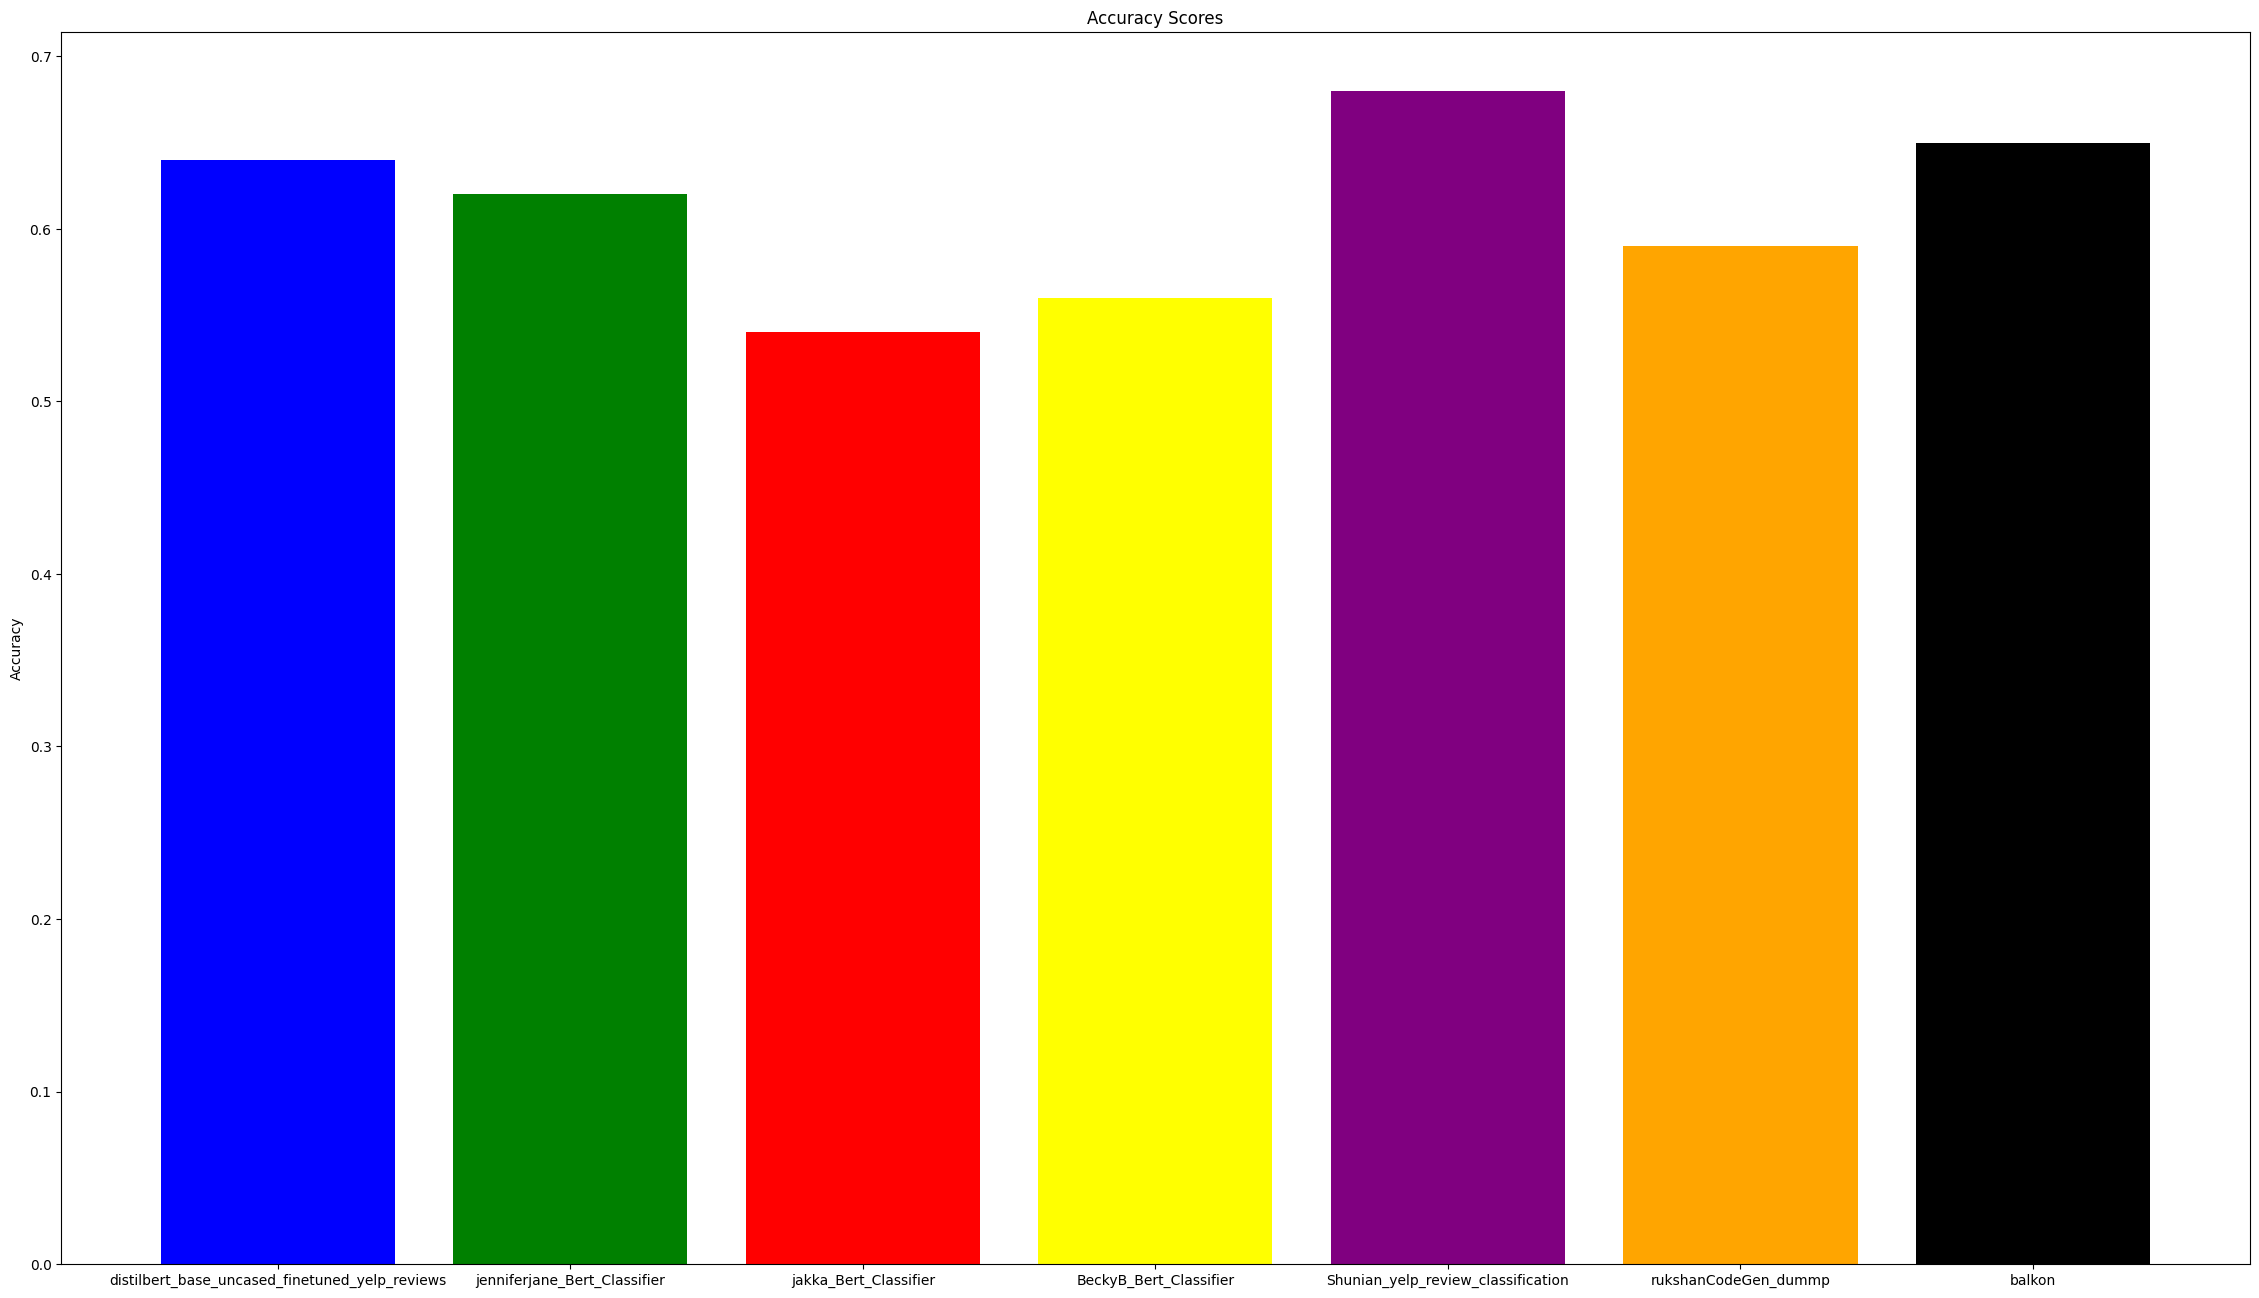

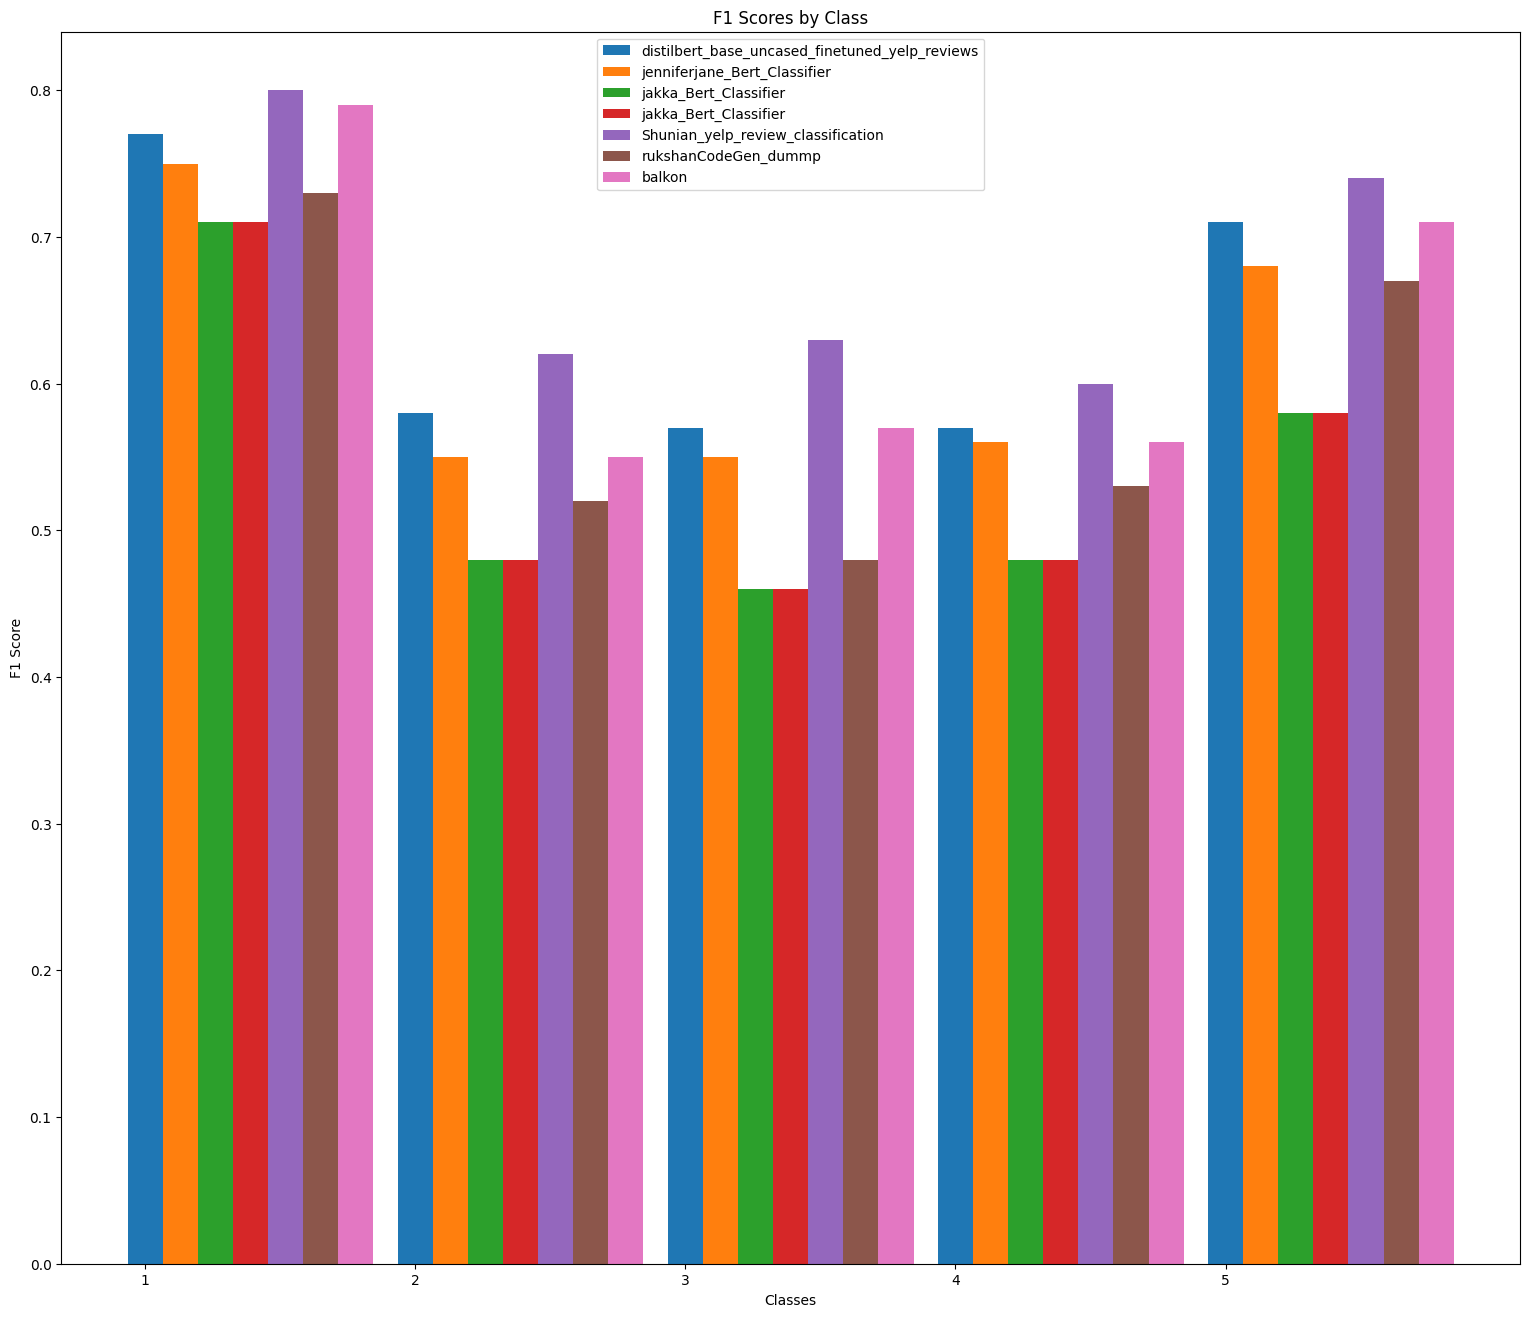

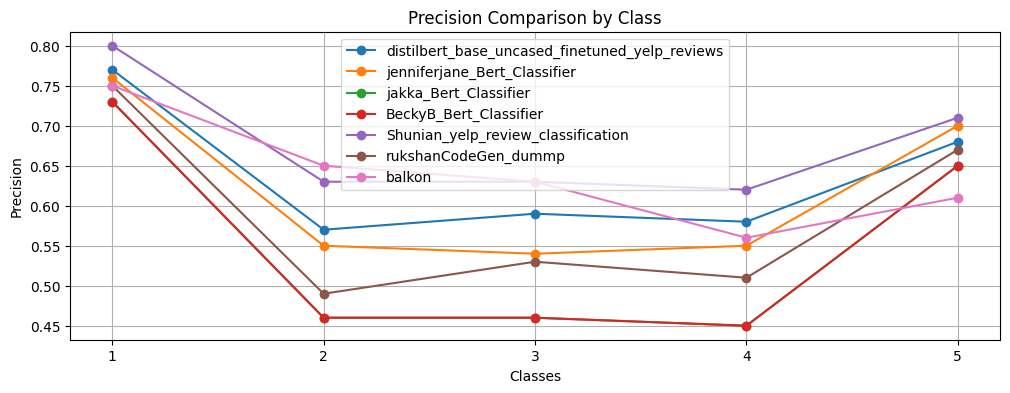

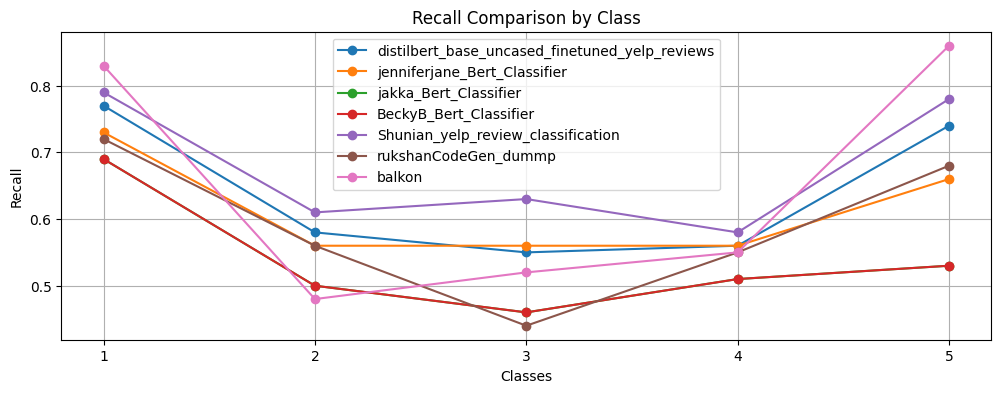

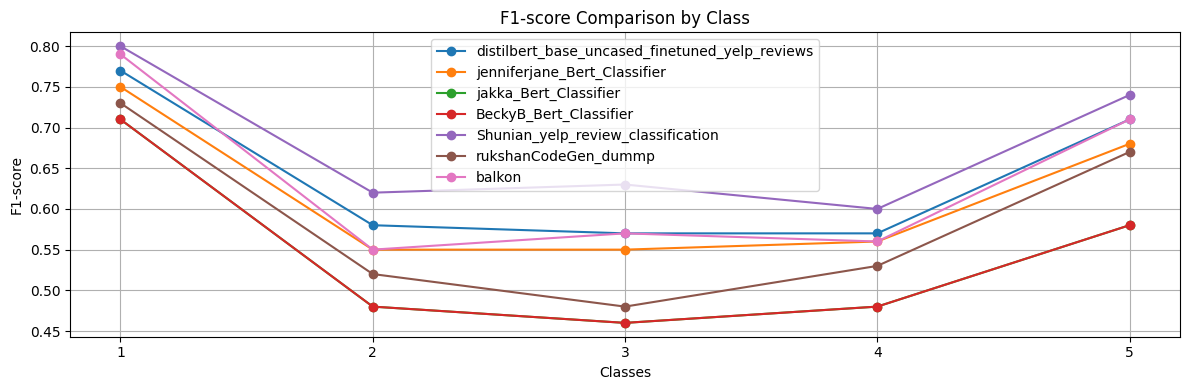

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for three models
models = ['distilbert_base_uncased_finetuned_yelp_reviews', 'jenniferjane_Bert_Classifier', 'jakka_Bert_Classifier', 'BeckyB_Bert_Classifier', 'Shunian_yelp_review_classification', 'rukshanCodeGen_dummp', 'balkon']
accuracy_scores = [0.64, 0.62, 0.54, 0.56, 0.68, 0.59, 0.65]

# F1-scores for each class for each model
f1_scores_model1 = [float(r.split()[3]) for r in distilbert_base_uncased_finetuned_yelp_reviews_report.split('\n')[2:7]] ##f1-score
f1_scores_model2 = [float(r.split()[3]) for r in jenniferjane_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
f1_scores_model3 = [float(r.split()[3]) for r in jakka_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
f1_scores_model4 = [float(r.split()[3]) for r in BeckyB_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
f1_scores_model5 = [float(r.split()[3]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]] ##f1-score
f1_scores_model6 = [float(r.split()[3]) for r in rukshanCodeGen_dummp_report.split('\n')[2:7]] ##f1-score
f1_scores_model7 = [float(r.split()[3]) for r in balkon_report.split('\n')[2:7]] ##f1-score
# Classification report metrics for each c[float(r.split()[3]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]] ##f1-scorelass (precision, recall, f1-score) for one model
# Assuming we have the same structure for Model 1, Model 2, and Model 3
classification_reports = {
    'distilbert_base_uncased_finetuned_yelp_reviews': {
        'precision': [float(r.split()[1]) for r in distilbert_base_uncased_finetuned_yelp_reviews_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in distilbert_base_uncased_finetuned_yelp_reviews_report.split('\n')[2:7]], ##recall
        'f1-score': [float(r.split()[3]) for r in distilbert_base_uncased_finetuned_yelp_reviews_report.split('\n')[2:7]] ##f1-score
    },
    'jenniferjane_Bert_Classifier': {
        'precision': [float(r.split()[1]) for r in jenniferjane_Bert_Classifier_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in jenniferjane_Bert_Classifier_report.split('\n')[2:7]], ##recall
        'f1-score': [float(r.split()[3]) for r in jenniferjane_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
    },
    'jakka_Bert_Classifier': {
        'precision': [float(r.split()[1]) for r in jakka_Bert_Classifier_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in jakka_Bert_Classifier_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in jakka_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
    },
    'BeckyB_Bert_Classifier': {
        'precision': [float(r.split()[1]) for r in BeckyB_Bert_Classifier_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in BeckyB_Bert_Classifier_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in BeckyB_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
    },
    'Shunian_yelp_review_classification': {
        'precision': [float(r.split()[1]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]] ##f1-score
    },
    'rukshanCodeGen_dummp': {
        'precision': [float(r.split()[1]) for r in rukshanCodeGen_dummp_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in rukshanCodeGen_dummp_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in rukshanCodeGen_dummp_report.split('\n')[2:7]] ##f1-score   
    },
    'balkon': {
        'precision': [float(r.split()[1]) for r in balkon_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in balkon_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in balkon_report.split('\n')[2:7]] ##f1-score         
    }
}

# Plot accuracy scores
plt.figure(figsize=(96, 16))
plt.subplot(1, 3, 1)
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red', 'yellow', 'purple', 'orange', 'black'])
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')

# Plot F1-scores for each class
classes = ['1', '2', '3', '4', '5']
x = np.arange(len(classes))

plt.figure(figsize=(64, 16))
plt.subplot(1, 3, 2)
width = 0.13
plt.bar(x, f1_scores_model1, width, label='distilbert_base_uncased_finetuned_yelp_reviews')
plt.bar(x + (width), f1_scores_model2, width, label='jenniferjane_Bert_Classifier')
plt.bar(x + (2*width), f1_scores_model3, width, label='jakka_Bert_Classifier')
plt.bar(x + (3*width), f1_scores_model4, width, label='jakka_Bert_Classifier')
plt.bar(x + (4*width), f1_scores_model5, width, label='Shunian_yelp_review_classification')
plt.bar(x + (5*width), f1_scores_model6, width, label='rukshanCodeGen_dummp')
plt.bar(x + (6*width), f1_scores_model7, width, label='balkon')

plt.title('F1 Scores by Class')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.xticks(x, classes)
plt.legend()

# Plot precision, recall, f1-score for each class for one model
metrics = ['precision', 'recall', 'f1-score']
for metric in metrics:
    plt.figure(figsize=(12, 4))
    plt.title(f'{metric.capitalize()} Comparison by Class')
    for model, data in classification_reports.items():
        plt.plot(classes, data[metric], marker='o', label=model)
    plt.xlabel('Classes')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


But we made this experiment with 5000 samples. Now let's compare the results of the all test dataset.

In [ ]:
# Sample data for three models
models = ['distilbert_base_uncased_finetuned_yelp_reviews', 'jenniferjane_Bert_Classifier', 'jakka_Bert_Classifier', 'BeckyB_Bert_Classifier', 'Shunian_yelp_review_classification', 'rukshanCodeGen_dummp', 'balkon']
accuracy_scores = [0.6425, 0.634, 0.43, 0.5533, 0.6852, 0.638, 0.6890]

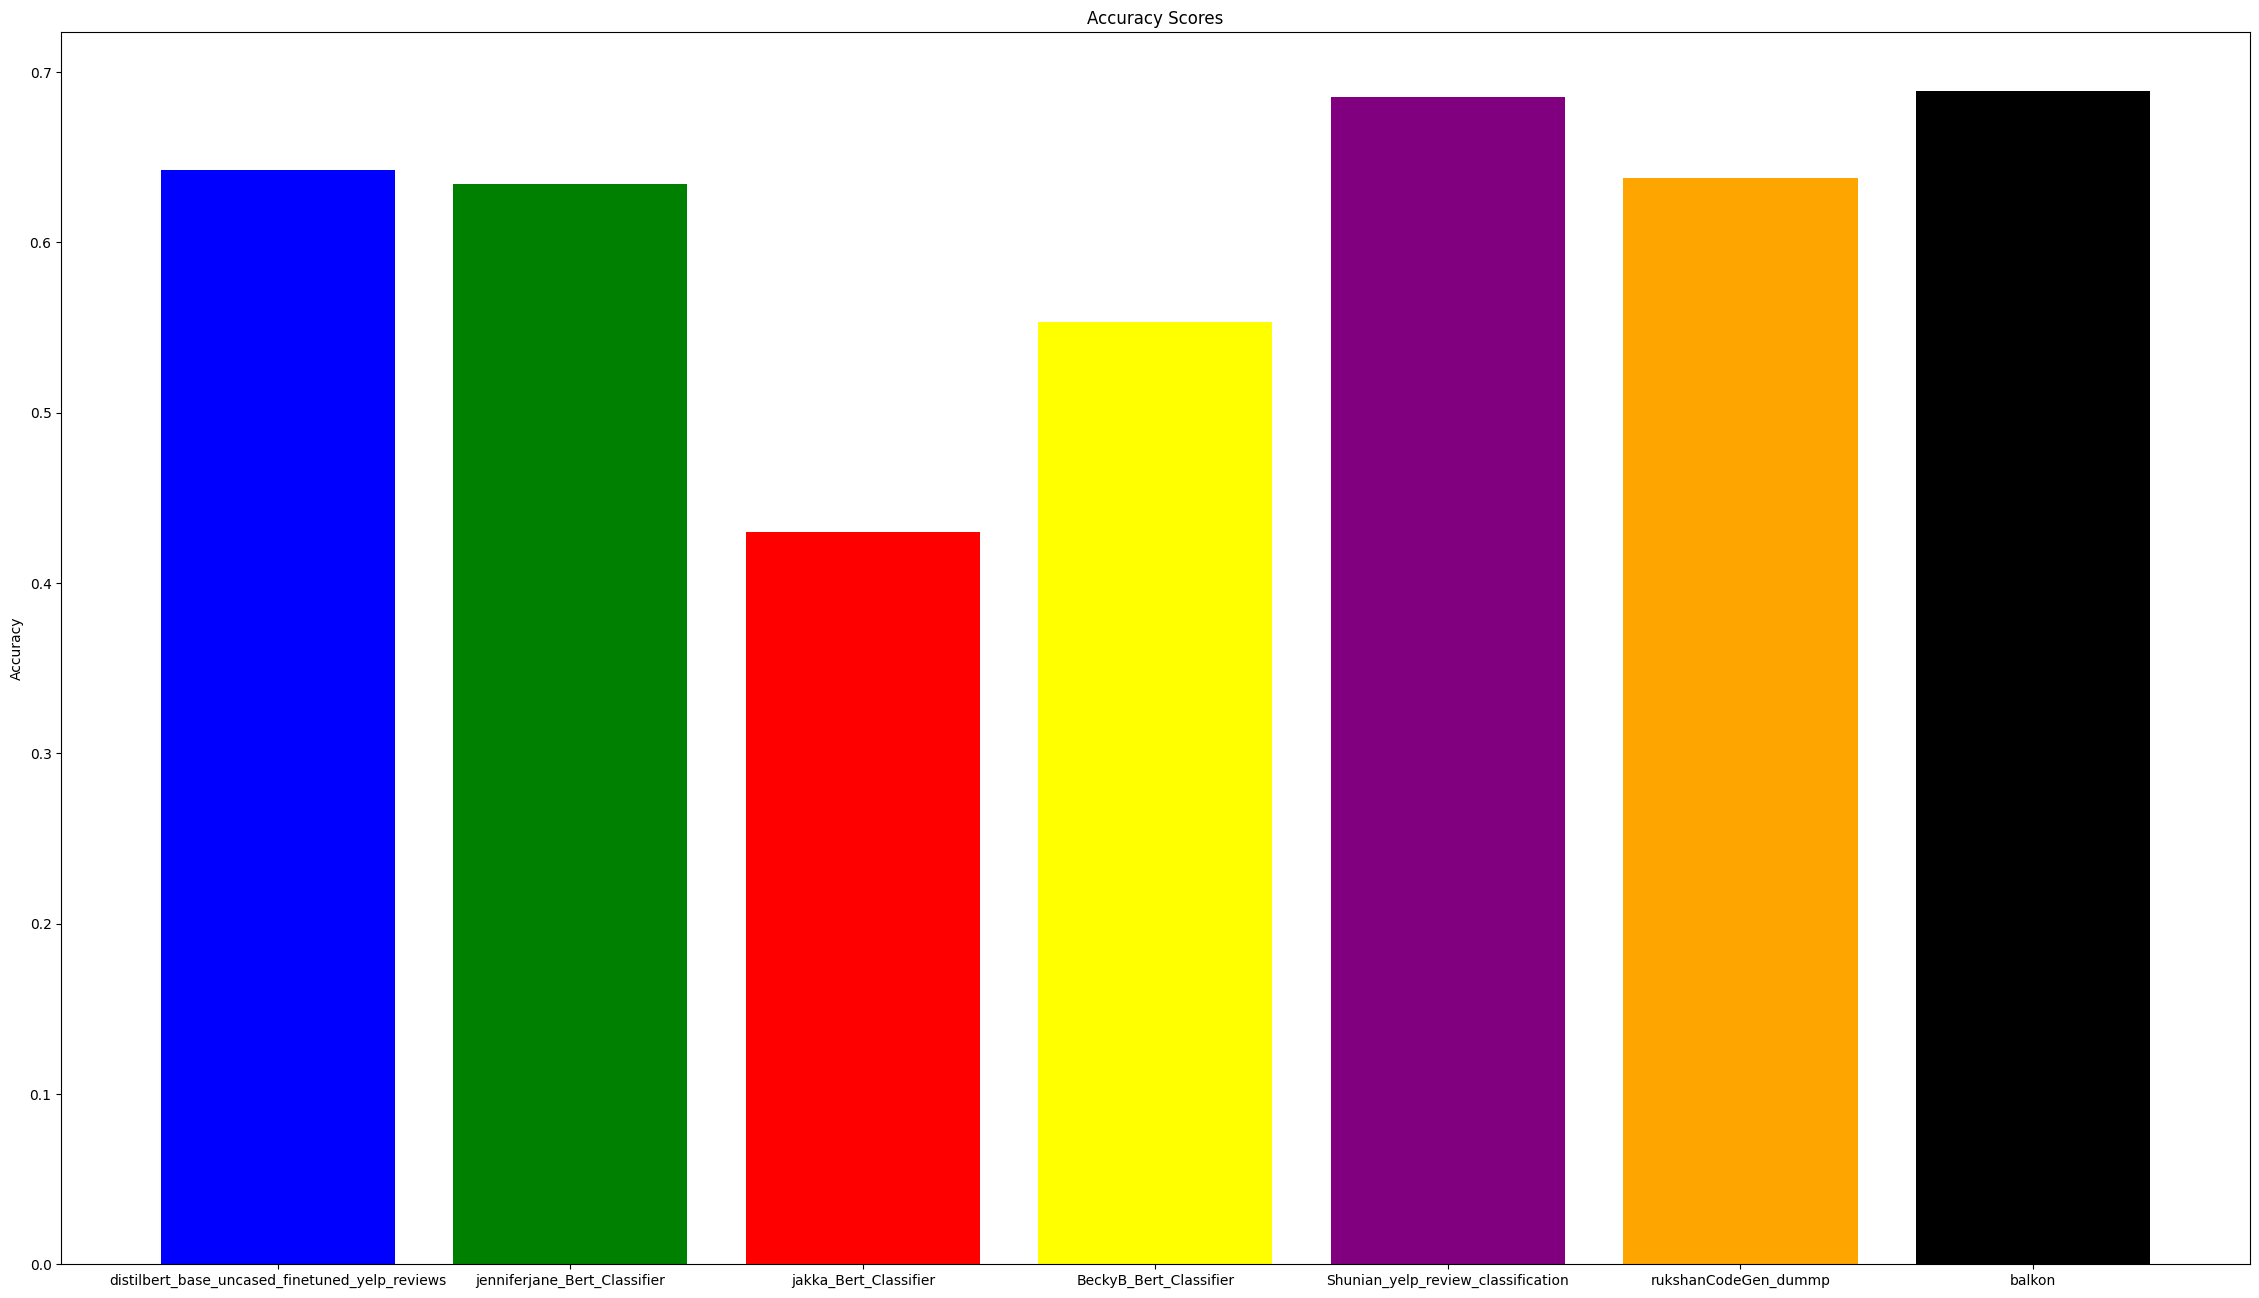

In [ ]:
# Plot accuracy scores
plt.figure(figsize=(96, 16))
plt.subplot(1, 3, 1)
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red', 'yellow', 'purple', 'orange', 'black'])
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

* Our model gives better results than the models in the huggingface. 
* Shunian_yelp_review_classification is the most succesful model in the HF, however our model's accuracy and f1-score are better than this model (f1-score is very similar because test set is not unbalanced)
* Our model can give better results for best and worst reviews (especially for worst reviews).

### Conclusions

##### We achieved pretty good results when compared to the other models in the internet.

##### Especially we noticed how correct preprocessing and powerful embedding can increase the model performance. Our model gives 0.64 accuracy without preprocessing (0.69 with preprocessing).

##### Using BERT tokenizer is more powerful than the Word2Vec or Glove embeddings. You can see embedding space visualization at the beginning of the notebook.

##### Also we noticed that our attention mechanism can work better because we noticed that there can be still improvment on the learning process. Our model's accuracy and f1-scores are very similar with and without attention mechanism.

##### When you investigate the charts above, our model outperforms most of the models for negative reviews. However ,for positive reviews, our model gives a bit lower results than the models we compare. This can be a future work for us to find some ways to investigate and analyze our model in order to give better results for reviews with label 3 and 4.

### Possible Extensions (Binary Classification)

We have performed multiclass classification so far. But as you can see from the source from internet and huggingface, binary classification is also popular for this dataset.

##### Sentiment Analysis
**Data Preparation**

Labeling: Assign labels to the reviews. For binary sentiment analysis:

* Positive reviews (4 and 5 stars) -> Label as 1.
* Negative reviews (1 and 2 stars) -> Label as 0.
* Optionally, exclude 3-star reviews for a clear binary distinction.

Text Preprocessing:
* Tokenization
* Slang removal
* Vectorization (BERT embeddings)

**Model Building**

Feature Extraction:

* Convert reviews into numerical representations using methods like Bag of Words (BoW), TF-IDF, or embeddings from pre-trained language models.
* We use our neural network architecture for this task.

Model Selection:
* EnhancedBertClassifier (look the above code)

Training and Evaluation:

* Split the data into training and test sets.
* Train the model on the training set.
* Evaluate the model on the test set using metrics like accuracy, precision, recall, F1-score, and ROC-AUC.


In [ ]:
# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model_balkon_binary = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(64, 2)  # Change output to 2 for binary classification
)

# Replace the classifier of the pre-trained model
model_balkon_binary.classifier = classifier

# Update the number of labels in the config
model_balkon_binary.config.num_labels = 2  # Change to 2 for binary classification
model_balkon_binary.num_labels = 2  # Change to 2 for binary classification

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

model_path = '/kaggle/input/balkon-model/binary_model.pth'
model_balkon_binary.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
x_test_all = test_dataset['text']
y_test_all = test_dataset['label']

In [ ]:
x_test_all_preprocessed = []
y_test_all_new = []
for i,text in enumerate(x_test_all):
    if y_test_all[i] == 2:
        continue
    x_test_all_preprocessed.append(preprocess(text))
    if y_test_all[i] == 0 or y_test_all[i] == 1:
        y_test_all_new.append(0)
    if y_test_all[i] == 3 or y_test_all[i] == 4:
        y_test_all_new.append(1)

In [ ]:
len(y_test_all_new)

40000

In [ ]:
y_binary_pred_balkon = predict(x_test_all_preprocessed[:5000], balkon_tokenizer, model_balkon_binary)

Accuracy: 0.96
F1 Score: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2681
           1       0.96      0.96      0.96      2319

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



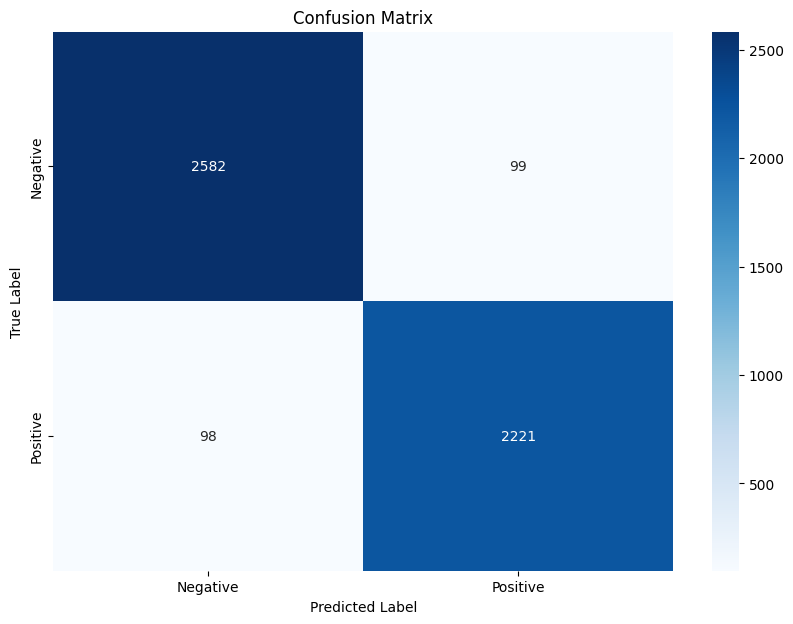

In [ ]:
metrics(y_test_all_new[:5000], y_binary_pred_balkon,  binary=True)

##### We have achieved 0.96 accuracy and 0.96 F1-Score with our model for binary classification task on this dataset. This result indicates that there can be possible improvements in our model.

##### Also we can consider to ensemble models in order to achieve better results for our main task. Ensemble modeling is the process of running two or more related but different analytical models and then synthesizing the results into a single score or spread. This improves the accuracy of predictive analytics and data mining applications.

#### References
1. Wu, M., Nafziger, J., Scodary, A., & Maas, A.L. (2020). HarperValleyBank: A Domain-Specific Spoken Dialog Corpus. ArXiv, abs/2010.13929.
2. Wu, S., Wang, X., & Qi, B. (2020). A New Semantic Approach on Yelp Review-star Rating Classification.
3. Liu, Z. (2020). Yelp Review Rating Prediction: Machine Learning and Deep Learning Models. ArXiv, abs/2012.06690.
4. Yang, S., Yu, X., & Zhou, Y. (2020). LSTM and GRU Neural Network Performance Comparison Study: Taking Yelp Review Dataset as an Example. 2020 International Workshop on Electronic Communication and Artificial Intelligence (IWECAI), 98-101.